In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
with open("active_zerodisorder.txt", "r") as active_zerodisorder:
    active_zerodisorder_rl = active_zerodisorder.readlines()
    active_zerodisorder_names = [f.strip().replace(".cif", "") for f in active_zerodisorder_rl]
    active_pdbfn = [f.strip().split("_")[4][:4].lower()+".cif" for f in active_zerodisorder_rl]


In [6]:
from src.download_data import url_formation_for_pool, download_with_pool

In [8]:
download_with_pool(url_formation_for_pool("SIFTS",active_pdbfn[:1]))

Download xml file: 100%|██████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


In [7]:
all_done = os.listdir("./structures/AF220_mmCIF_230427/")
all_done.sort()

with open('output_file.txt', 'w') as f:
    for item in all_done:
        item = item.replace(".cif","")
        f.write(f'{item}\n')

with open('realkinaselist') as realk:
    realk_rl = [rk.strip() for rk in realk.readlines()]

In [396]:
conditions_set = set()
for paths in all_done:
    conditions_set.add("_".join(paths.split("_")[6:9]))
conditions_list = list(conditions_set)
conditions_list.sort()

condition_paths_GGs_totalingnum =dict()
for cond in conditions_set:
    pathlist_temp_msalim_source = []
    set_GGs_temp_msalim_source = set()
    
    for pdbfn in all_done:
        GG = pdbfn.split("_")[0] + "_" + pdbfn.split("_")[1]
        if GG in realk_rl and "_Active_" in pdbfn:
            if cond in pdbfn:
                pathlist_temp_msalim_source.append(pdbfn)
                set_GGs_temp_msalim_source.add(pdbfn.split("_")[0]+"_"+pdbfn.split("_")[1])

    condition_paths_GGs_totalingnum[cond] = [len(set_GGs_temp_msalim_source), len(pathlist_temp_msalim_source),pathlist_temp_msalim_source,set_GGs_temp_msalim_source]
    

In [397]:
cumulutive_set = set()
data = dict()
for cond in logical_order:
    for k,v in condition_paths_GGs_totalingnum.items():
        if cond == k:
            cumulutive_set.update(v[3])
            MSAl = k.split("_")[1]
            MSAl = ''.join([char for char in MSAl if char.isdigit()])
            
            MSAs = k.split("_")[2]
            if "ortholog" in MSAs:
                MSAs = "O"
            elif "family" in MSAs:
                MSAs = "F"
            
            template = k.split("_")[0]
            if "activePDB" in template:
                template = "A"
            elif "distilledActive60" in template:
                template = "D"
                
            data[k]=v[0:1]+[len(cumulutive_set)]+[template+MSAs+MSAl]

In [398]:
set(realk_rl)-set(cumulutive_set)

{'CAMK_OBSCN-2', 'TYR_LMTK2'}

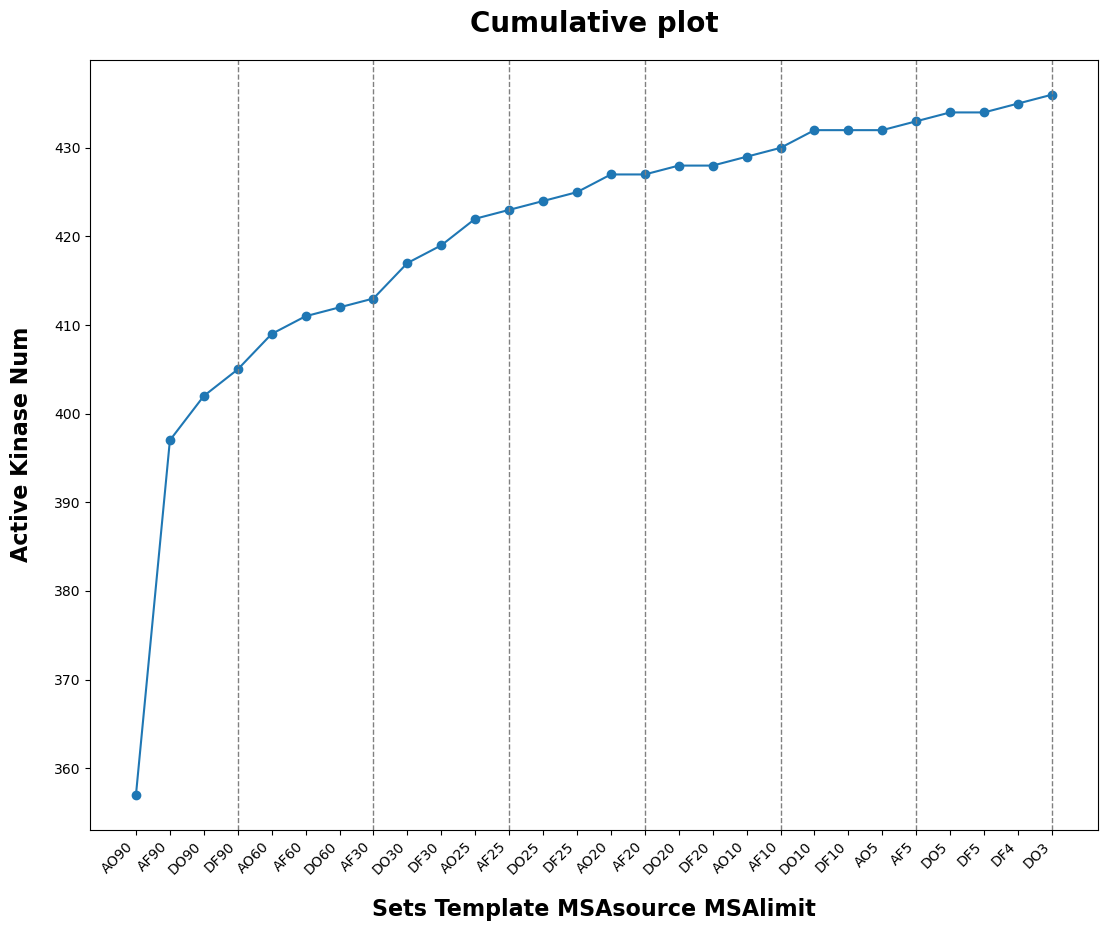

In [400]:
import matplotlib.pyplot as plt

# Data

# Labels and values
# labels = list(data.keys())
labels = [item[2] for item in data.values()]
values = [item[1] for item in data.values()]
plt.figure(figsize=(13, 10))
# Create a bar plot
# plt.bar(labels, values)
plt.plot(labels, values, marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add vertical lines every 4 points
for i in range(-1, len(labels), 4):
    if i == -1:
        continue
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)

# Add labels and title with improved style
plt.xlabel('Sets Template MSAsource MSAlimit', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Active Kinase Num', fontsize=16, fontweight='bold', labelpad=15)
plt.title('Cumulative plot', fontsize=20, fontweight='bold', pad=20)

# Show the plot
plt.show()

In [3]:
import os
import gzip
from Bio.PDB import MMCIFParser, PDBIO, Select
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from src.unmodify import unmodify_pdb
from src.clean_up_files import remove_files_not_ending_with
from src.keep_one_occupancy import keep_one_occupancy
from src.from_mmcif_get_pdbchain import CustomMMCIFParser, ChainSelect 
from src.clean_up_files import remove_files_not_ending_with

# Directory containing the .cif.gz files
input_dir = './structures/Human_Allgroups_Allspatials_Alldihedrals_All_uniNum'
# Directory to save the .pdb files
output_dir = './structures/Human_Allgroups_Allspatials_Alldihedrals_All_uniNum_mypdb'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def process_chain(active_zerodisorder_name):
    # Directory containing IO files
    input_dir = './structures/Human_Allgroups_Allspatials_Alldihedrals_All_uniNum'
    output_dir = './structures/Human_Allgroups_Allspatials_Alldihedrals_All_uniNum_mypdb'
    parser = CustomMMCIFParser(QUIET=True)
    pdb_io = PDBIO()

    pdbid = active_zerodisorder_name.split("_")[4][:4].lower()
    chainid = active_zerodisorder_name.split("_")[4][4:]

    if len(chainid) > 1:
        return

    cif_file = os.path.join(input_dir, f'{active_zerodisorder_name}.cif')

    with open(cif_file, 'r') as cif:
        structure = parser.get_structure(pdbid, cif)

    pdb_file = os.path.join(output_dir, f'{active_zerodisorder_name}.pdb')
    pdbunmod_file = os.path.join(output_dir, f'{active_zerodisorder_name}_unmod.pdb')
    
    pdb_io.set_structure(structure)
    pdb_io.save(pdb_file, ChainSelect(chainid))
    unmodify_pdb(pdb_file, pdbunmod_file)
    keep_one_occupancy(pdbunmod_file)

    
with ProcessPoolExecutor() as executor:
    list(tqdm(executor.map(process_chain, active_zerodisorder_names), total=len(active_zerodisorder_names)))
    remove_files_not_ending_with(output_dir, "_unmod_oneocc_noaltloc.pdb")


NameError: name 'active_zerodisorder_names' is not defined

In [4]:
import os
from Bio.PDB import PDBParser
from src.activation_loop import parse_activation_loops
from src.get_info import get_gene_group,get_first_chain_id

def check_atoms_in_activation_loop(pdb_file, gene_group, start_residue, end_residue):
    parser = PDBParser()
    structure = parser.get_structure('struct', pdb_file)
    chain_id = get_first_chain_id(structure)

    for residue in structure[0][chain_id]:
        residue_number = residue.id[1]
        if start_residue <= residue_number <= end_residue:
            for atom_name in ['N', 'CA', 'C', 'O']:
                if not residue.has_id(atom_name):
                    return(f"{os.path.basename(pdb_file)}")

directory = '/8TBSSD/side/AF2multimer/custom_db/pymol/structures/Human_Allgroups_Allspatials_Alldihedrals_All_uniNum_mypdb'
activation_loops = parse_activation_loops('actloop.fasta')

missing_stuff = []
for pdb_filename in os.listdir(directory):
    if pdb_filename.endswith('.pdb'):
        pdb_file_path = os.path.join(directory, pdb_filename)
        gene_group = get_gene_group(pdb_filename)
        if gene_group in activation_loops:
            start_residue, end_residue = map(int, activation_loops[gene_group].split('-'))
            missing = check_atoms_in_activation_loop(pdb_file_path, gene_group, start_residue, end_residue)
            if missing is not None:
                missing_stuff.append(missing)


In [5]:
missing_stuff

['CMGC_CLK3_DFGin_BLAminus_3RAWA_unmod_oneocc_noaltloc.pdb',
 'CMGC_GSK3B_DFGin_BLAminus_1J1BB_unmod_oneocc_noaltloc.pdb',
 'CMGC_GSK3B_DFGin_BLAminus_1J1CB_unmod_oneocc_noaltloc.pdb',
 'CMGC_CLK3_DFGin_BLAminus_3RAWB_unmod_oneocc_noaltloc.pdb',
 'TYR_RET_DFGin_BLAminus_2X2LA_unmod_oneocc_noaltloc.pdb',
 'CMGC_CDK2_DFGin_BLAminus_1GY3C_unmod_oneocc_noaltloc.pdb',
 'CMGC_SRPK1_DFGin_BLAminus_7PQSB_unmod_oneocc_noaltloc.pdb']

In [3]:
import os
import concurrent.futures
from Bio.PDB import MMCIFParser, PDBIO, Select
from tqdm import tqdm

# Set the input and output directories
input_directory = "./structures/AF220_mmCIF_230427"
output_directory = "./structures/AF220_PDB_230427"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

def convert_mmcif_to_pdb(filename):
    # Create a parser for mmCIF files
    mmcif_parser = MMCIFParser()

    # Create an object to write PDB files
    pdb_io = PDBIO()

    # Check if the file is an mmCIF file
    if filename.endswith(".cif") or filename.endswith(".mmcif"):
        # Parse the mmCIF file
        structure = mmcif_parser.get_structure("structure", os.path.join(input_directory, filename))

        # Remove redundant information from the filename
        clean_filename = filename.replace("_c100_", "_").replace("_plus_", "_").replace(".pdb", "")

        # Set the output filename
        output_filename = os.path.splitext(clean_filename)[0] + ".pdb"

        # Write the structure to a PDB file
        pdb_io.set_structure(structure)
        pdb_io.save(os.path.join(output_directory, output_filename), Select())

# Create a list of all mmCIF files in the input directory
mmcif_files = [f for f in os.listdir(input_directory) if f.endswith(".cif") or f.endswith(".mmcif")]

# Use a thread pool to process the files concurrently
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(convert_mmcif_to_pdb, filename) for filename in mmcif_files]
    try:
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(mmcif_files)):
            pass

    except KeyboardInterrupt:
        print("Terminating due to KeyboardInterrupt")
        for future in futures:
            future.cancel()

100%|█████████████████████████████████████| 90320/90320 [23:49<00:00, 63.20it/s]


In [6]:
import os
import re
from pymol2 import PyMOL
import pandas as pd
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionException
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from src.b_factor import activation_loop_average_and_min_b_factor, overall_average_b_factor, calculate_b_factors
from src.activation_loop import parse_activation_loops
from src.get_info import get_gene_group, get_pdb_files, get_status, get_first_chain_id, get_conf
from src.TMalign_calc import TMalign_calc
from src.remove_unmod import remove_unmodified_files
import datetime

# ... (your existing code to initialize variables and load PDB files) ...
# Define the structures folder
structures_folder = os.path.abspath("./structures")
# PDB folders within the structures folder
pdb_folder1 = os.path.join(structures_folder, "Human_Allgroups_Allspatials_Alldihedrals_All_uniNum_mypdb")
pdb_folder2 = os.path.join(structures_folder, "Human_Allgroups_Allspatials_Alldihedrals_All_uniNum_mypdb")
remove_unmodified_files(pdb_folder2)


#parser = PDBParser()
activation_loops = parse_activation_loops('actloop.fasta')
pdb_files1, pdb_files2 = get_pdb_files(pdb_folder1, pdb_folder2, get_gene_group)


# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns= ["Gene_Group", "Template", "MSAlim", "MSAlimNum", "MSAsource",
                                    "RMSD_Before_Alignment", 
                                    "RMSD_After_Alignment_actloop40N", 
                                    "RMSD_After_Cealignment_actloop40N", 
                                    "RMSD_After_Super_actloop40N", 
                                    "RMSD_After_TMalign_actloop40N",
                                    "RMSD_After_Alignment_whole", 
                                    "RMSD_After_Cealignment_whole", 
                                    "RMSD_After_Super_whole",
                                    "RMSD_After_TMalign_whole",
                                    "Avg_PLDDT_All", "Min_PLDDT_All", "Avg_PLDDT_Act_Loop", "Min_PLDDT_Act_Loop", 
                                    "Status", "Conformation", "PDB_File1", "PDB_File2",])
results = []
for gene_group, pdb_file1_list in list(pdb_files1.items())[:]:
    pdb_file2_confs = pdb_files2[gene_group]
    # Create a set to store processed file combinations
    processed_combinations = set()
    for pdb_file2 in pdb_file2_confs:
        for pdb_file1 in pdb_file1_list:
            # Sort file names and create a tuple
            file_pair = tuple(sorted((pdb_file1, pdb_file2)))
            if os.path.basename(pdb_file1) in missing_stuff or os.path.basename(pdb_file2) in missing_stuff or pdb_file1 == pdb_file2:
                continue
            # Check if the combination has been processed before
            if file_pair not in processed_combinations:
                # Add the processed combination to the set
                processed_combinations.add(file_pair)

def process_gene_group(gene_group, pdb_file1_list, pdb_files2, activation_loops, missing_stuff):
    results = []
    processed_combinations = set()
    pdb_file2_confs = pdb_files2[gene_group]
    
    for pdb_file2 in pdb_file2_confs:
        for pdb_file1 in pdb_file1_list:
            # Sort file names and create a tuple
            file_pair = tuple(sorted((pdb_file1, pdb_file2)))
            if os.path.basename(pdb_file1) in missing_stuff or os.path.basename(pdb_file2) in missing_stuff or pdb_file1 == pdb_file2:
                continue
            # Check if the combination has been processed before
            if file_pair not in processed_combinations:
                # Add the processed combination to the set
                processed_combinations.add(file_pair)

                start_residue, end_residue = map(int, activation_loops[gene_group].split('-'))

                # Adjust the start_residue to include 40 residues before
                start_residue_adjusted = max(1, start_residue - 40)

                # Parse the structures
                parser = PDBParser()
                structure1 = parser.get_structure('struct1', pdb_file1)
                structure2 = parser.get_structure('struct2', pdb_file2)

                # Get the chain IDs
                chain_id1 = get_first_chain_id(structure1)
                chain_id2 = get_first_chain_id(structure2)

                # Get the last residue numbers
                last_residue1 = max(residue.id[1] for residue in structure1[0][chain_id1] if residue.id[0] == ' ' and not residue.is_disordered())
                last_residue2 = max(residue.id[1] for residue in structure2[0][chain_id2] if residue.id[0] == ' ' and not residue.is_disordered())

                # Set the last_residue number to the minimum of the last residues of both proteins
                last_residue_common = min(last_residue1, last_residue2)

                # Get the starting residue numbers
                start_residue1 = min(residue.id[1] for residue in structure1[0][chain_id1] if residue.id[0] == ' ' and not residue.is_disordered())
                start_residue2 = min(residue.id[1] for residue in structure2[0][chain_id2] if residue.id[0] == ' ' and not residue.is_disordered())

                # Set the start_residue number to the maximum of the starting residues of both proteins
                start_residue_common = max(start_residue1, start_residue2)
                if start_residue_common < 1:
                    continue

                with PyMOL() as pymol:
                    cmd = pymol.cmd

                    # Load the structures into PyMOL
                    cmd.load(pdb_file1, f"{gene_group}_1")
                    cmd.load(pdb_file2, f"{gene_group}_2")

                    # Define the selection strings for the residue range
                    actloop_selection1 = f"{gene_group}_1 and chain {chain_id1} and resi {start_residue}-{end_residue} and name n+ca+c+o"
                    actloop_selection2 = f"{gene_group}_2 and chain {chain_id2} and resi {start_residue}-{end_residue} and name n+ca+c+o"

                    # Define the selection strings for the residue range
                    N40actloop_selection1 = f"{gene_group}_1 and chain {chain_id1} and resi {start_residue_adjusted}-{last_residue_common} and name n+ca+c+o"
                    N40actloop_selection2 = f"{gene_group}_2 and chain {chain_id2} and resi {start_residue_adjusted}-{last_residue_common} and name n+ca+c+o"

                    # Define the selection strings for the whole protein with common start_residue
                    whole_protein_selection1 = f"{gene_group}_1 and chain {chain_id1} and resi {start_residue_common}-{last_residue_common} and name n+ca+c+o"
                    whole_protein_selection2 = f"{gene_group}_2 and chain {chain_id2} and resi {start_residue_common}-{last_residue_common} and name n+ca+c+o"

                    # calculate RMSD and perform total alignment and calculate RMSD over the activation loop again
                    try:
                        rmsd_before_align = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)
                    except pymol.CmdException as e:
                        error_msg = str(e)
                        if "Atom counts between selections don't match" in error_msg:
                            error = (f"Error calculating RMSD for {os.path.basename(pdb_file1)} vs {os.path.basename(pdb_file2)}: {error_msg}")
                        return (error, error_msg)

                    rmsd_before_align = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    cmd.delete("all"), cmd.load(pdb_file1, f"{gene_group}_1"), cmd.load(pdb_file2, f"{gene_group}_2")
                    alignment = cmd.align(N40actloop_selection1, N40actloop_selection2)
                    rmsd_after_align_actloop40N = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    cmd.delete("all"), cmd.load(pdb_file1, f"{gene_group}_1"), cmd.load(pdb_file2, f"{gene_group}_2")
                    alignment = cmd.cealign(N40actloop_selection1, N40actloop_selection2)
                    rmsd_after_cealign_actloop40N = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    cmd.delete("all"), cmd.load(pdb_file1, f"{gene_group}_1"), cmd.load(pdb_file2, f"{gene_group}_2")
                    alignment = cmd.super(N40actloop_selection1, N40actloop_selection2)
                    rmsd_after_super_actloop40N = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    cmd.delete("all"), cmd.load(pdb_file1, f"{gene_group}_1"), cmd.load(pdb_file2, f"{gene_group}_2")
                    alignment = cmd.align(whole_protein_selection1, whole_protein_selection2)
                    rmsd_after_align_whole = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    cmd.delete("all"), cmd.load(pdb_file1, f"{gene_group}_1"), cmd.load(pdb_file2, f"{gene_group}_2")
                    alignment = cmd.cealign(whole_protein_selection1, whole_protein_selection2)
                    rmsd_after_cealign_whole = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    cmd.delete("all"), cmd.load(pdb_file1, f"{gene_group}_1"), cmd.load(pdb_file2, f"{gene_group}_2")
                    alignment = cmd.super(whole_protein_selection1, whole_protein_selection2)
                    rmsd_after_super_whole = cmd.rms_cur(actloop_selection1, actloop_selection2, matchmaker=-1)

                    #TMalign_dict = TMalign_calc(pdb_file1, pdb_file2, activation_loops)

                    # Calculate and print B-factors
                    b_factors = calculate_b_factors(pdb_file1, chain_id1, start_residue, end_residue)

                    # Get the status (Active or Inactive)
                    status = get_status(pdb_file1)

                    # Get the status Template, MSAlim, MSAsource assuming position 6:9 dangerous!
                    #Template, MSAlim, MSAsource = os.path.basename(pdb_file1).split("_")[6:9]

                    # Append the results to the DataFrame
                    new_row = {
                        "Gene_Group": gene_group,
                        #"Template": Template.lstrip("temp"),
                        #"MSAlim": MSAlim,
                        #"MSAlimNum": int(''.join(re.findall(r'\d+', MSAlim))),
                        #"MSAsource": MSAsource,

                        "RMSD_Before_Alignment": rmsd_before_align,
                        "RMSD_After_Alignment_actloop40N": rmsd_after_align_actloop40N,
                        "RMSD_After_Cealignment_actloop40N": rmsd_after_cealign_actloop40N,
                        "RMSD_After_Super_actloop40N": rmsd_after_super_actloop40N,
                        #"RMSD_After_TMalign_actloop40N": TMalign_dict['RMSD_After_TMalign_actloop40N'],
                        "RMSD_After_Alignment_whole": rmsd_after_align_whole,
                        "RMSD_After_Cealignment_whole": rmsd_after_cealign_whole,
                        "RMSD_After_Super_whole": rmsd_after_super_whole,
                        #"RMSD_After_TMalign_whole": TMalign_dict['RMSD_After_TMalign_whole'],

                        "Avg_PLDDT_All": b_factors[0],
                        "Min_PLDDT_All": b_factors[1],
                        "Avg_PLDDT_Act_Loop": b_factors[2],
                        "Min_PLDDT_Act_Loop": b_factors[3],
                        "Status": status,
                        "Conformation": get_conf(pdb_file2),
                        "PDB_File1": pdb_file1,
                        "PDB_File2": pdb_file2,
                    }
                    results.append(new_row)


                    # Delete the structures from PyMOL
                    cmd.delete("all")

    return results




In [7]:
### Main loop
with ProcessPoolExecutor() as executor:
    # Start the processes
    futures = [executor.submit(process_gene_group, gene_group, pdb_file1_list, pdb_files2, activation_loops, missing_stuff) for gene_group, pdb_file1_list in list(pdb_files1.items())[:]]

    # Collect the results as they become available
    for future in tqdm(as_completed(futures), total=len(futures)):
        results_df = pd.concat([results_df, pd.DataFrame(future.result(), columns=results_df.columns)], ignore_index=True)

100%|█████████████████████████████████████| 119/119 [10:03:16<00:00, 304.17s/it]


In [14]:
# Saving file to .txt file
now = datetime.datetime.now()
date_stamp = now.strftime("%y%m%d")

results_df[results_df["RMSD_After_Alignment_actloop40N"] > 1].to_string(f'results_df_{date_stamp}.txt', index=False)


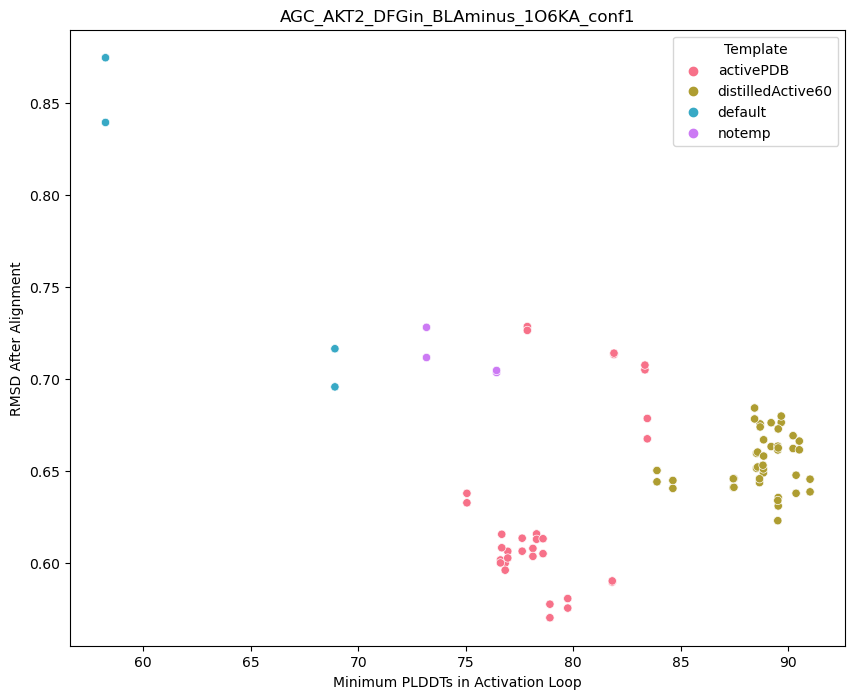

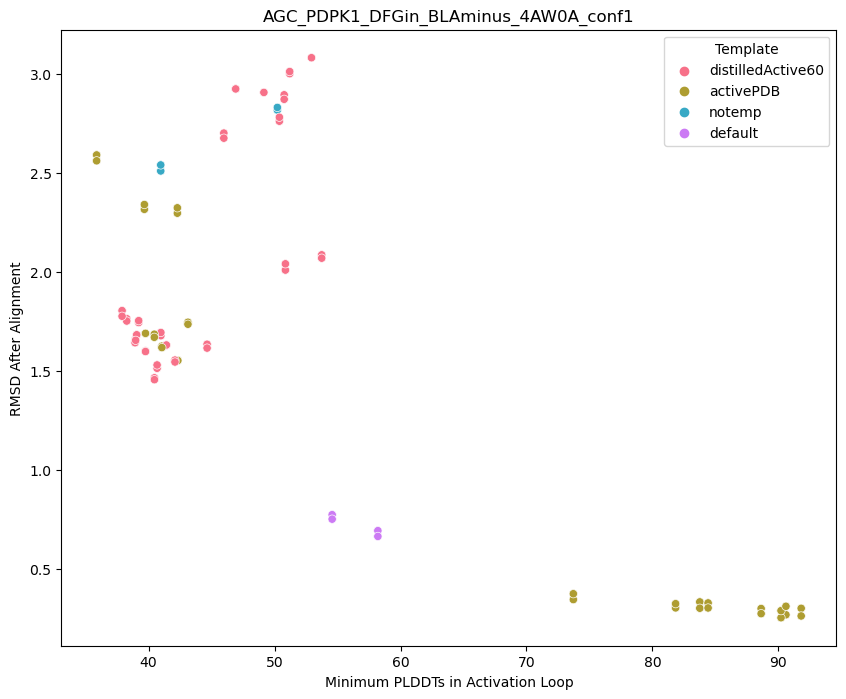

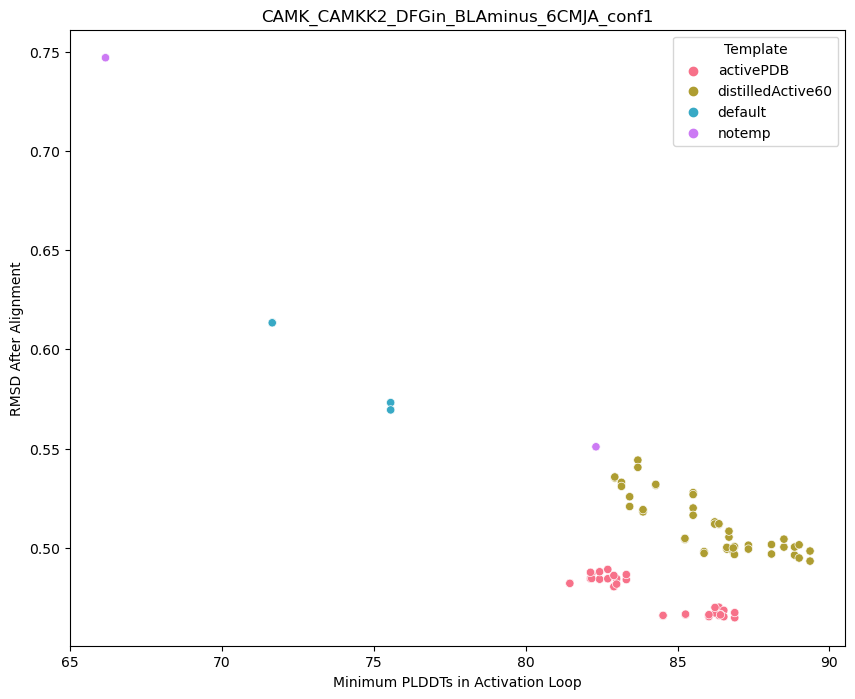

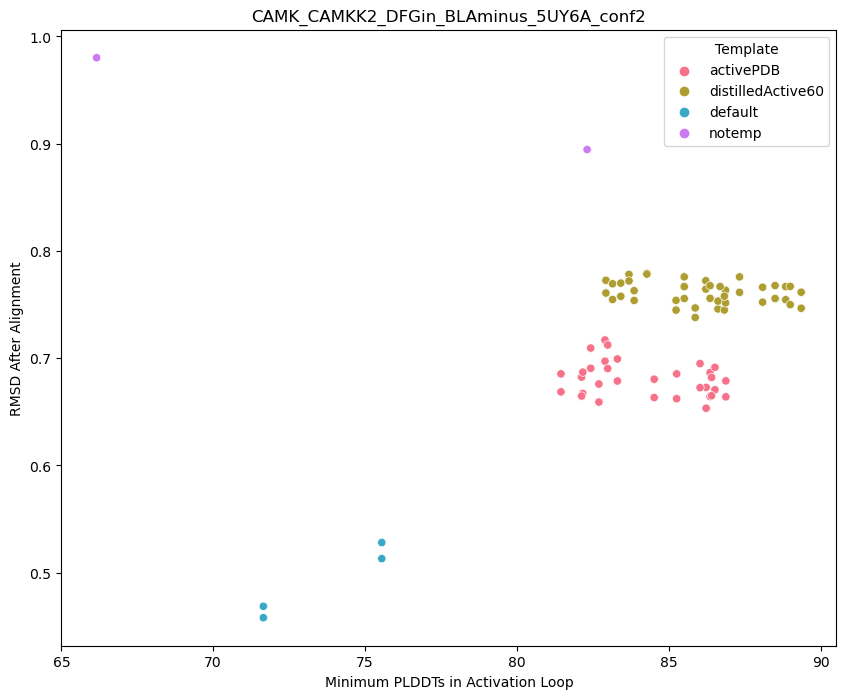

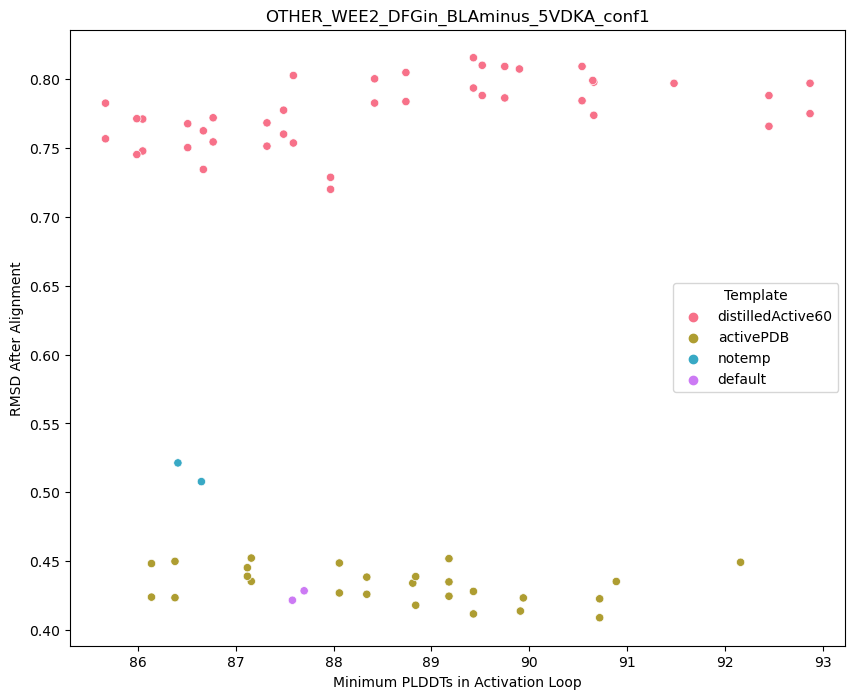

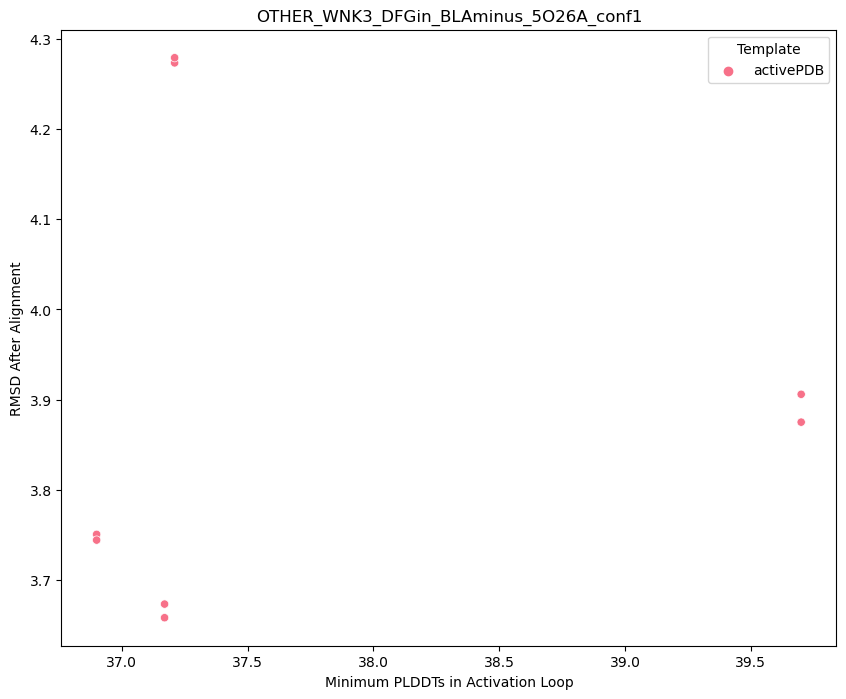

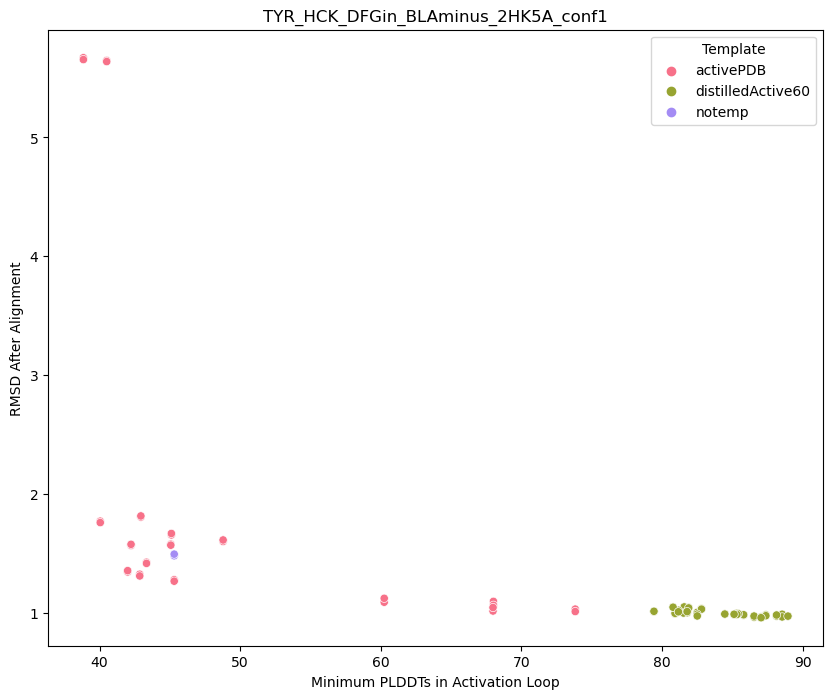

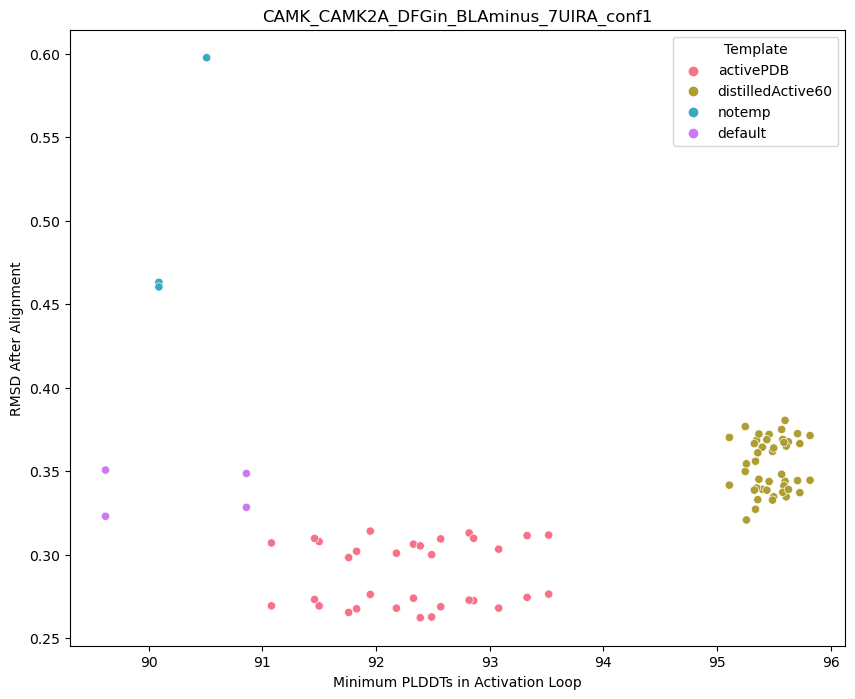

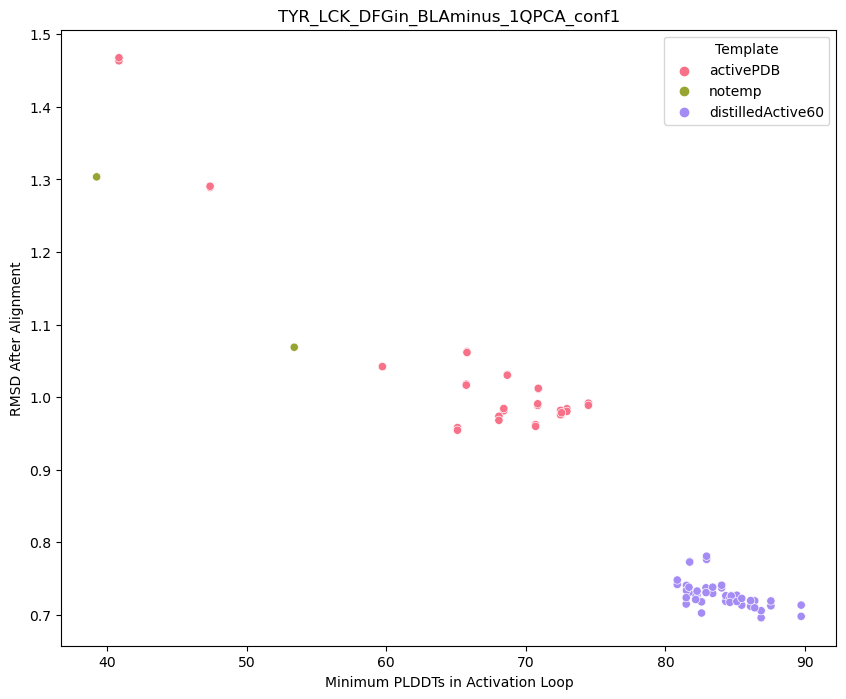

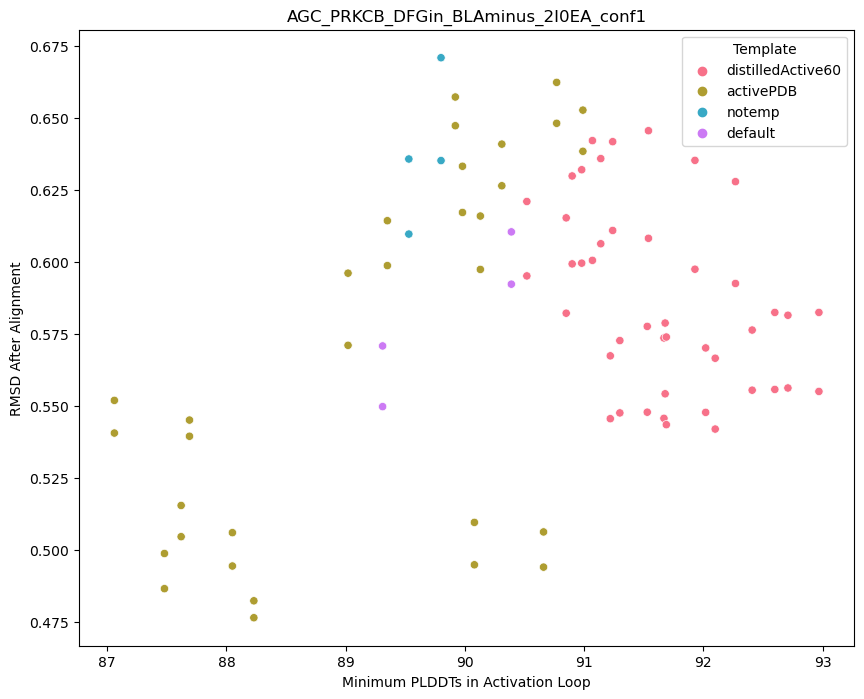

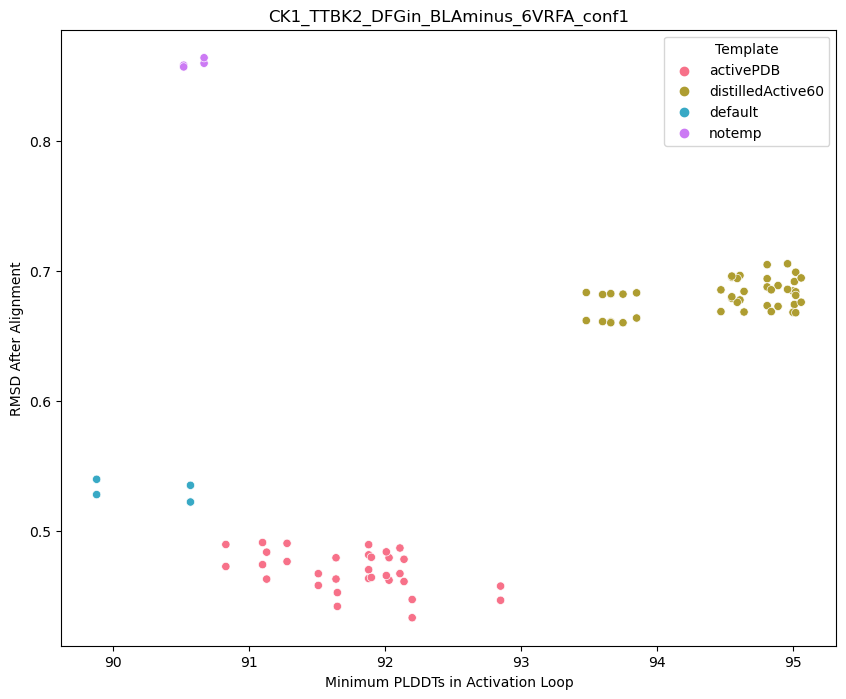

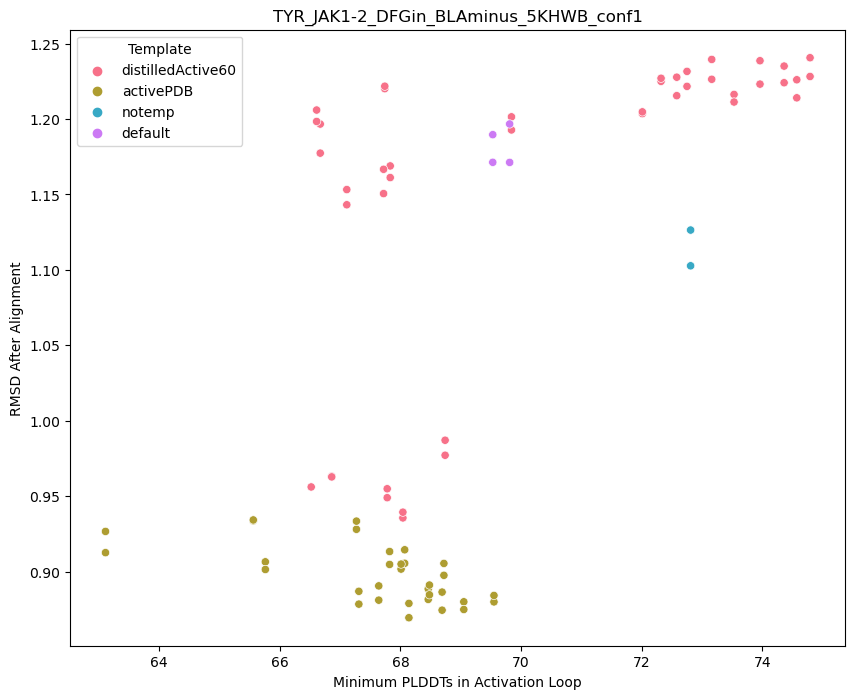

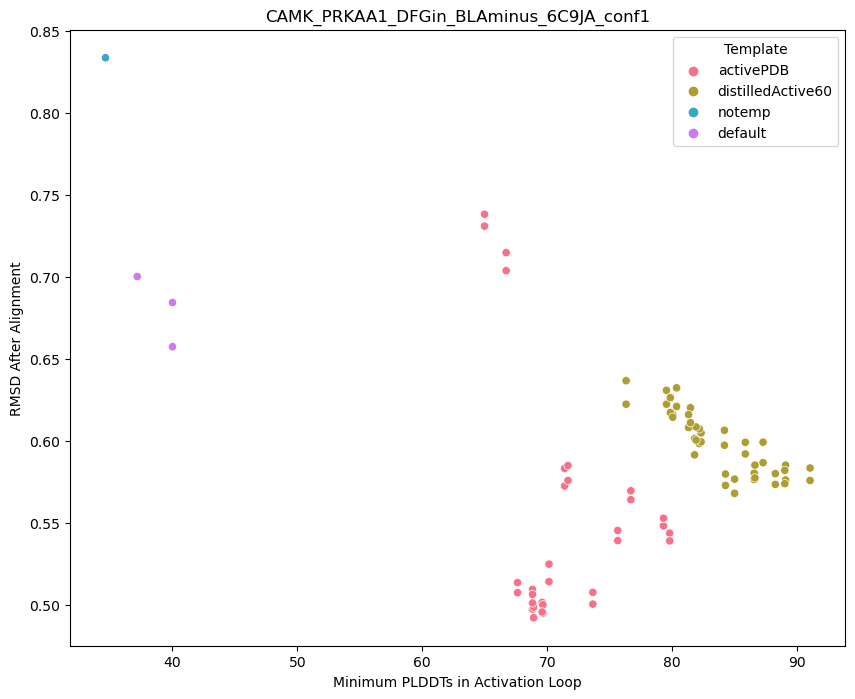

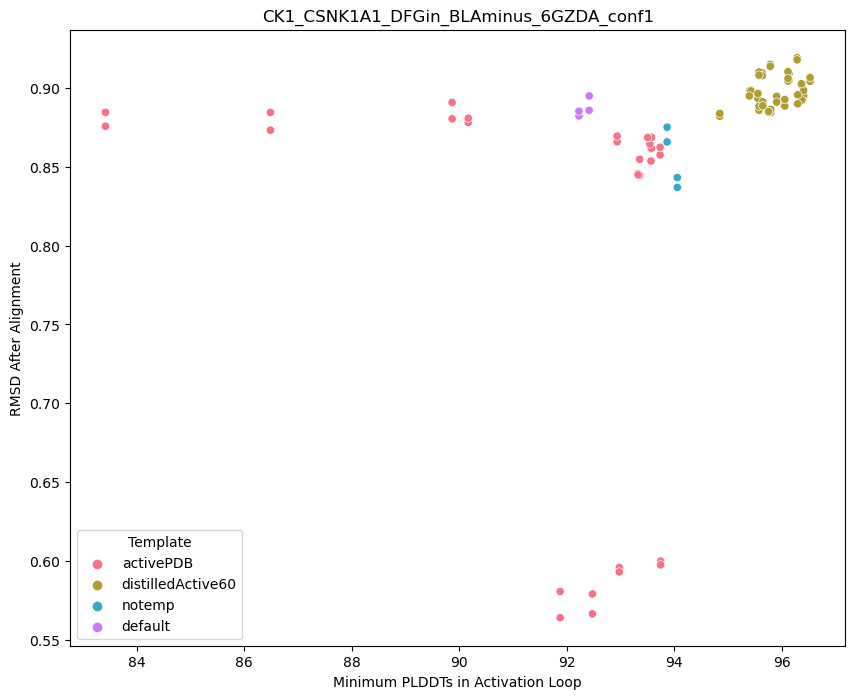

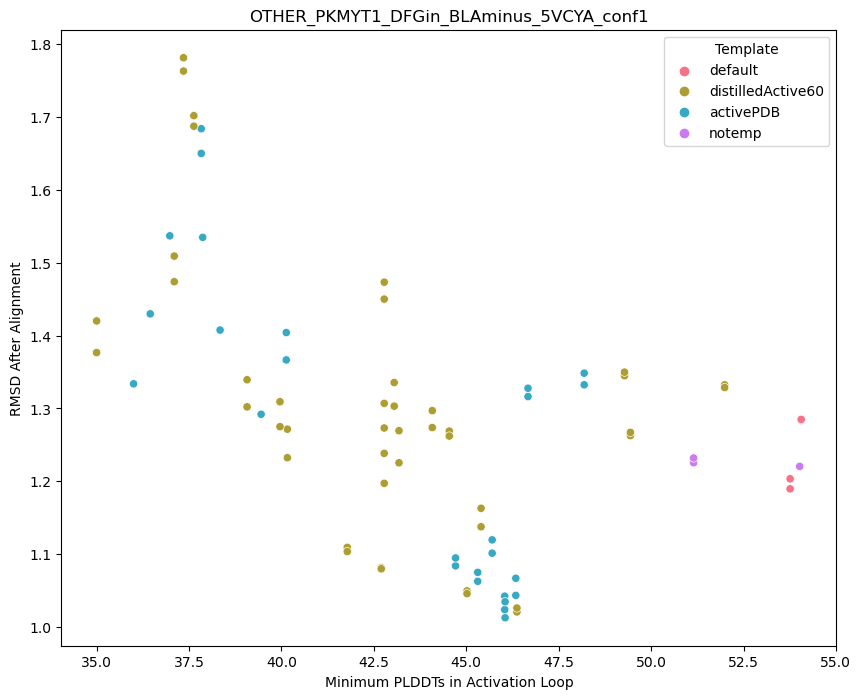

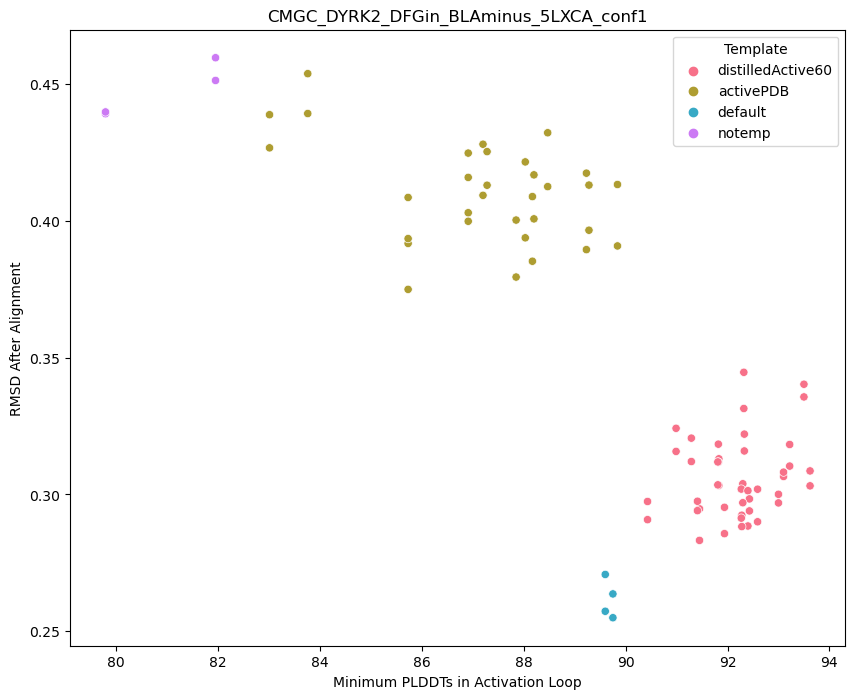

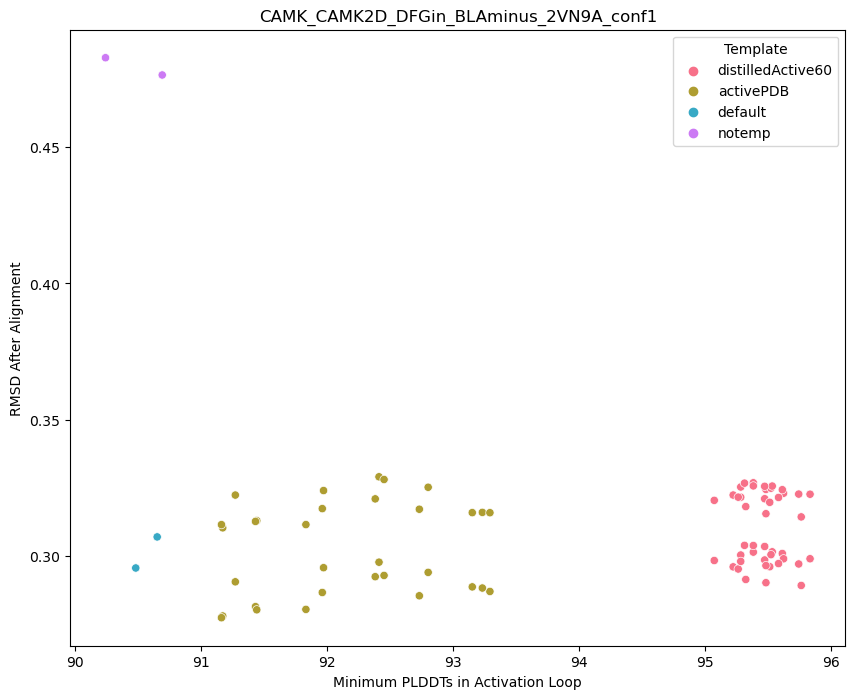

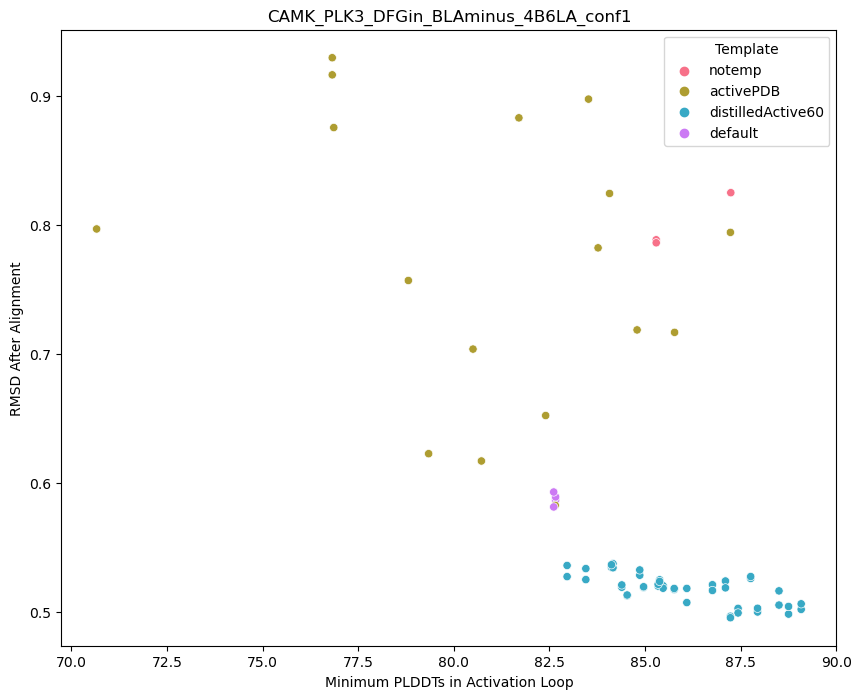

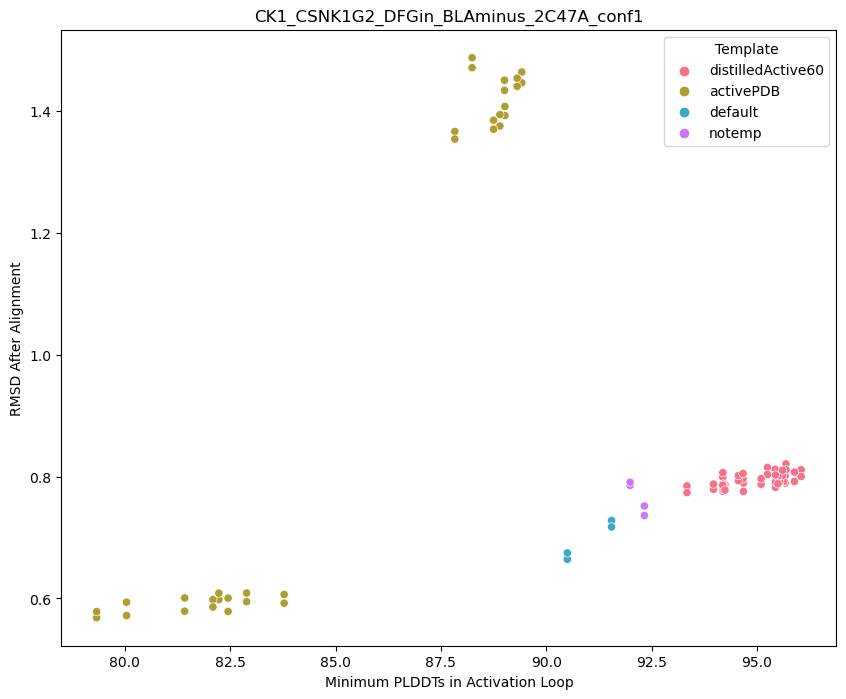

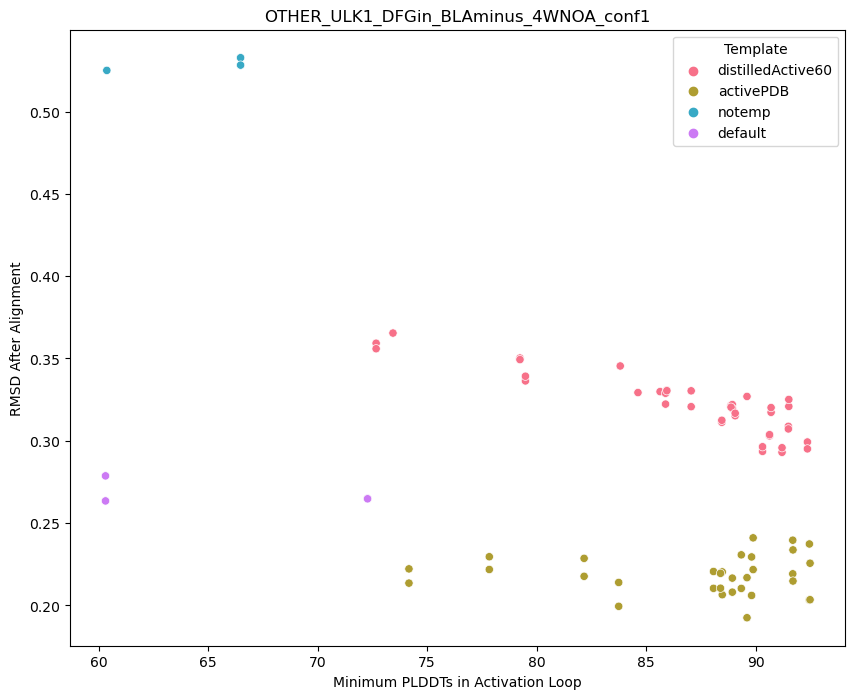

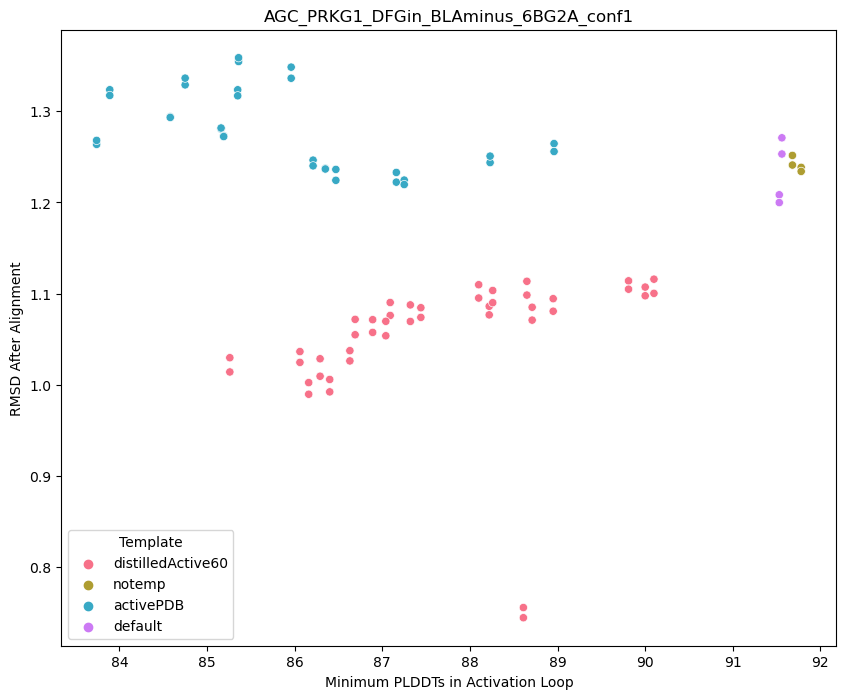

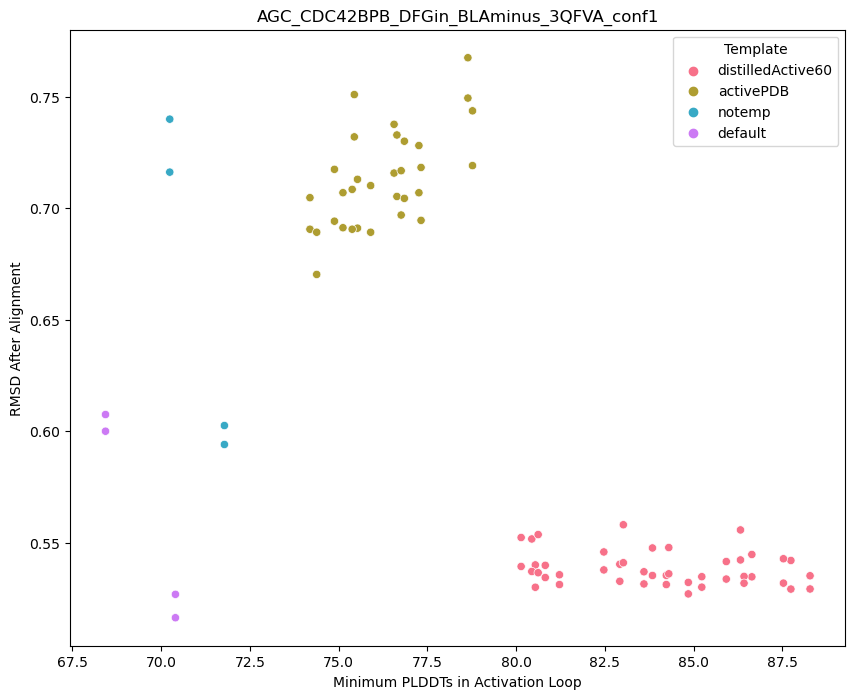

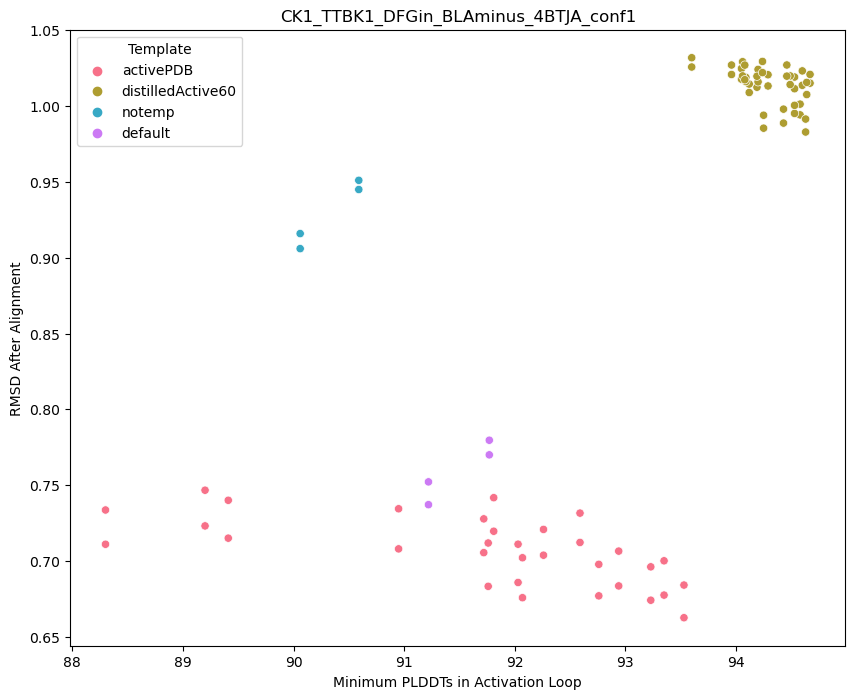

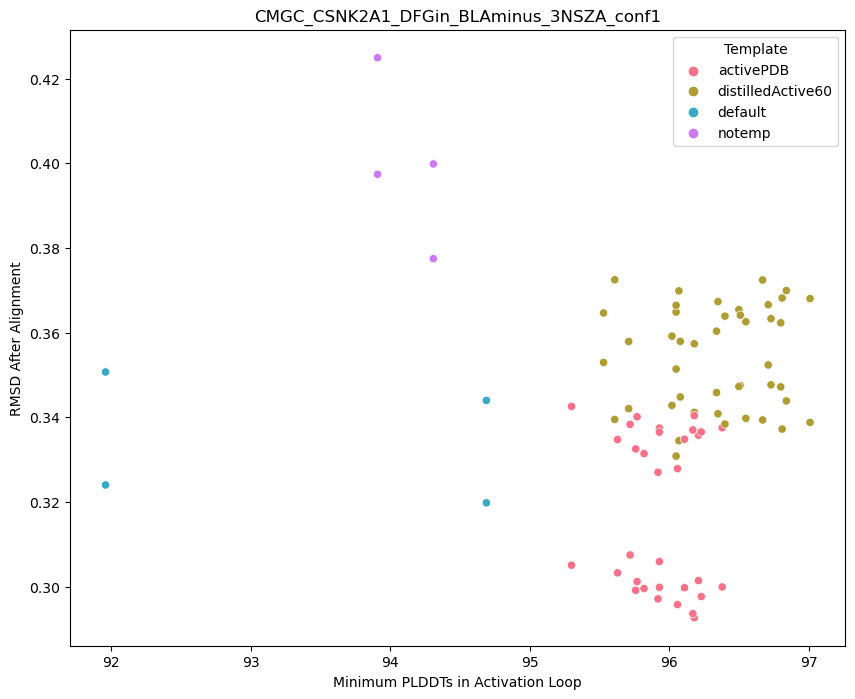

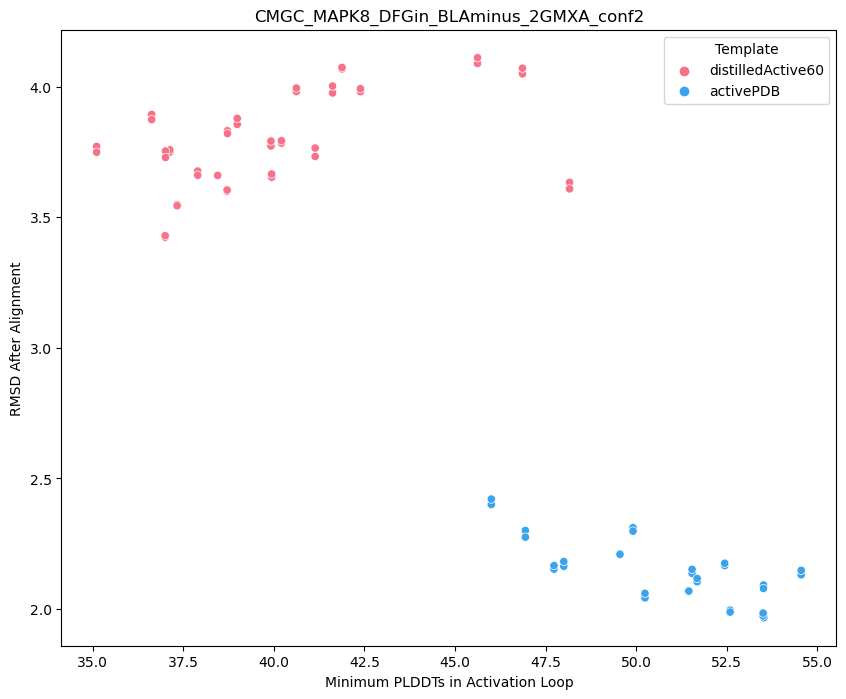

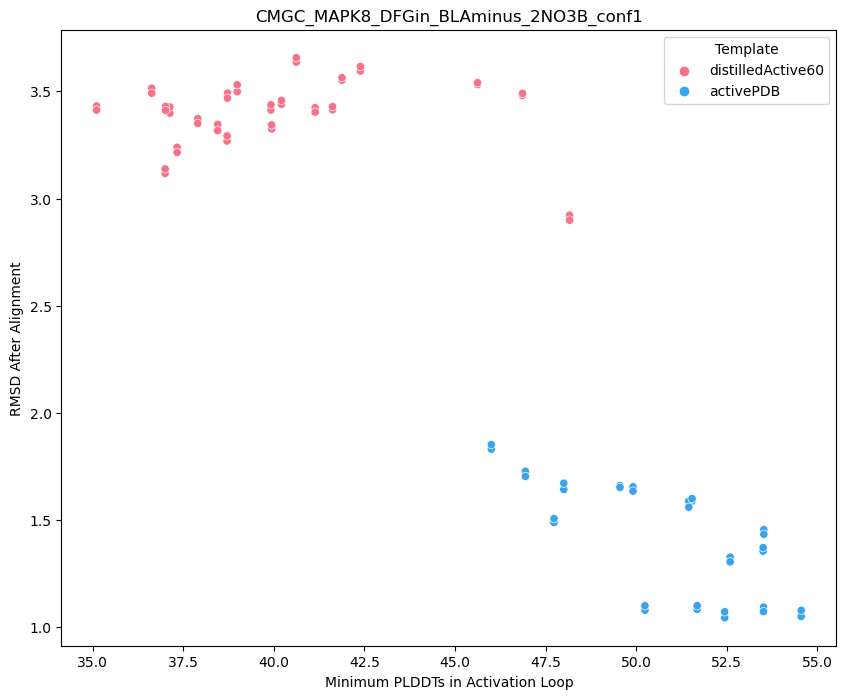

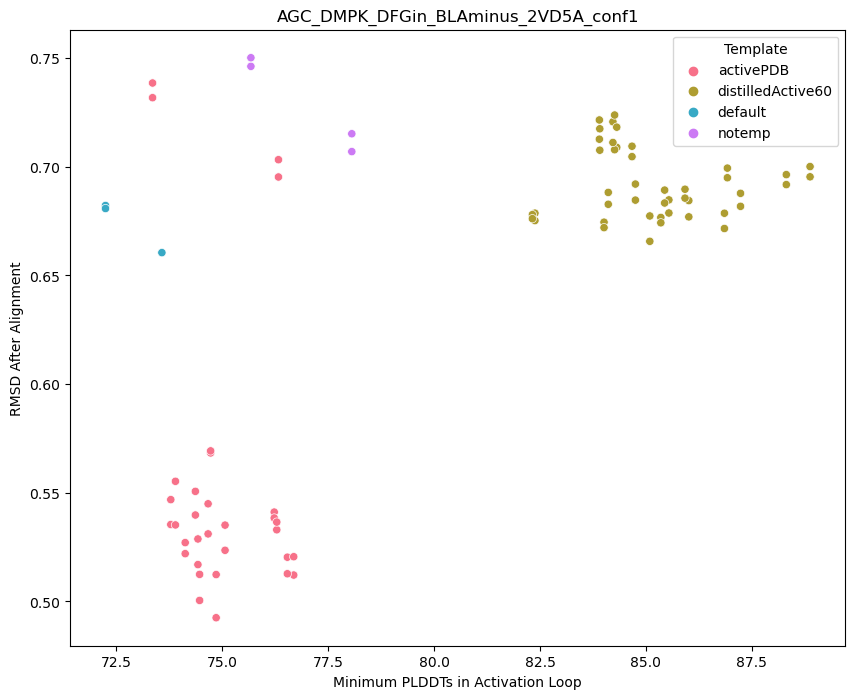

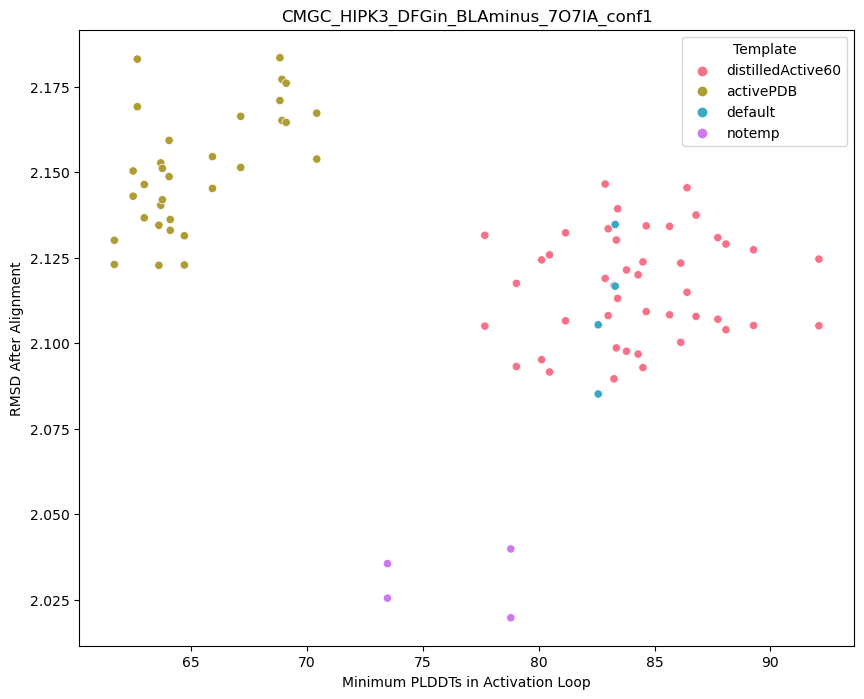

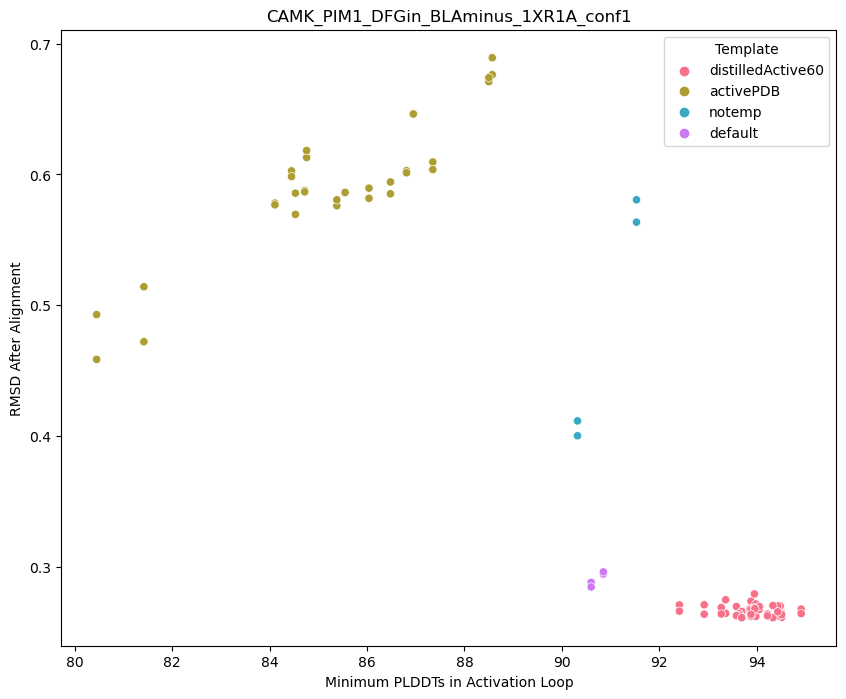

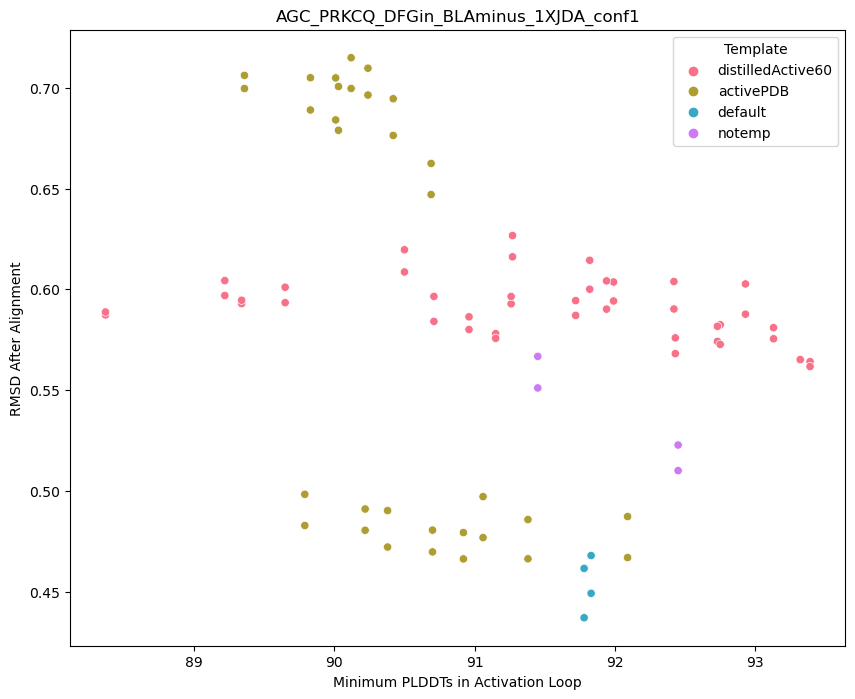

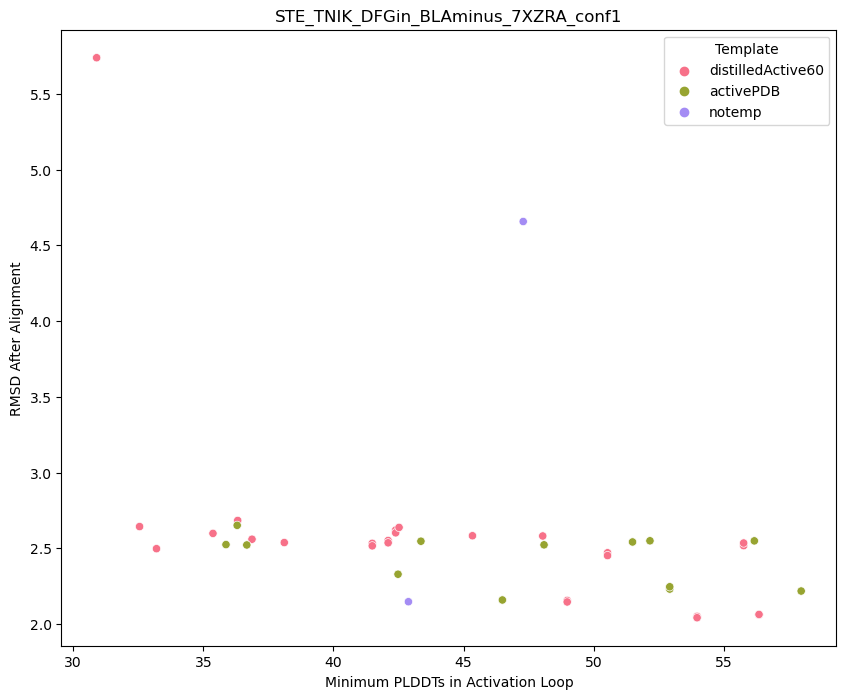

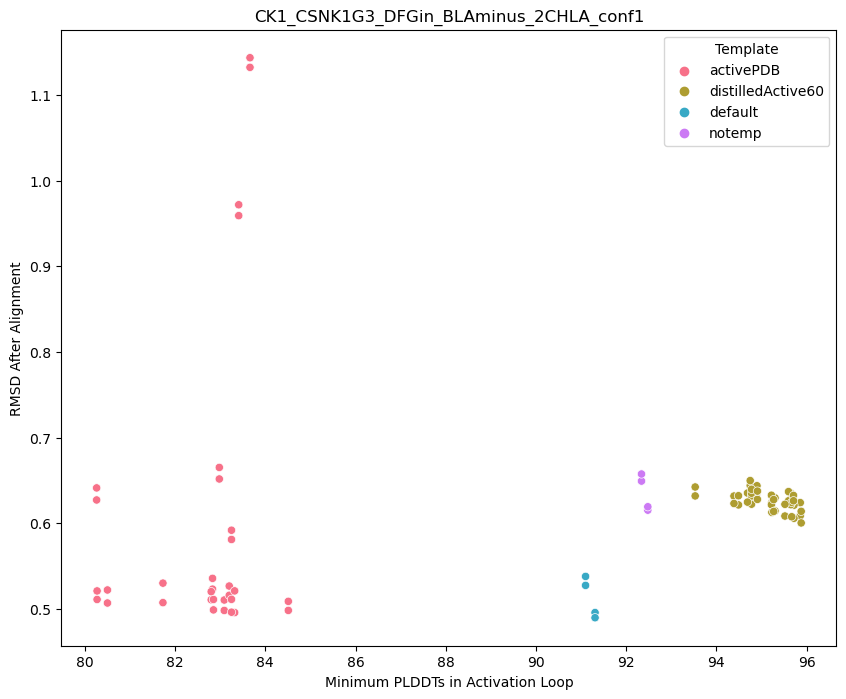

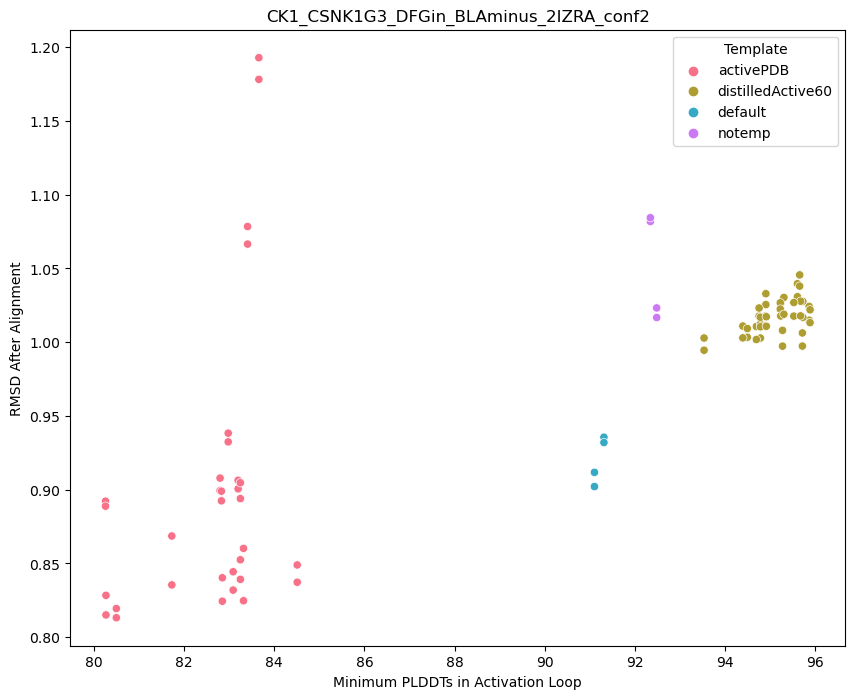

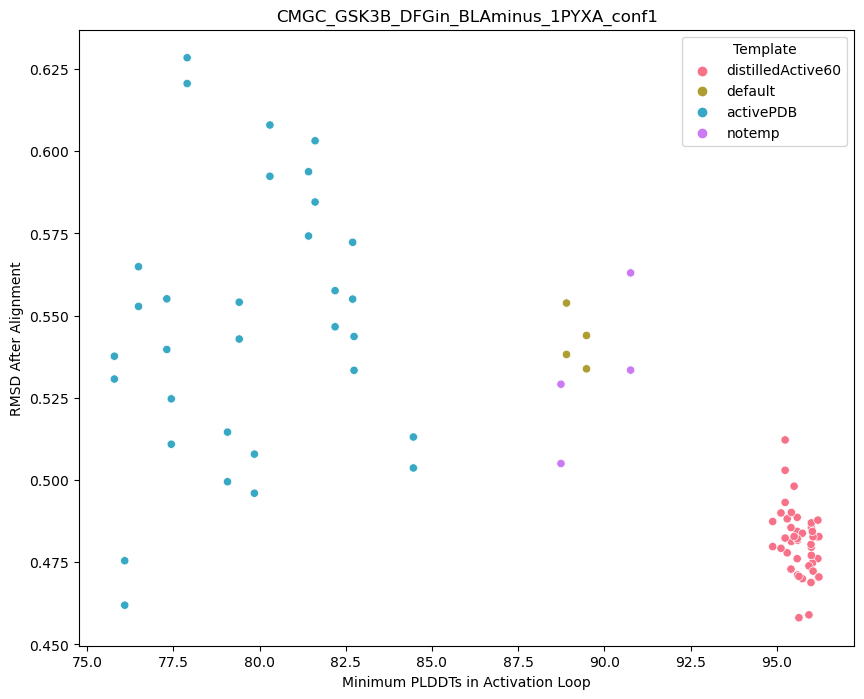

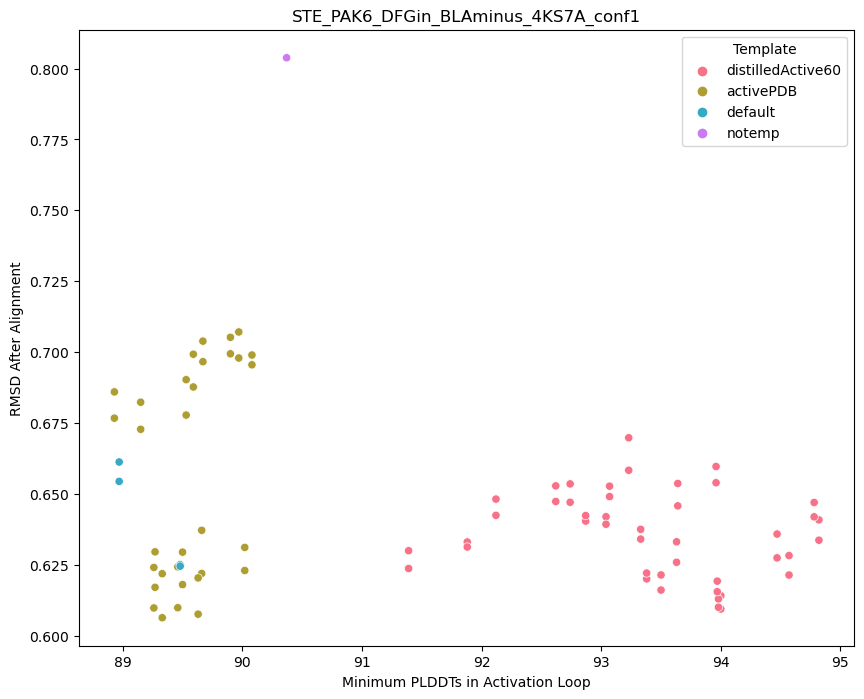

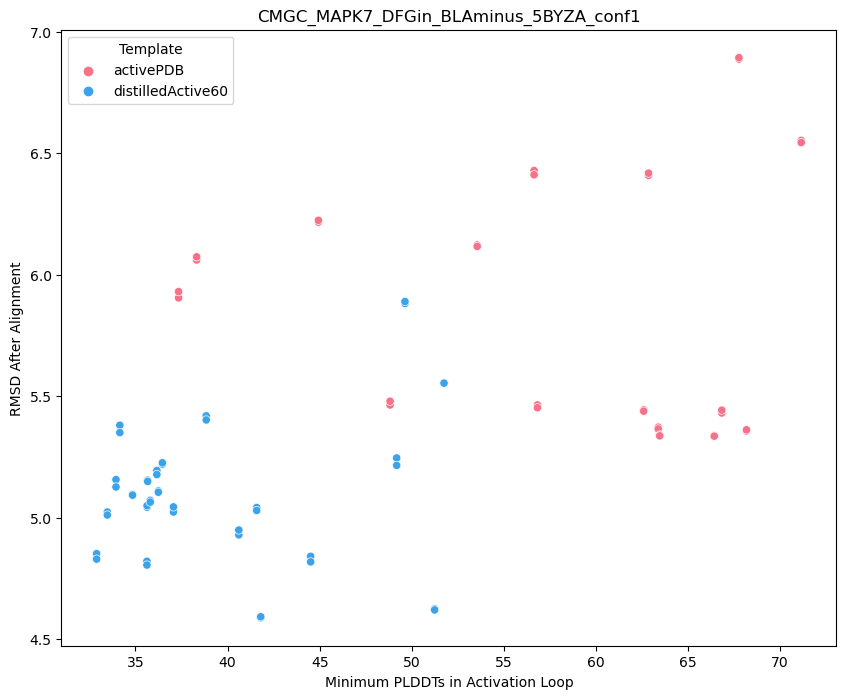

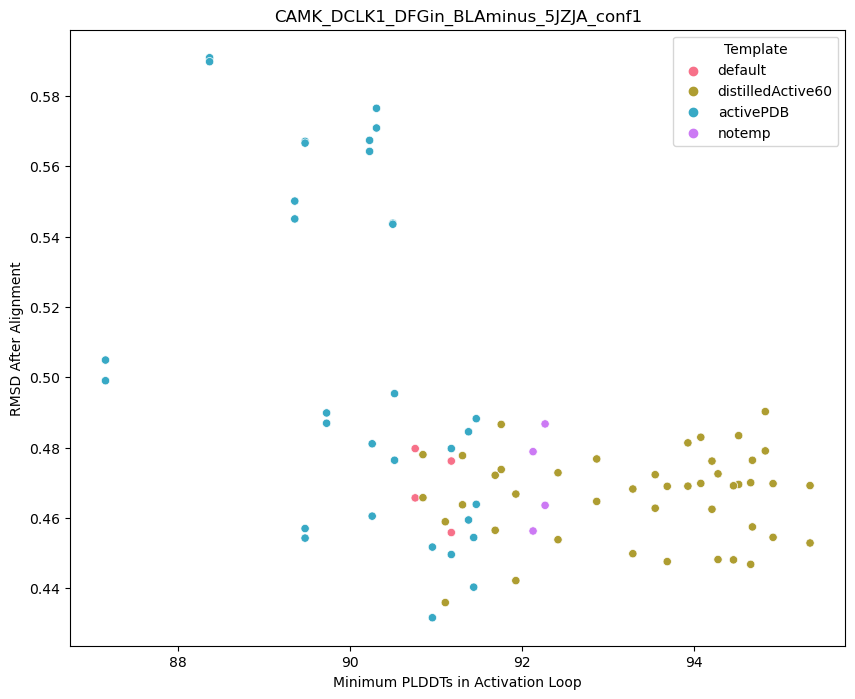

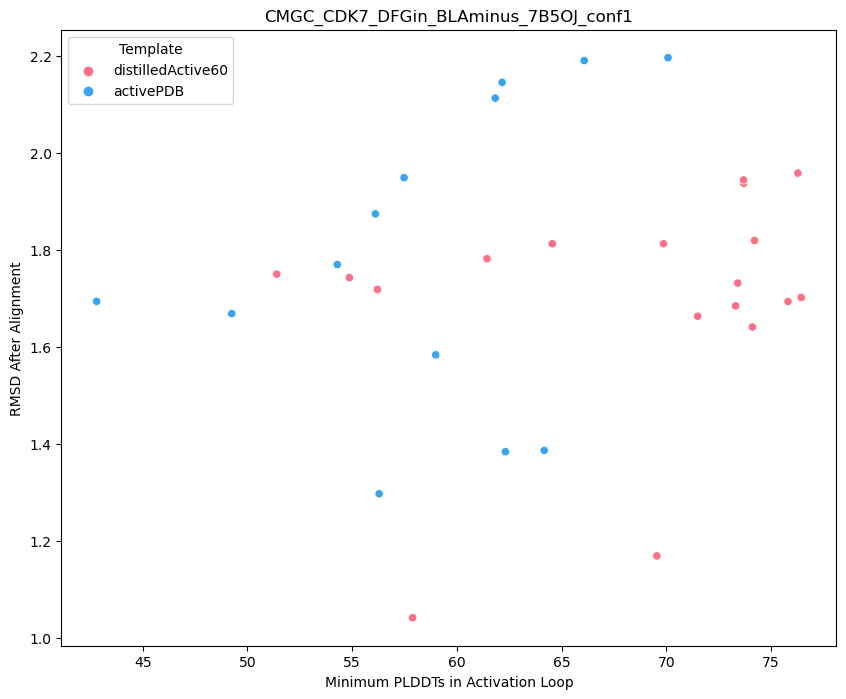

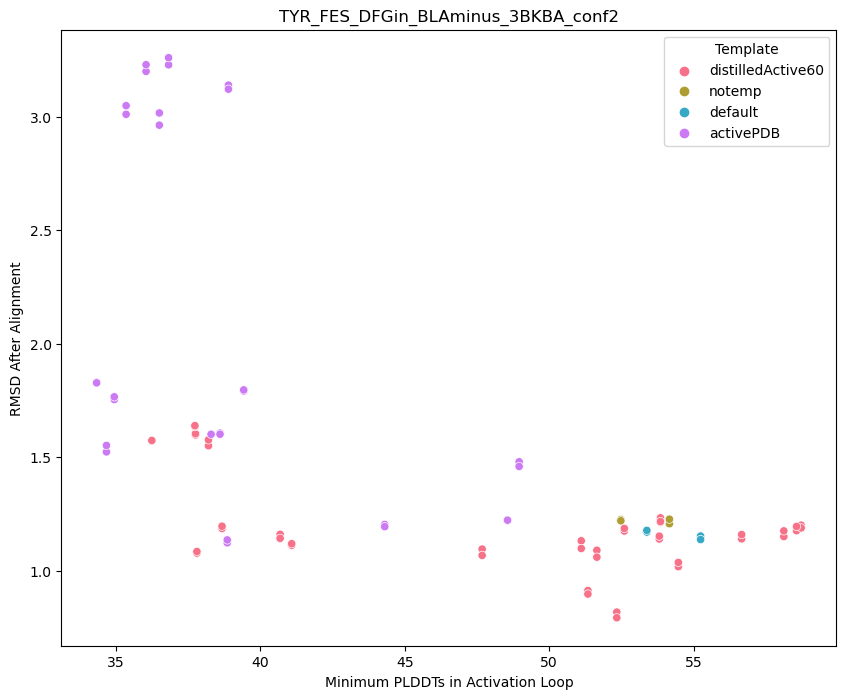

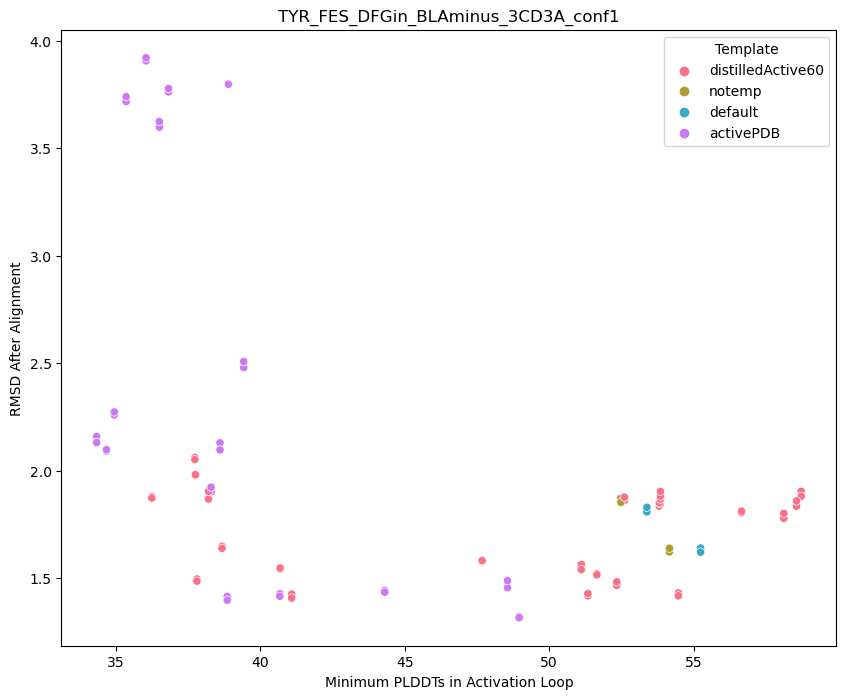

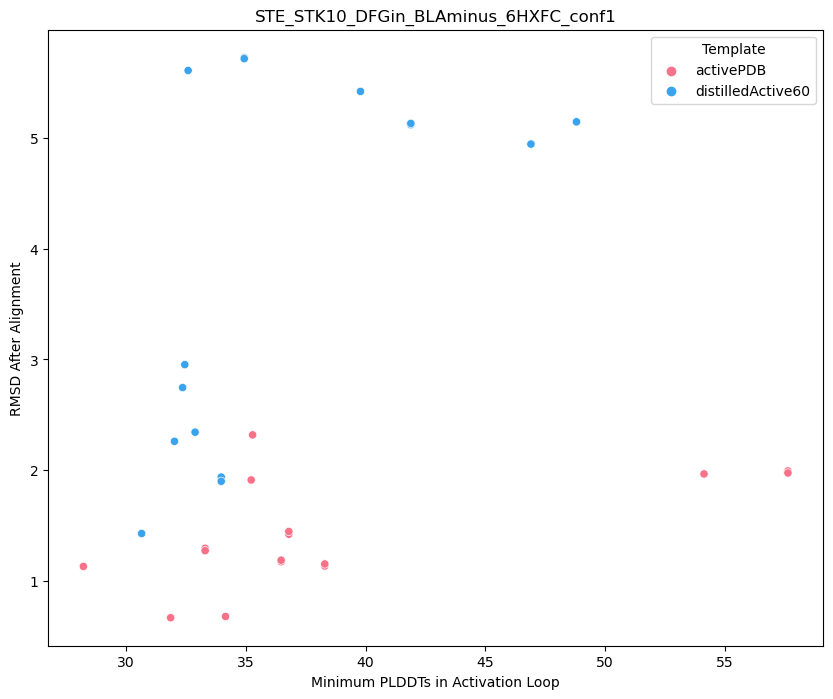

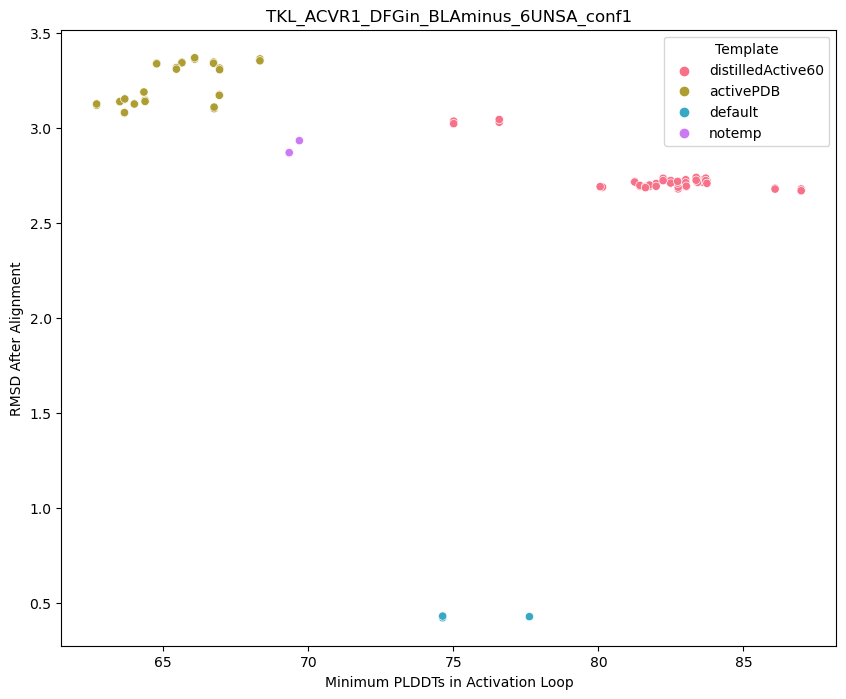

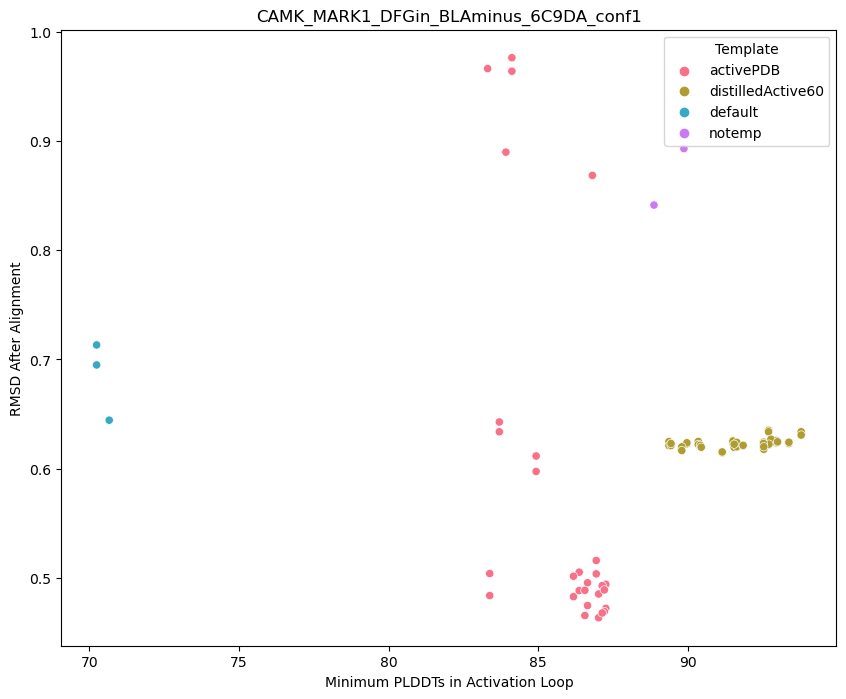

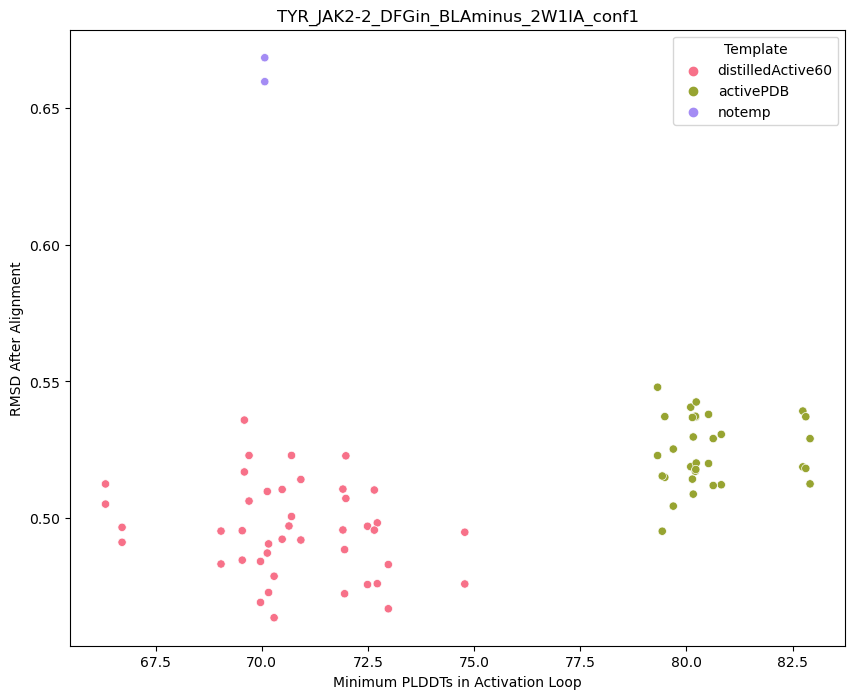

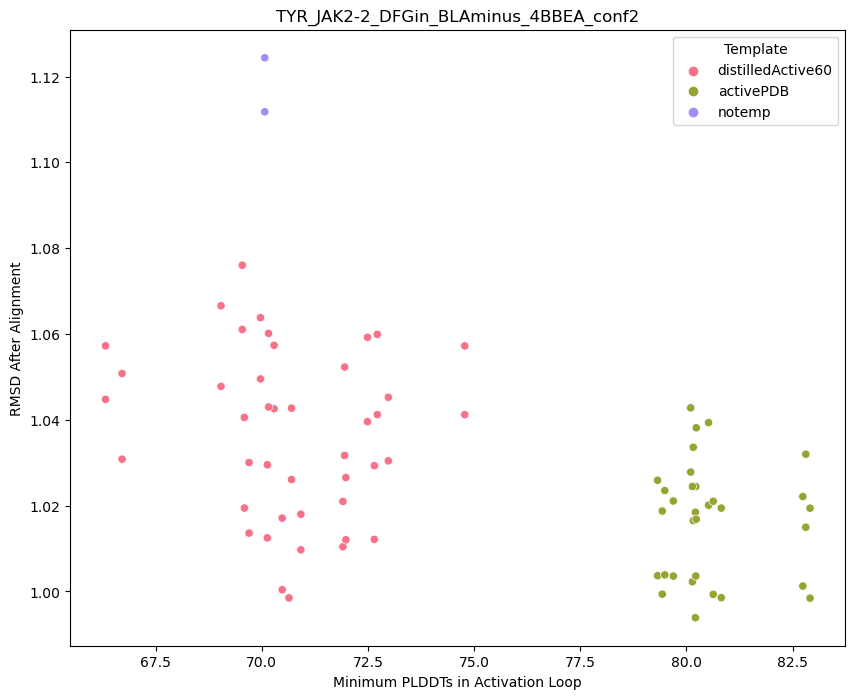

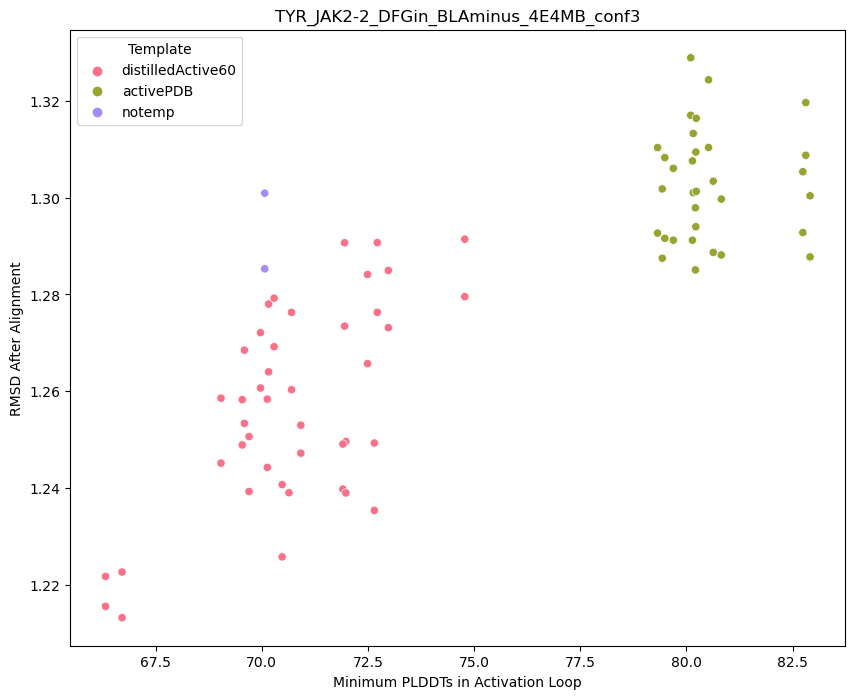

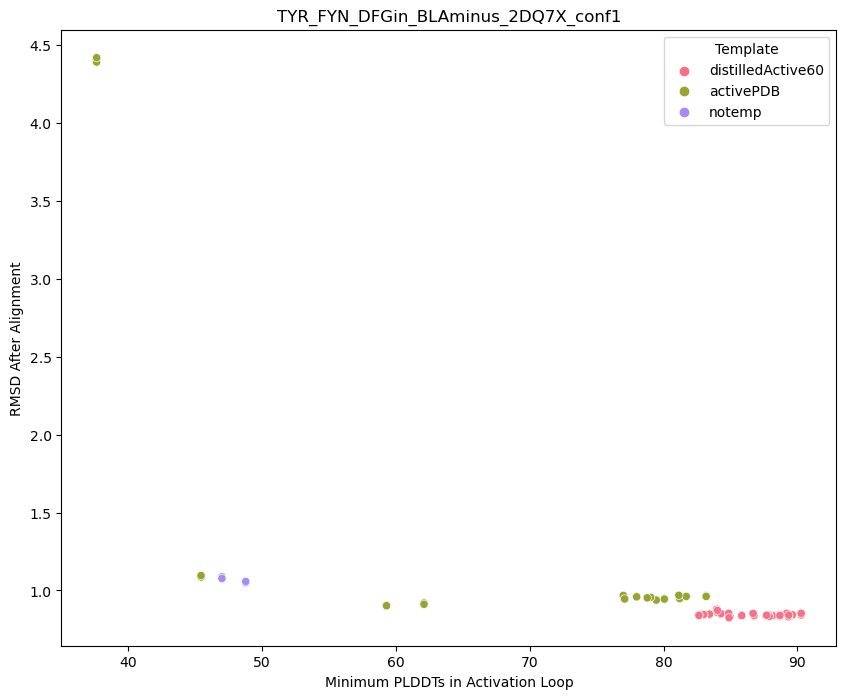

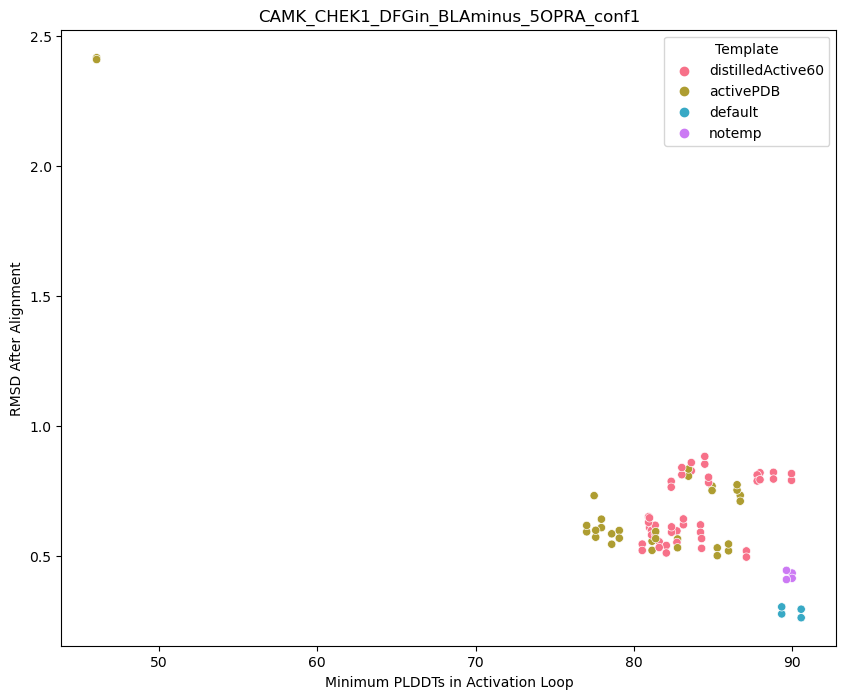

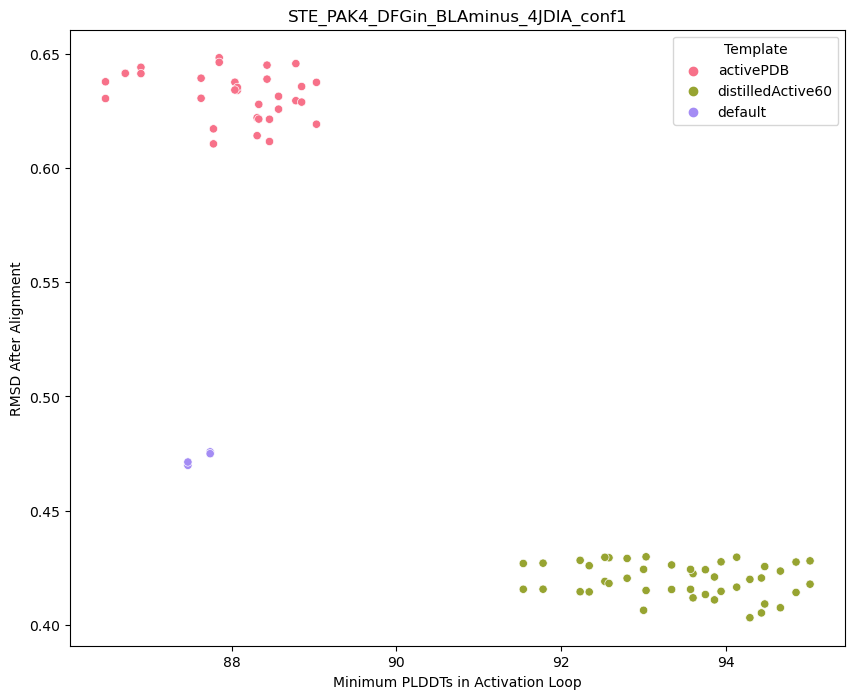

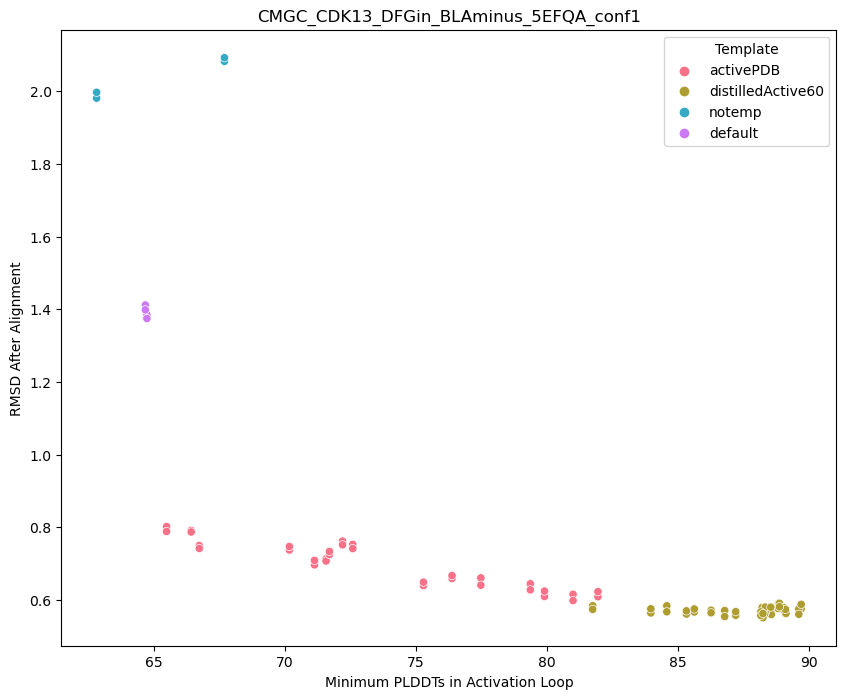

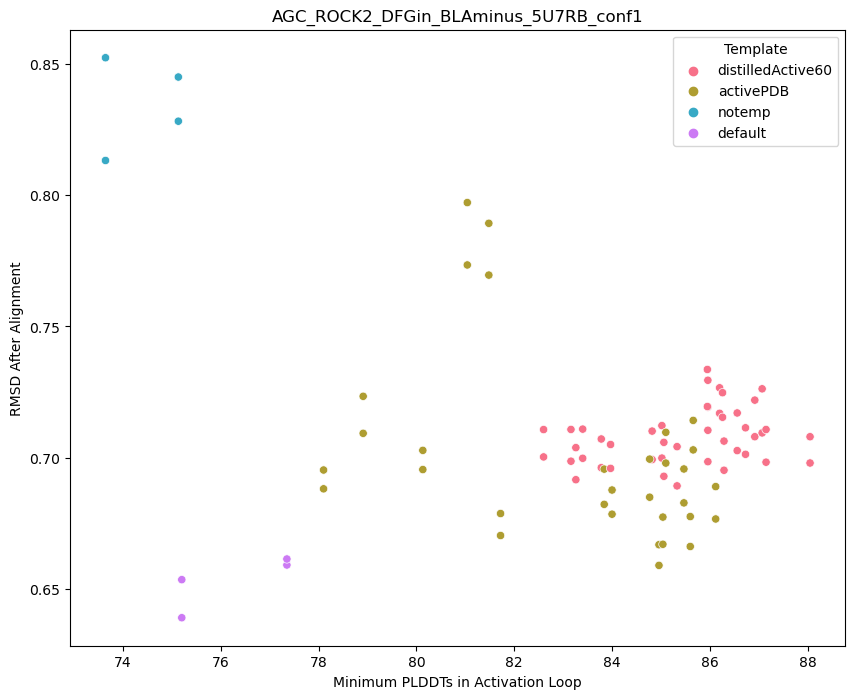

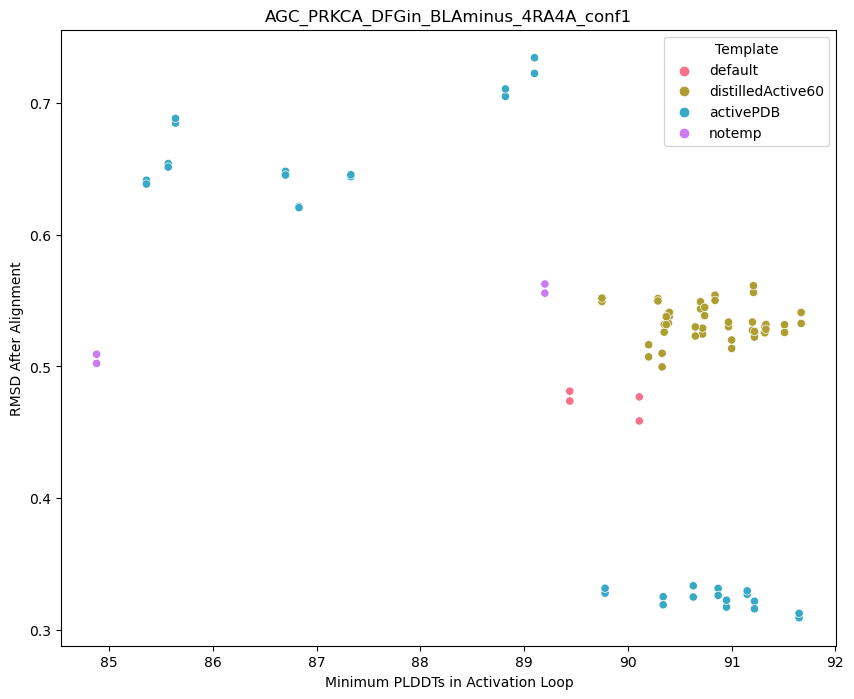

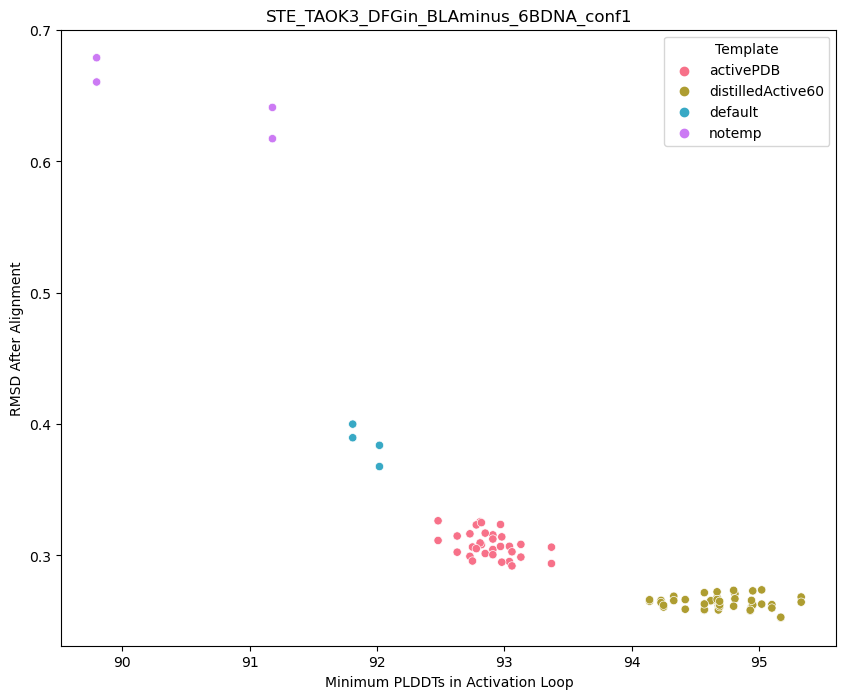

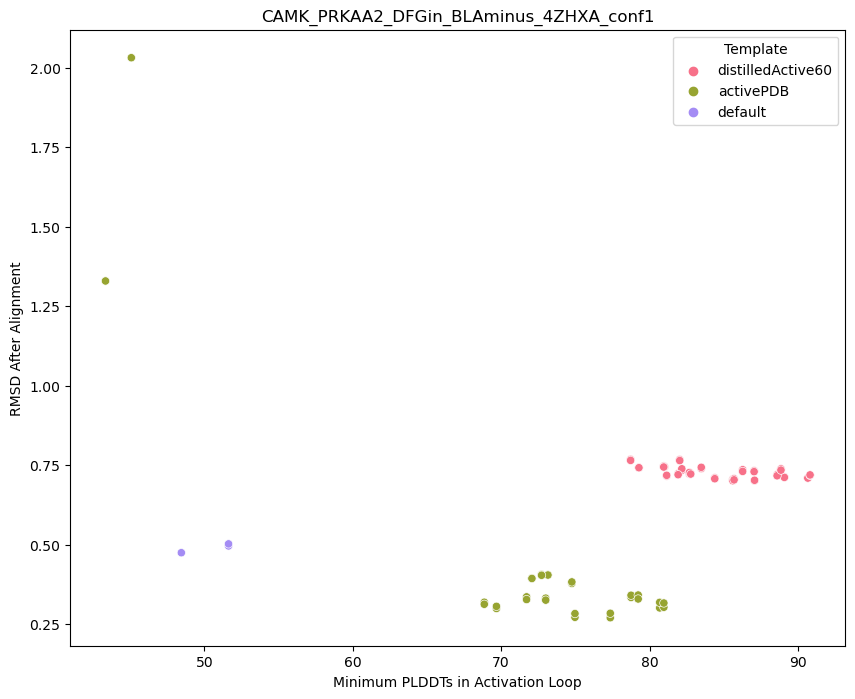

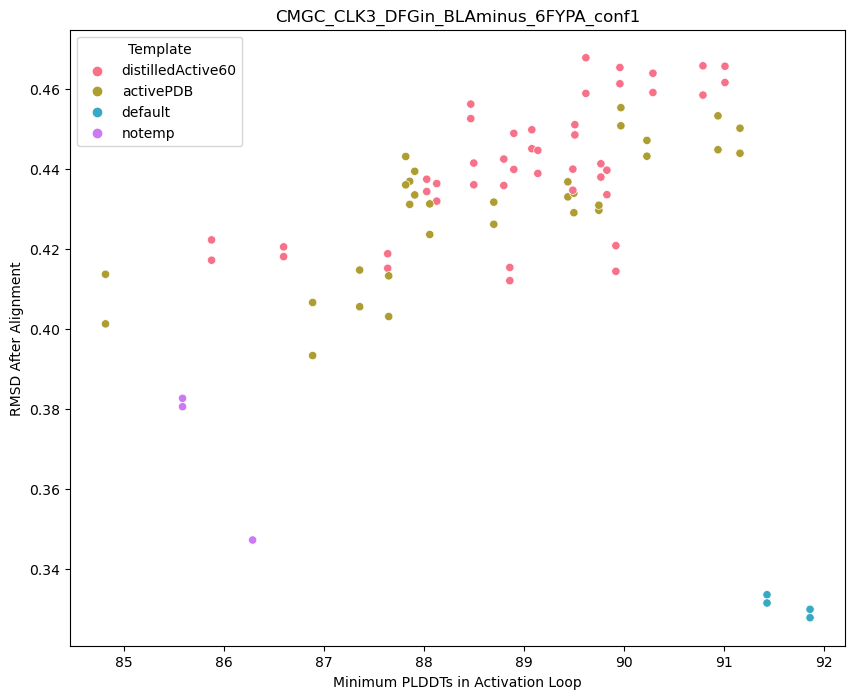

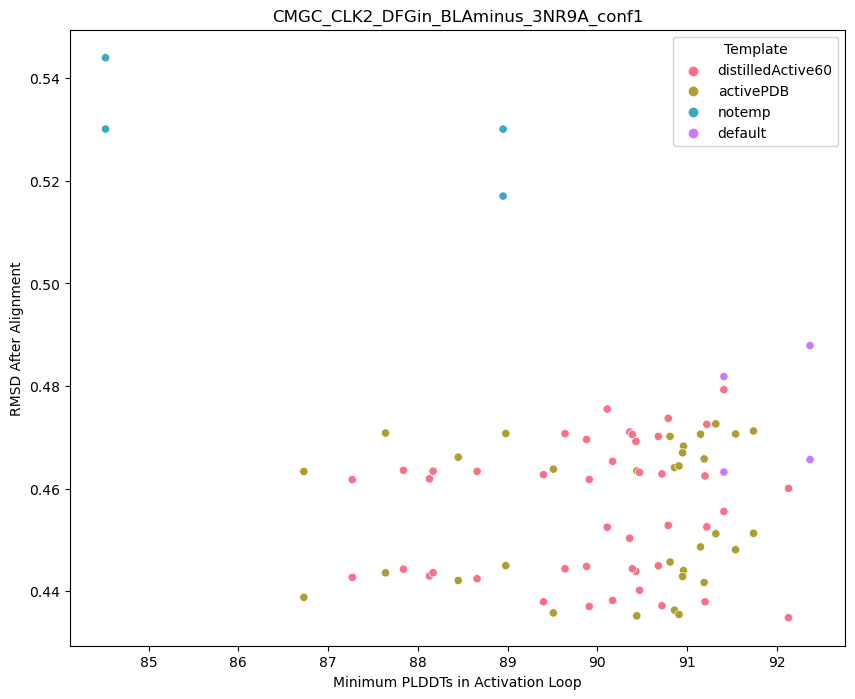

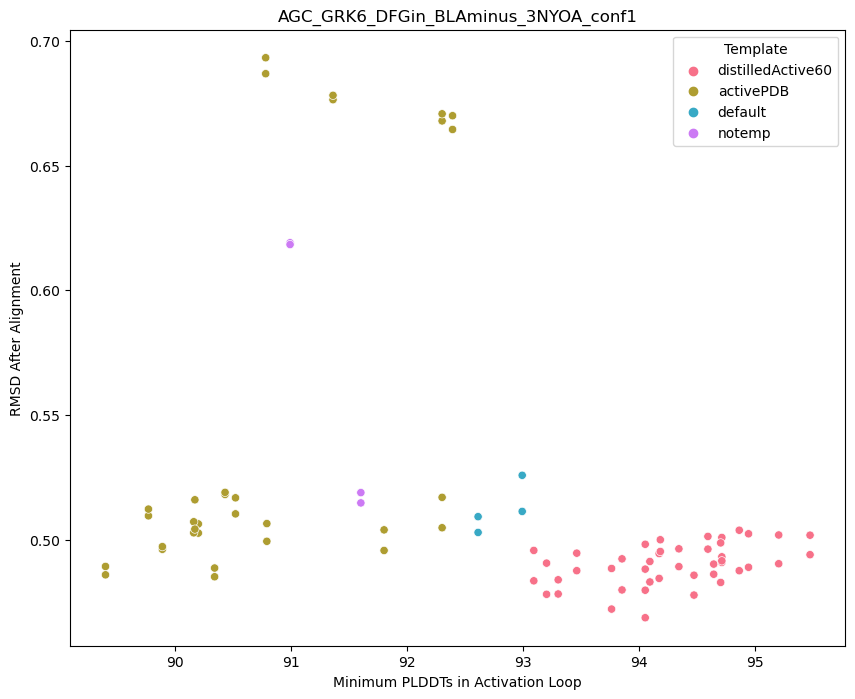

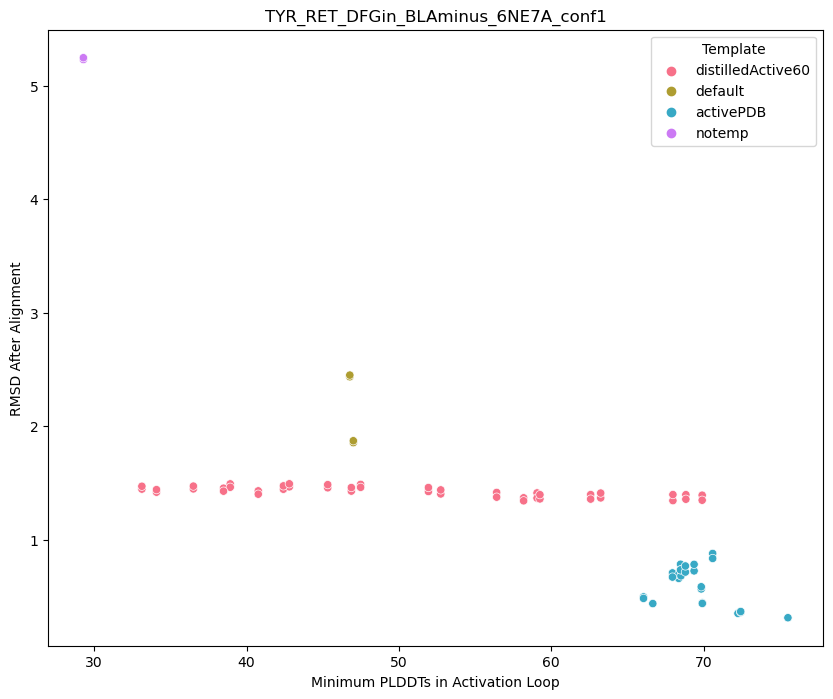

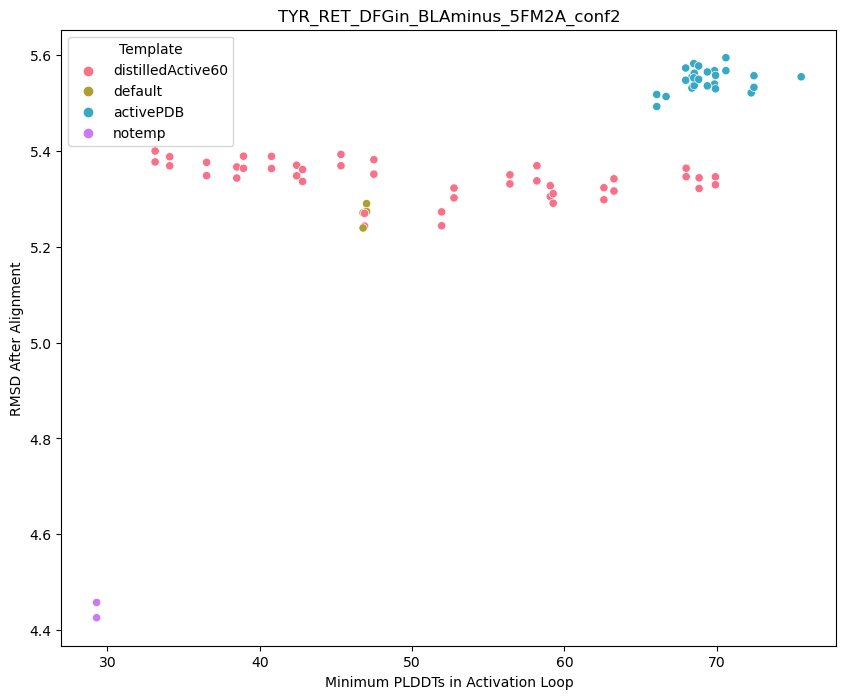

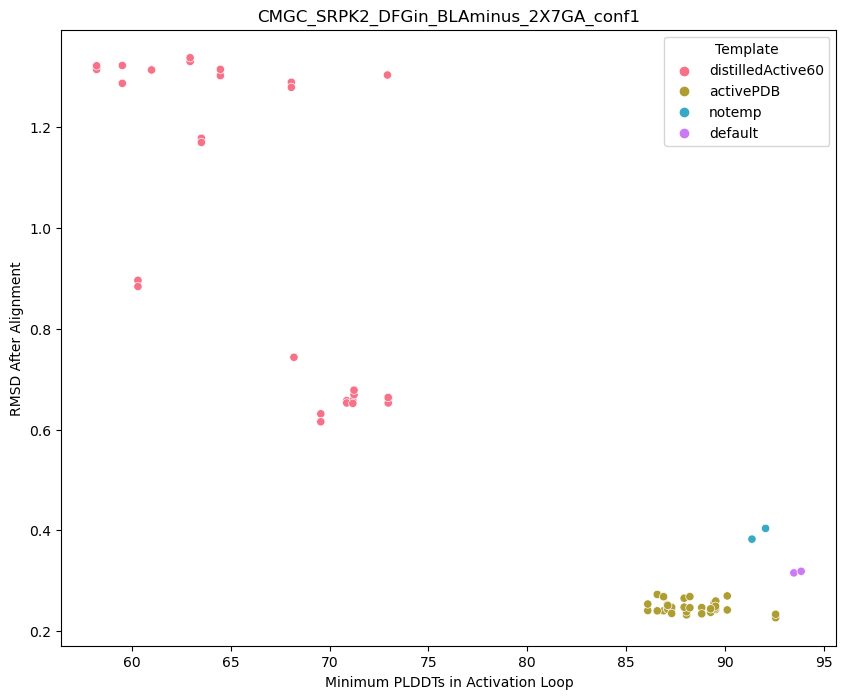

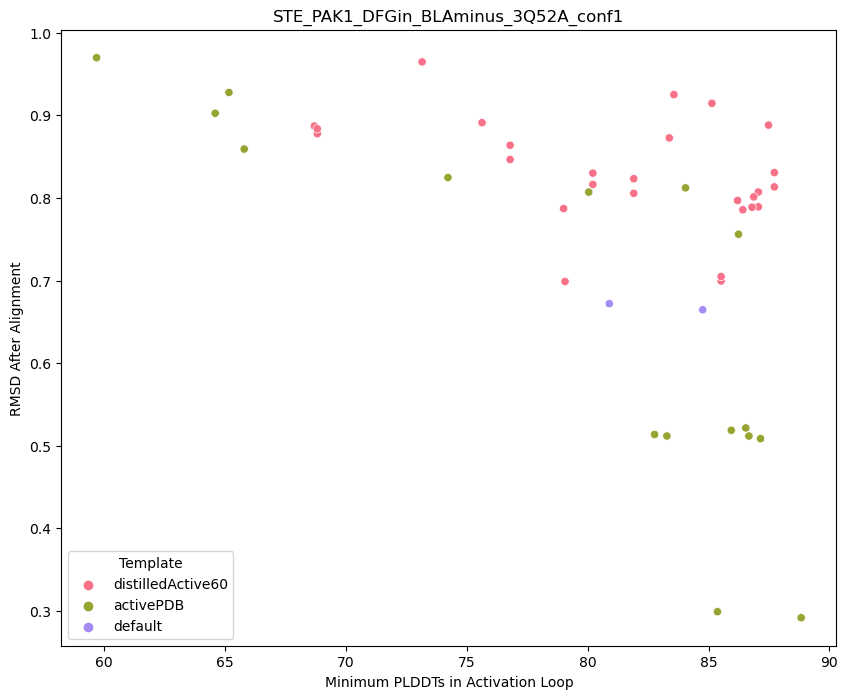

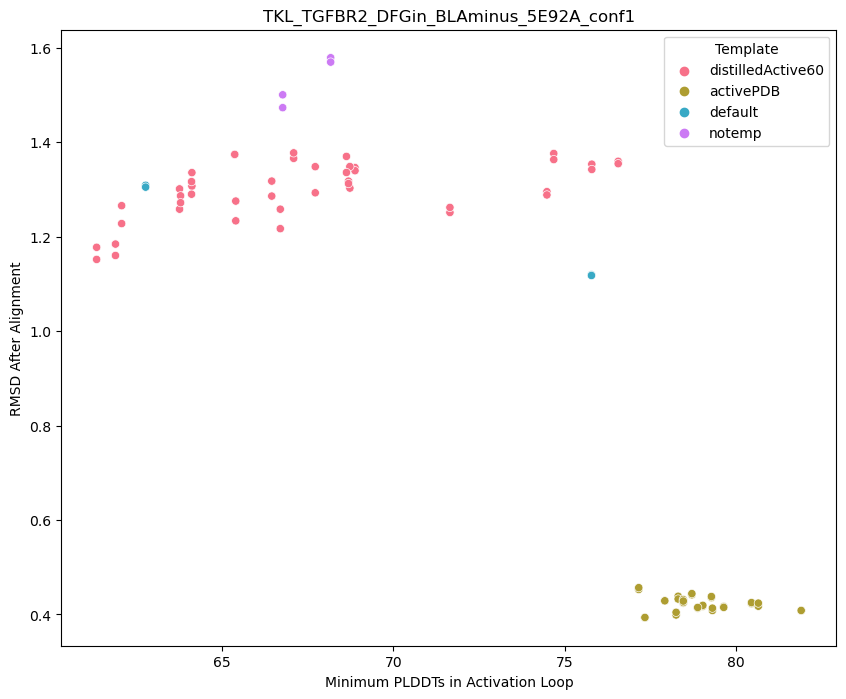

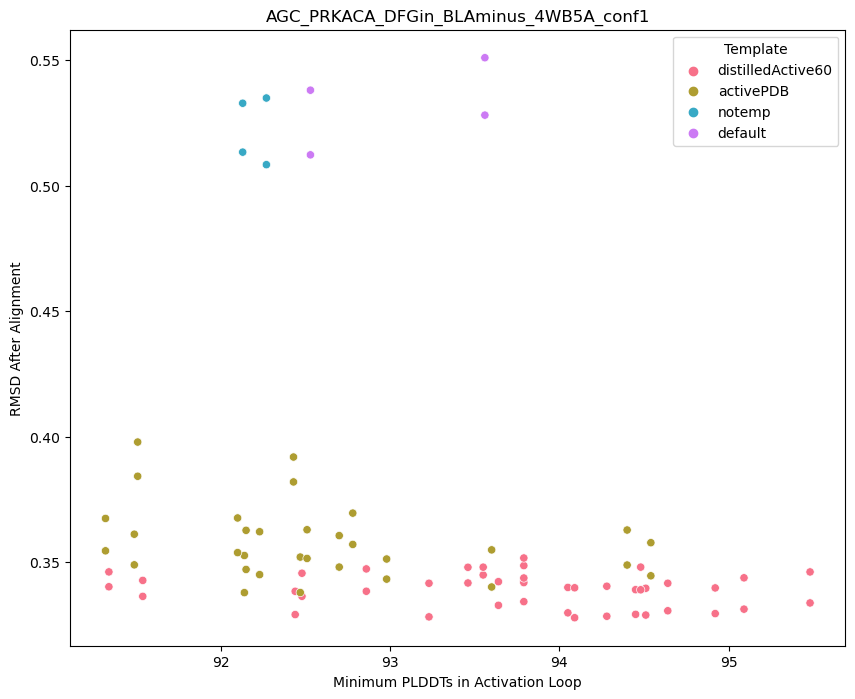

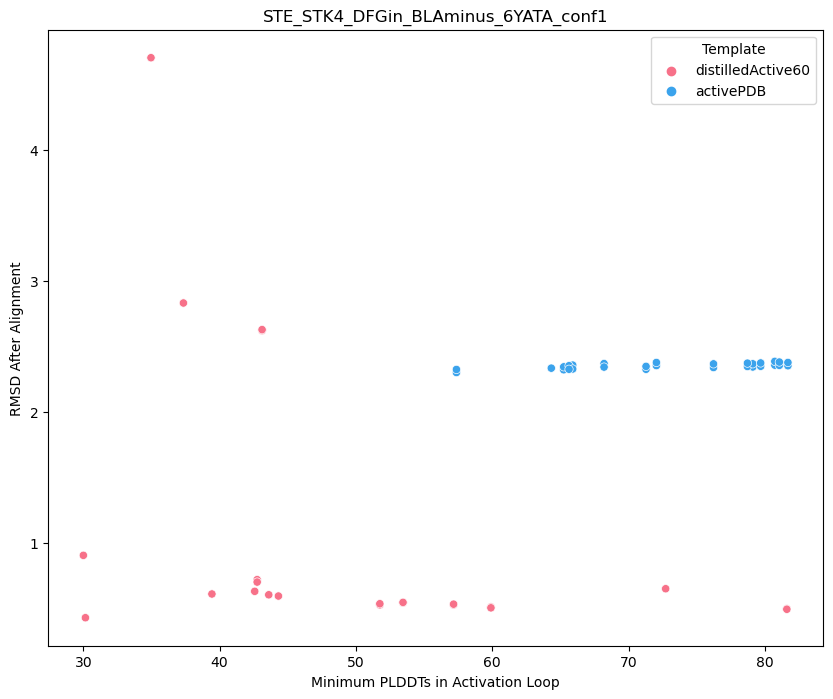

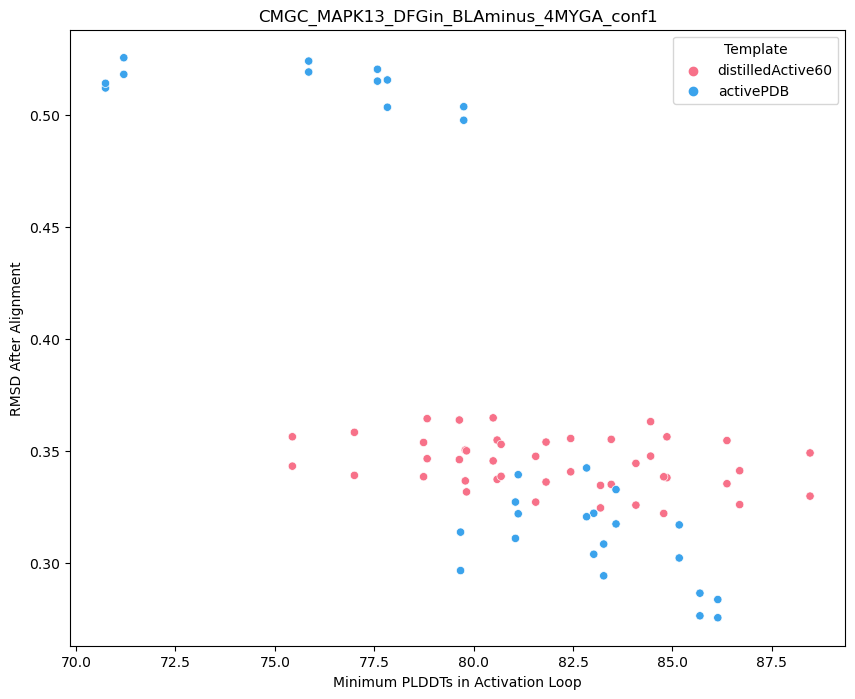

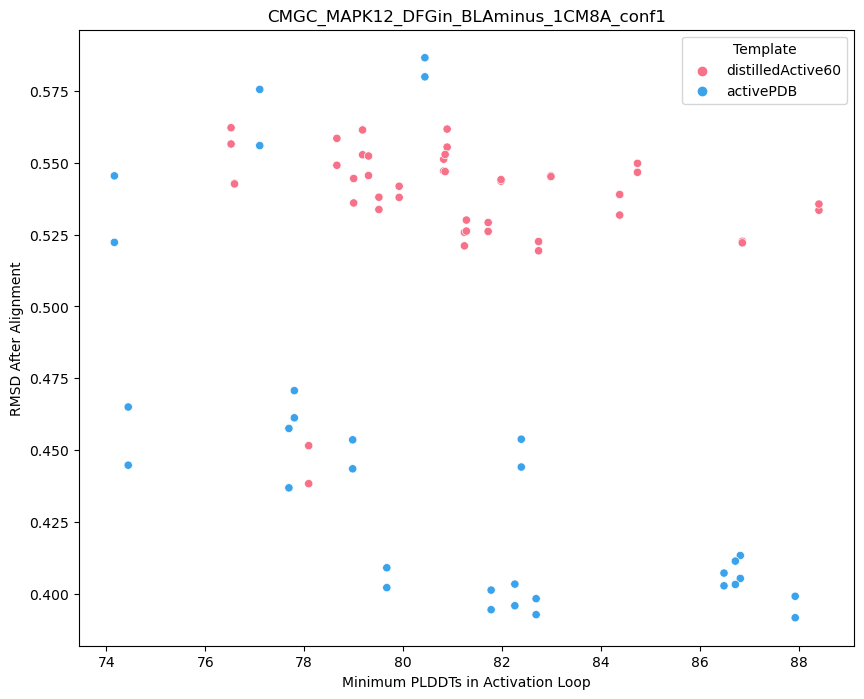

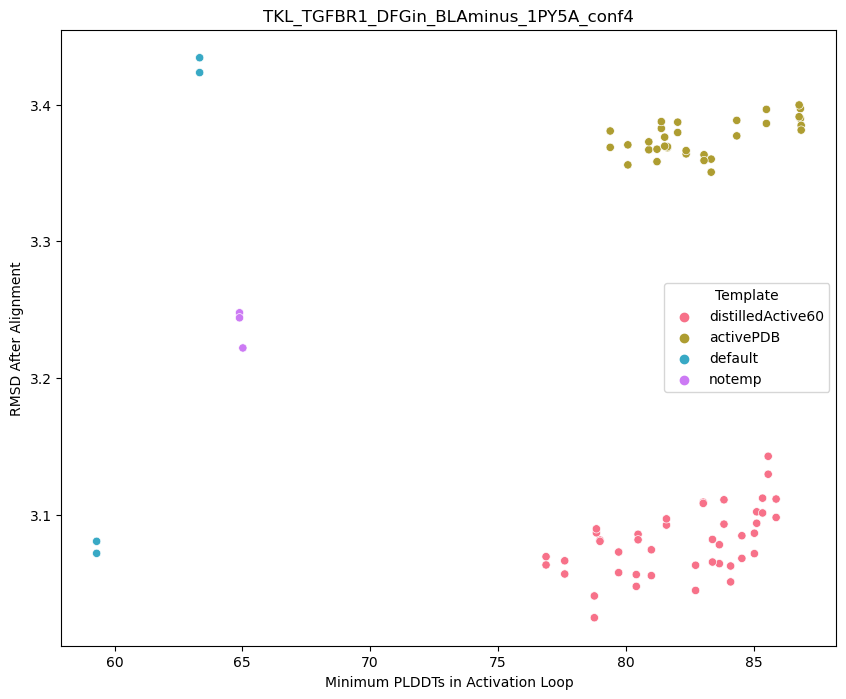

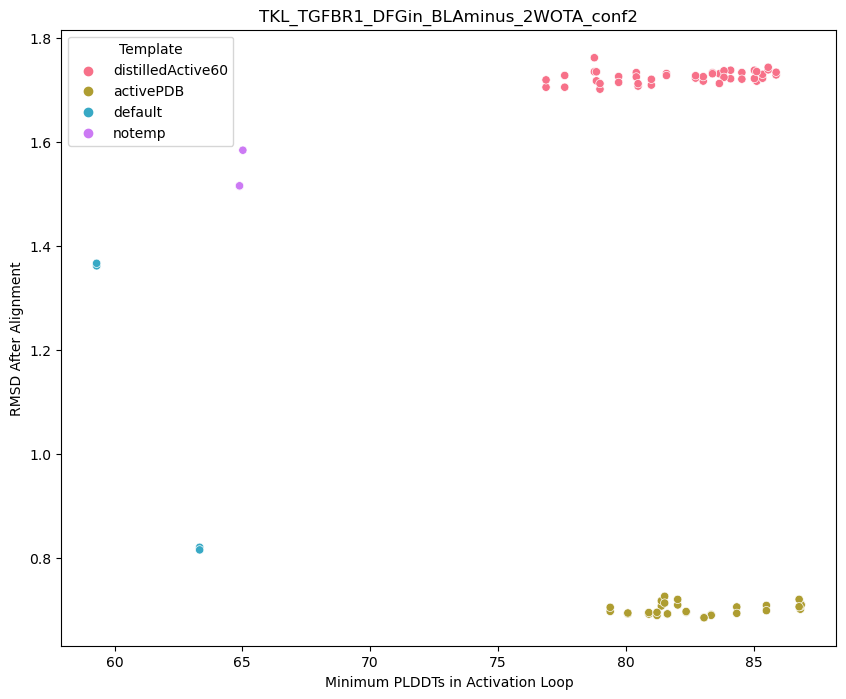

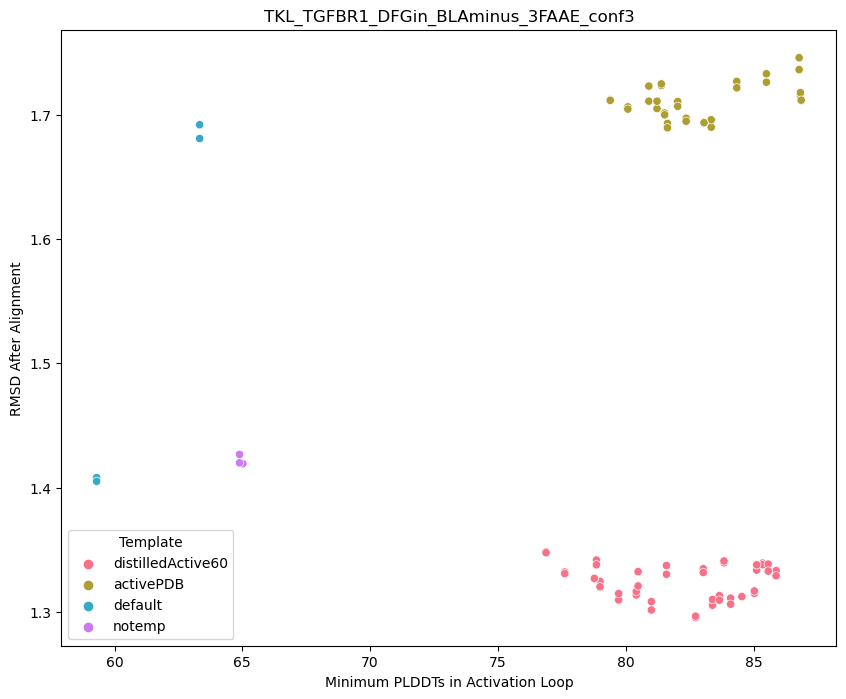

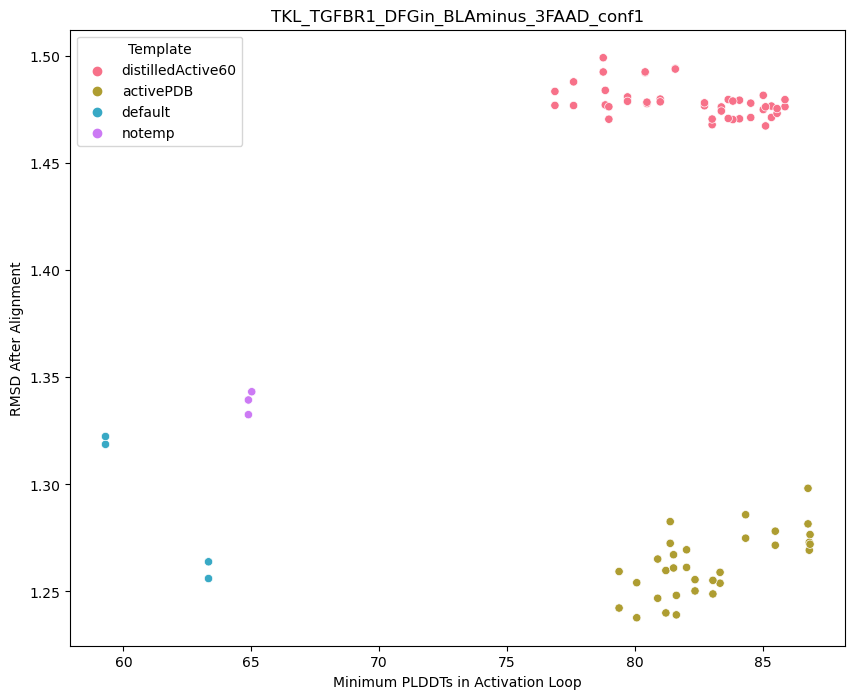

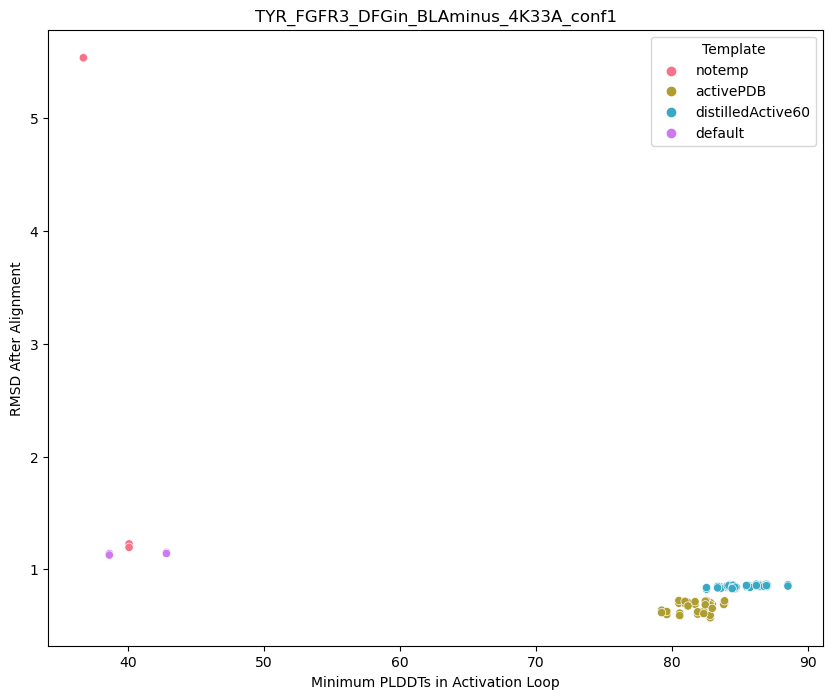

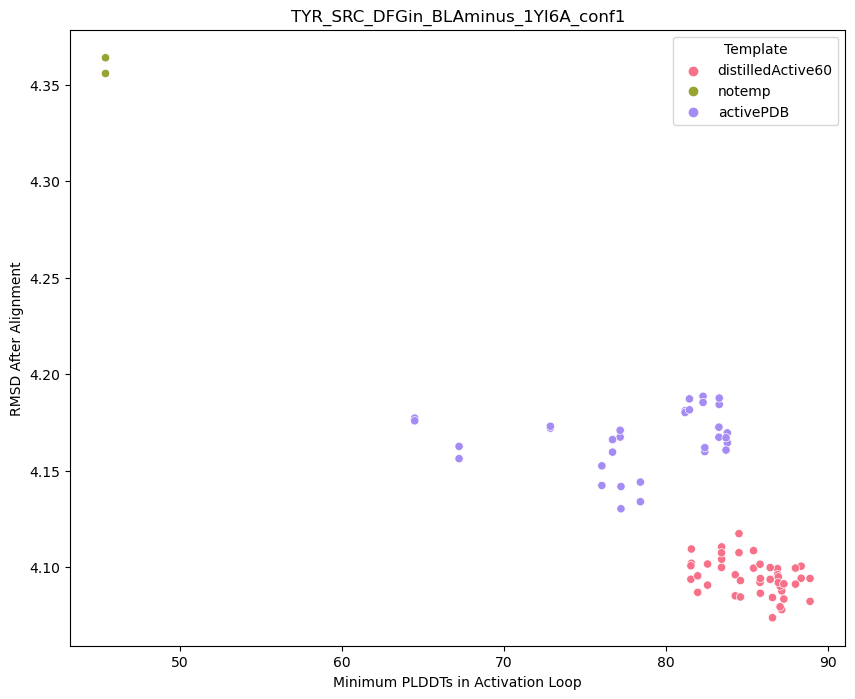

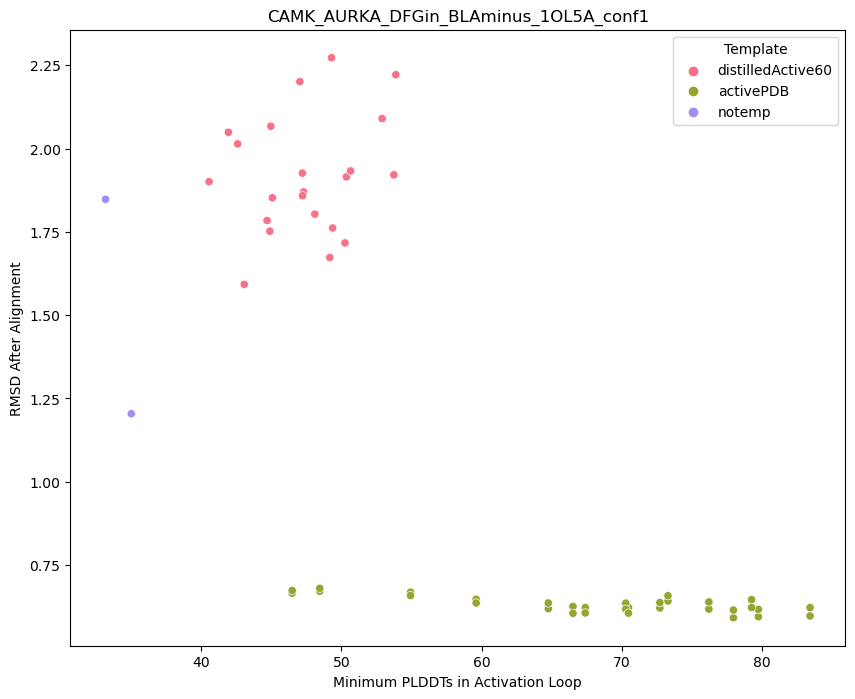

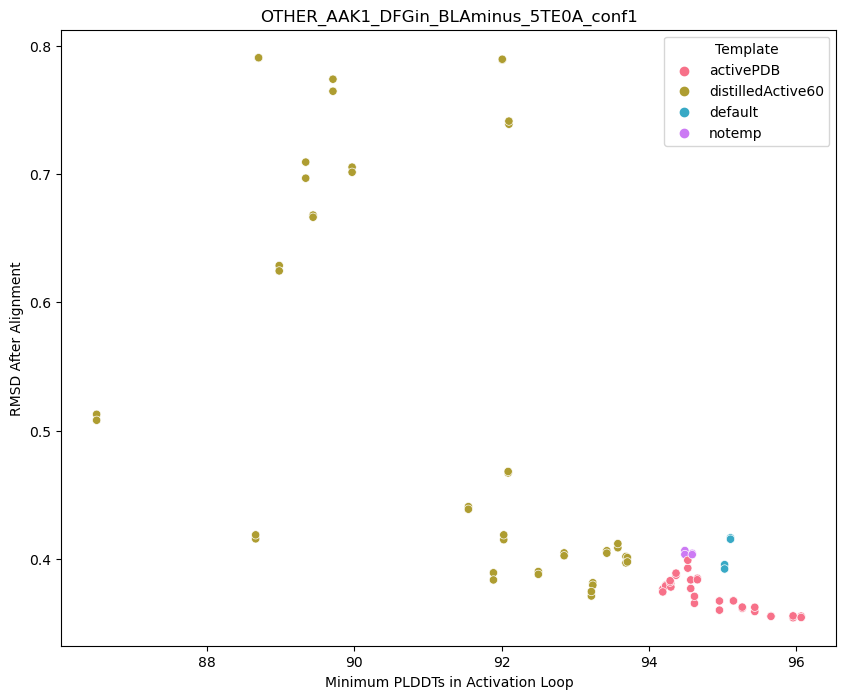

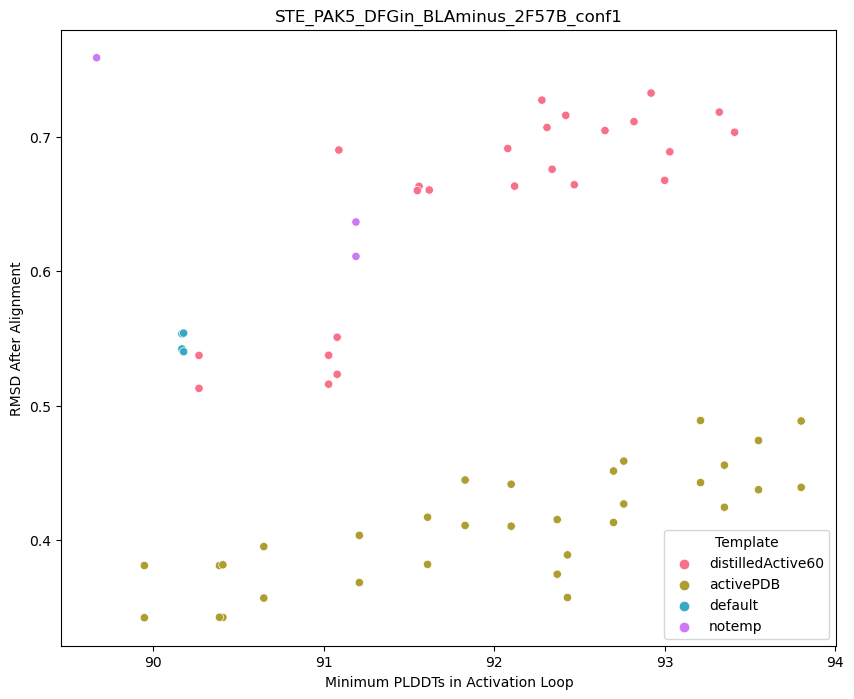

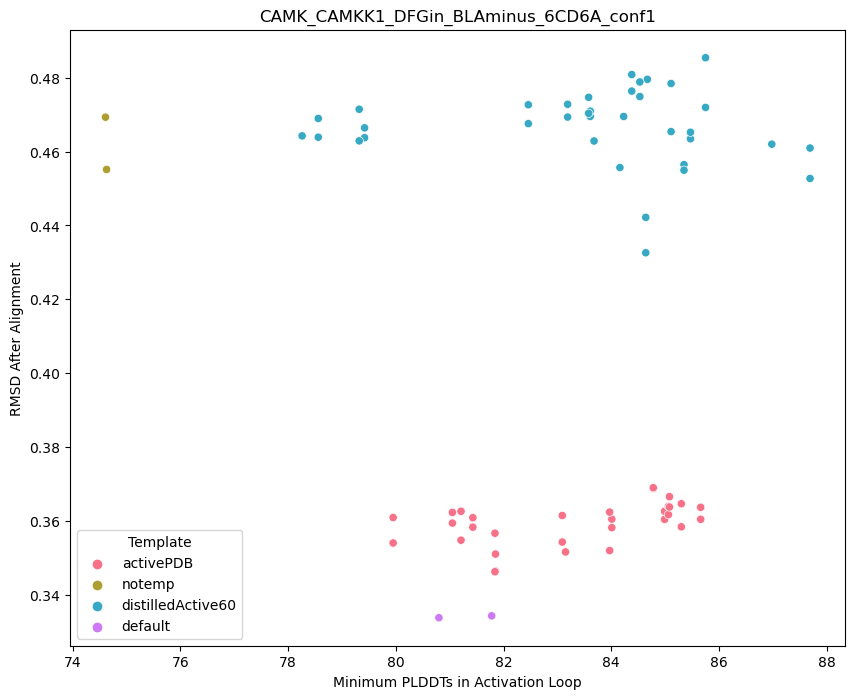

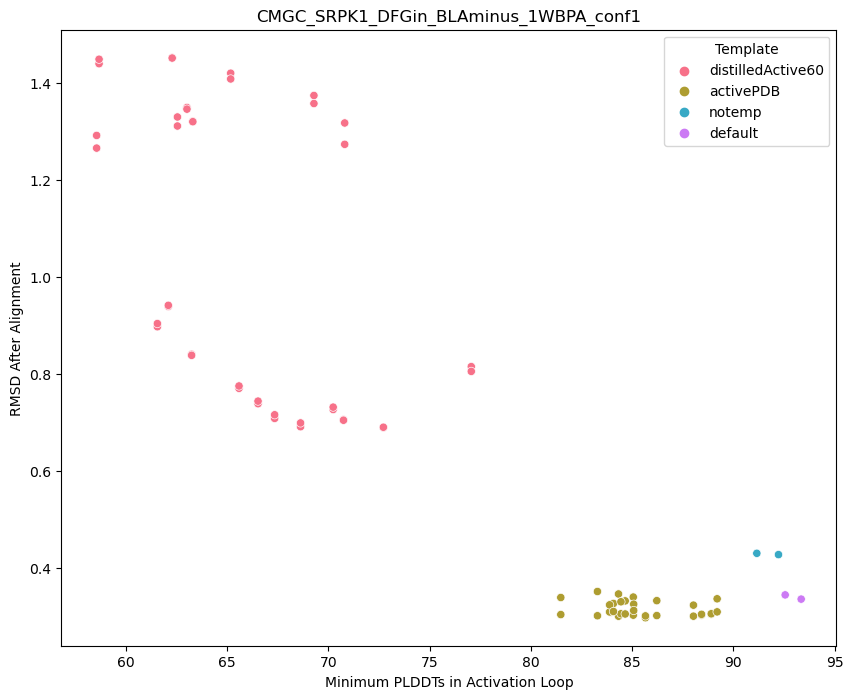

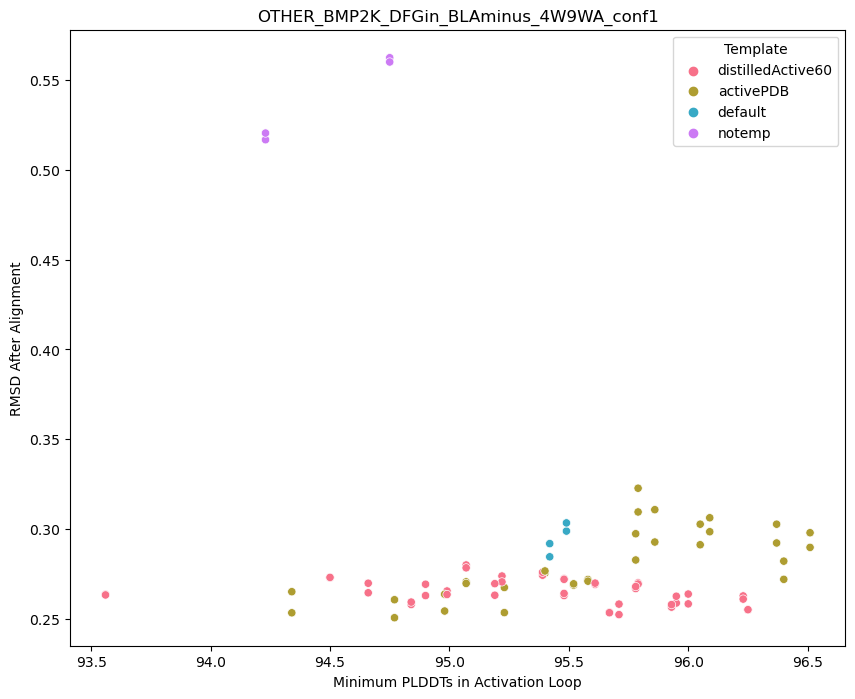

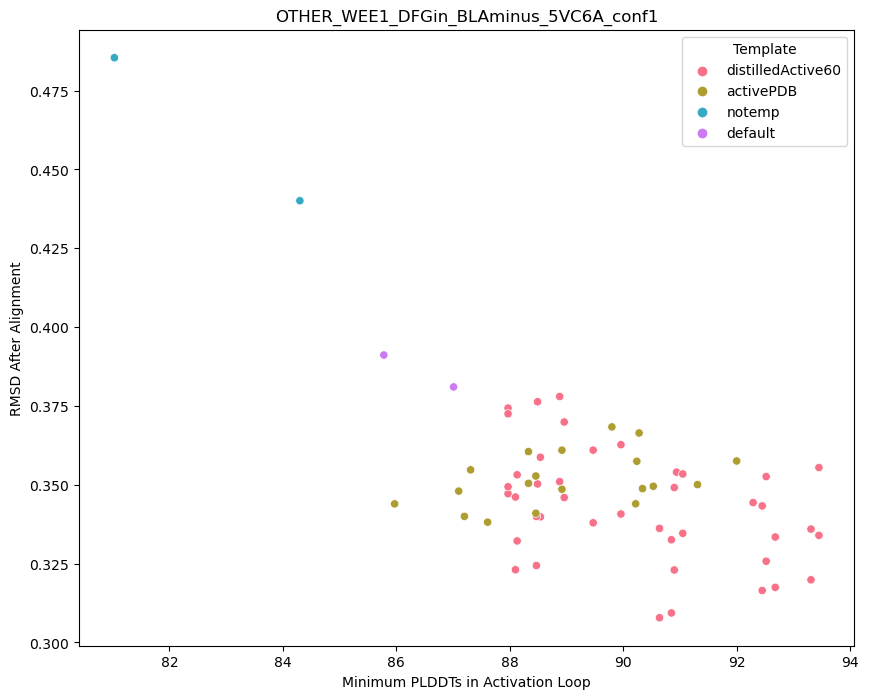

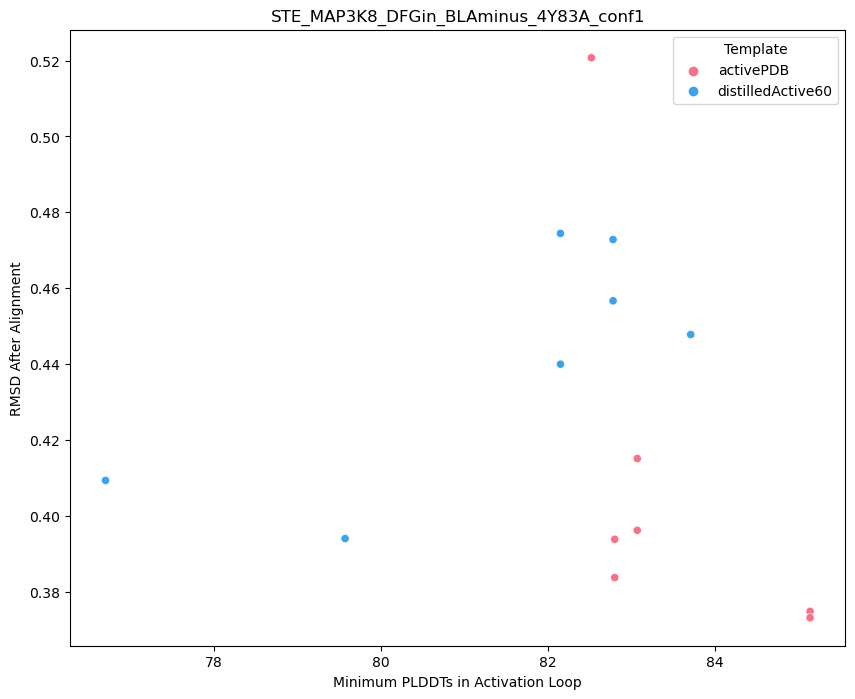

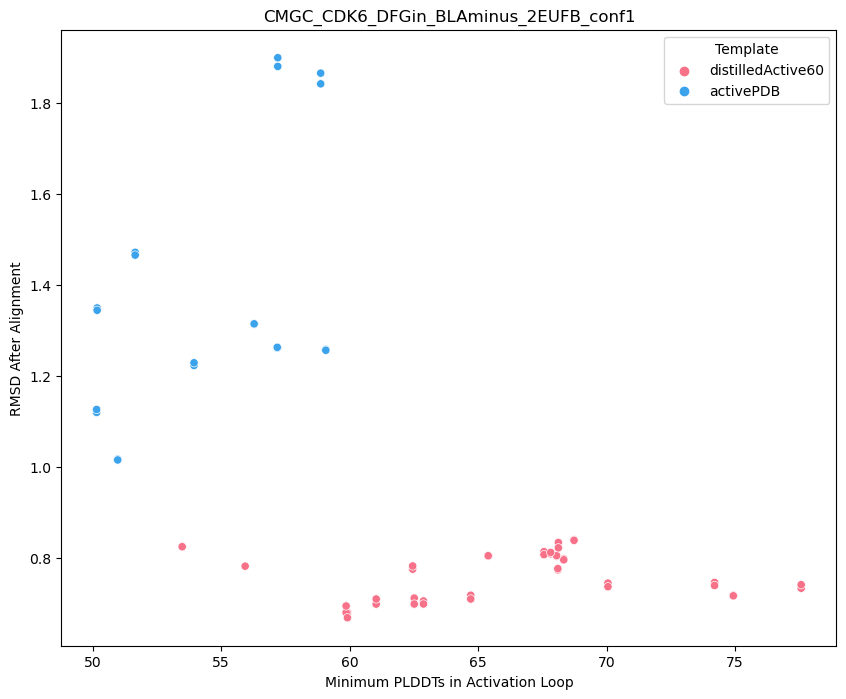

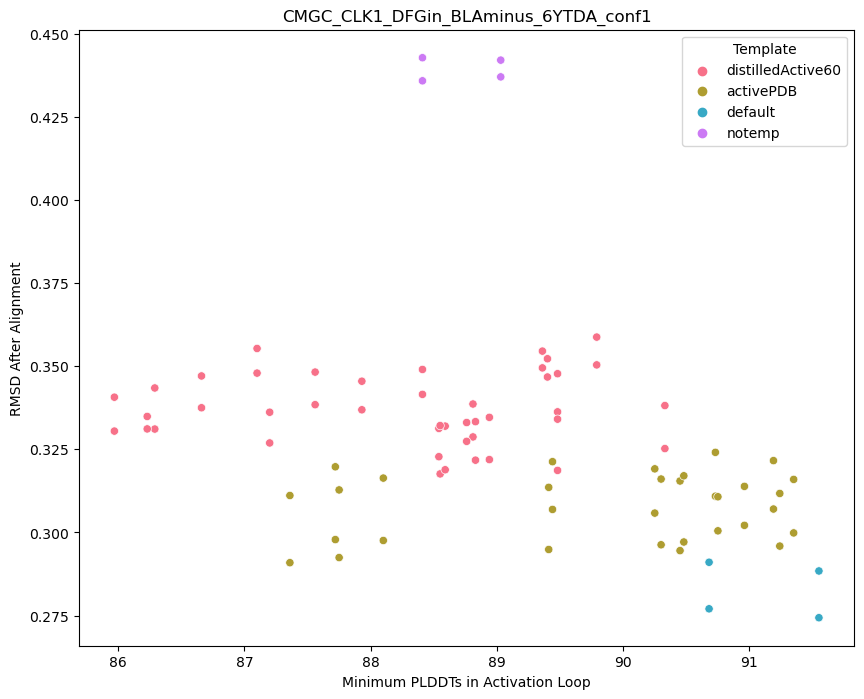

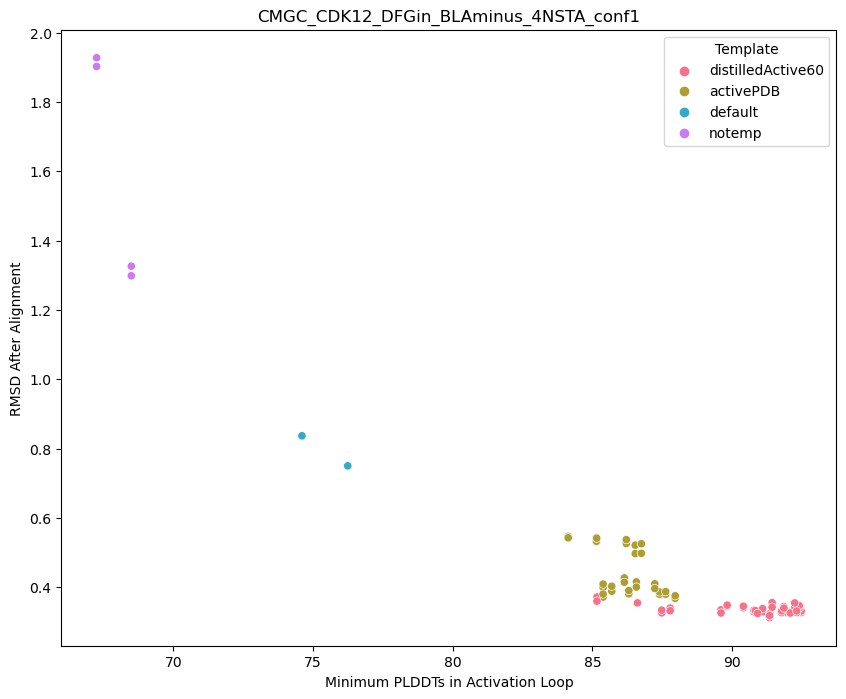

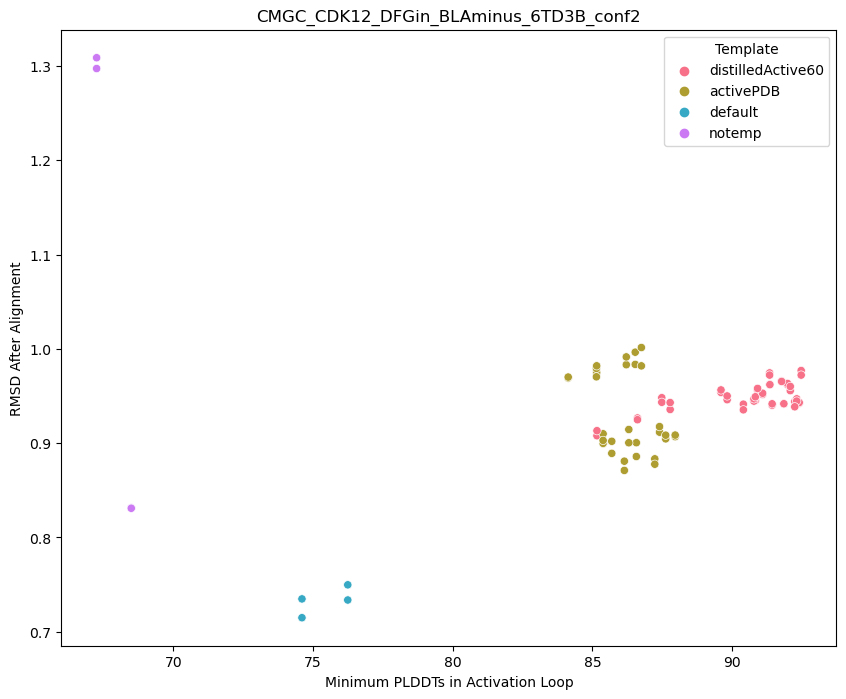

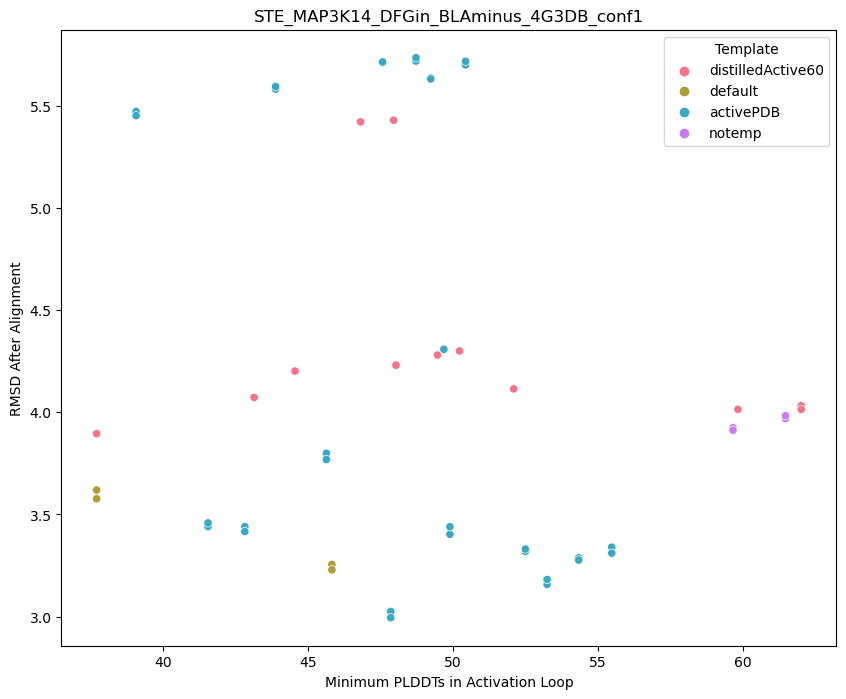

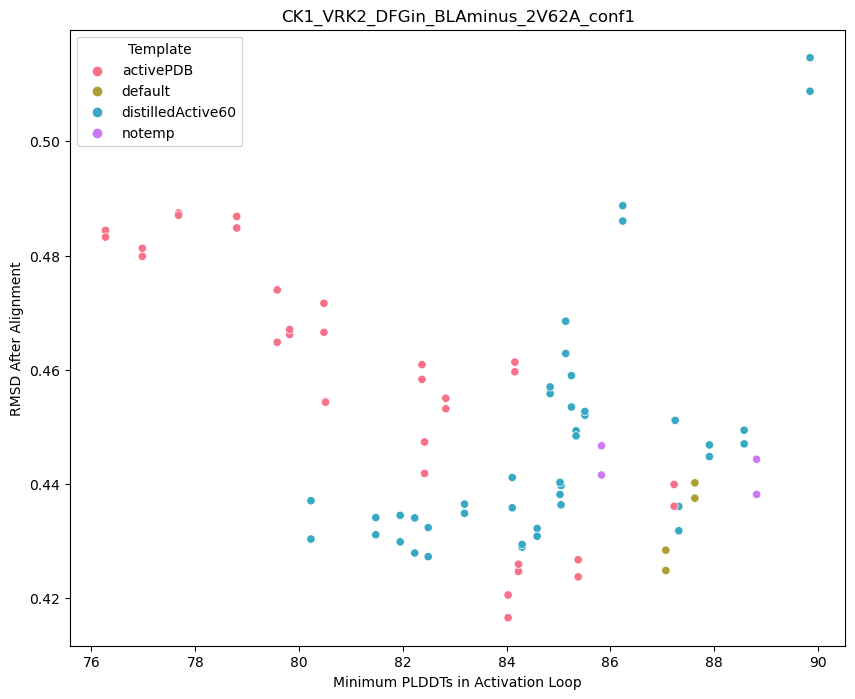

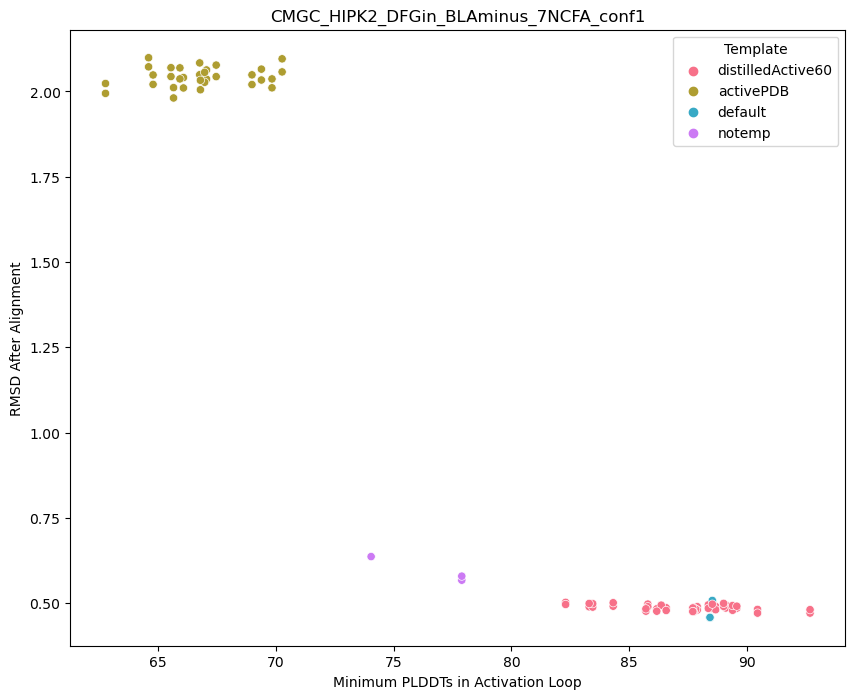

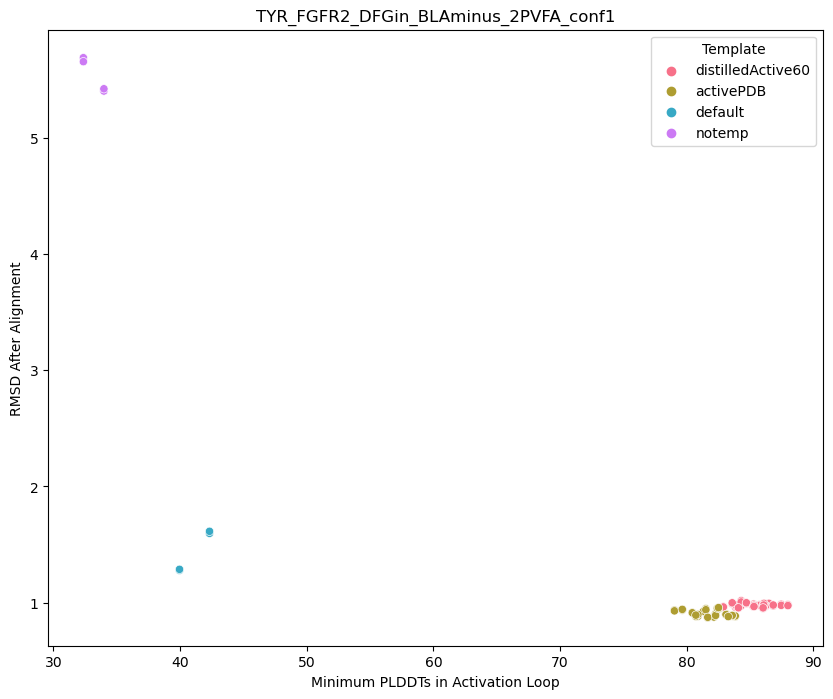

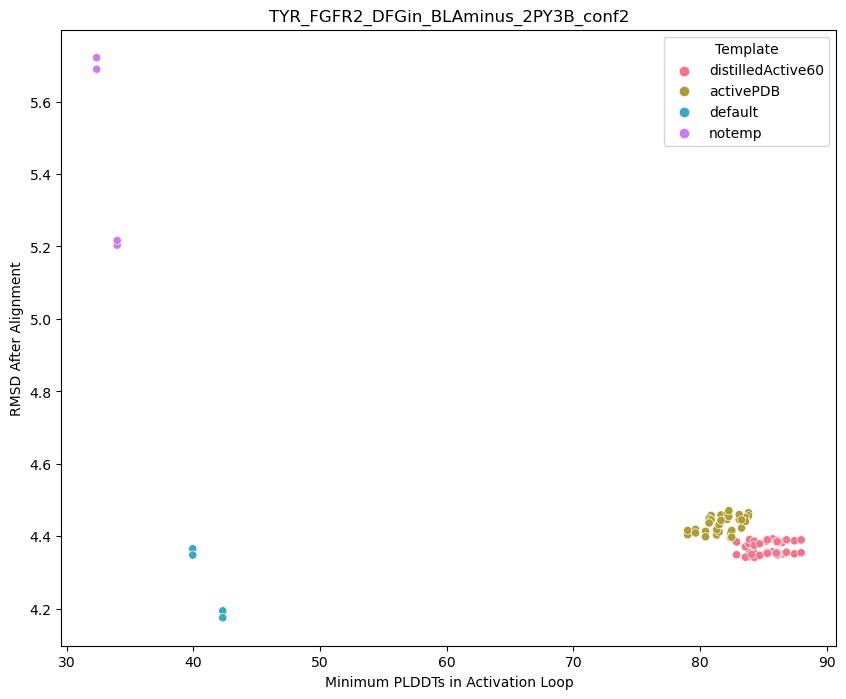

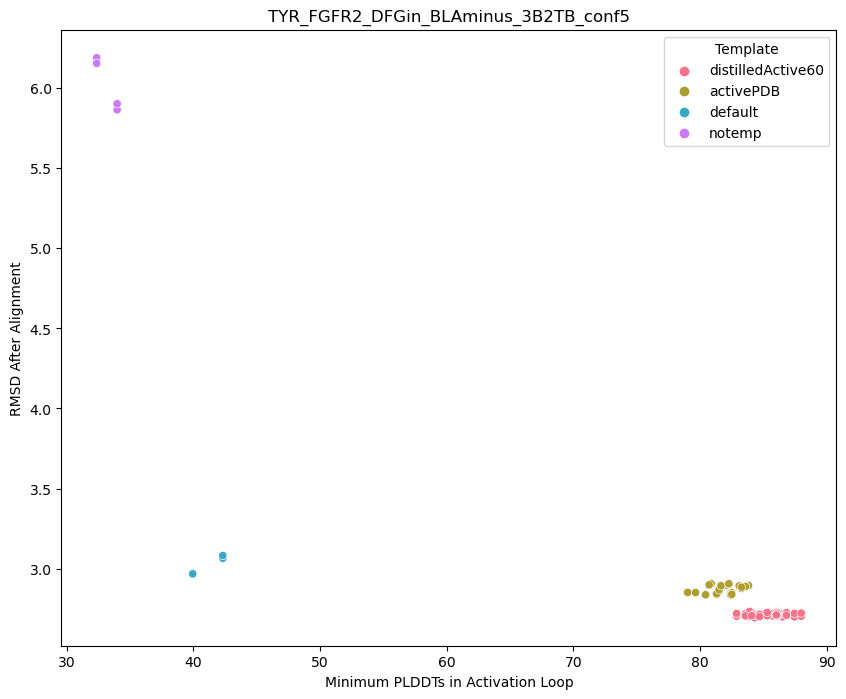

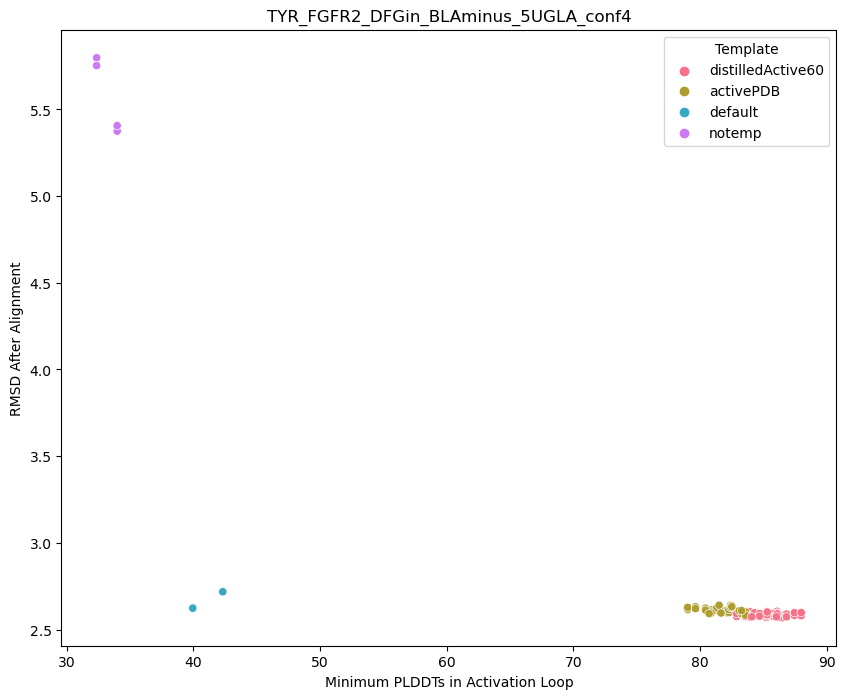

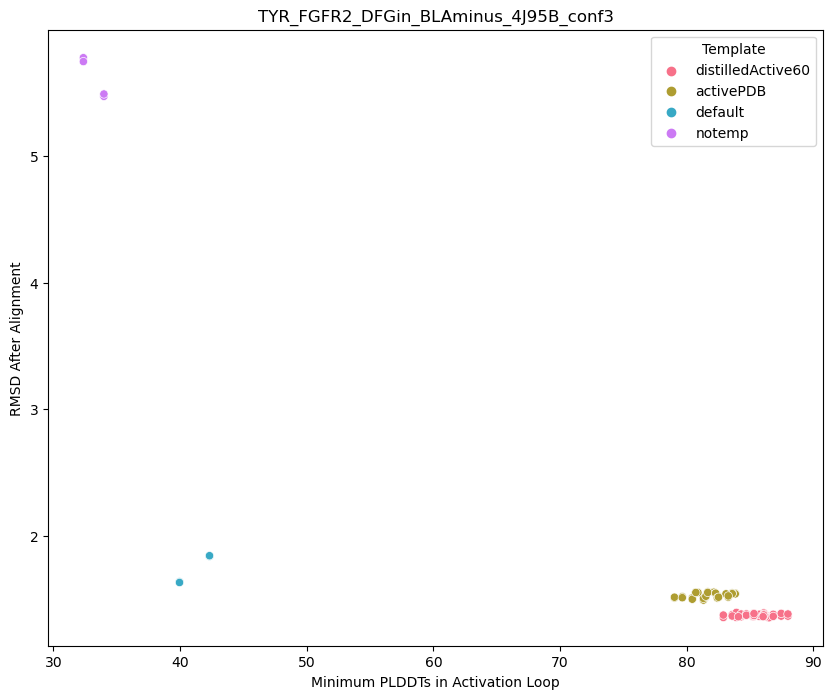

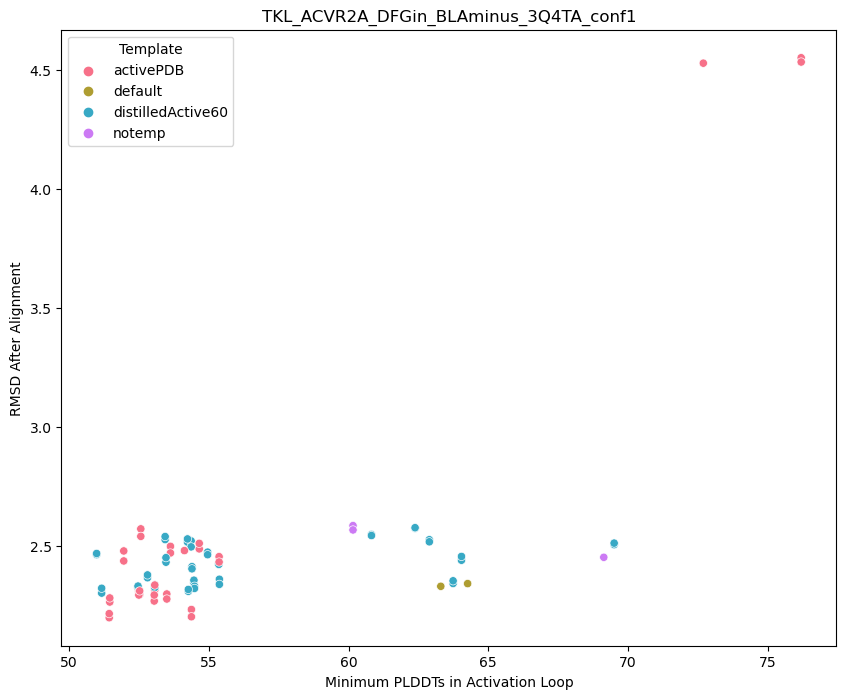

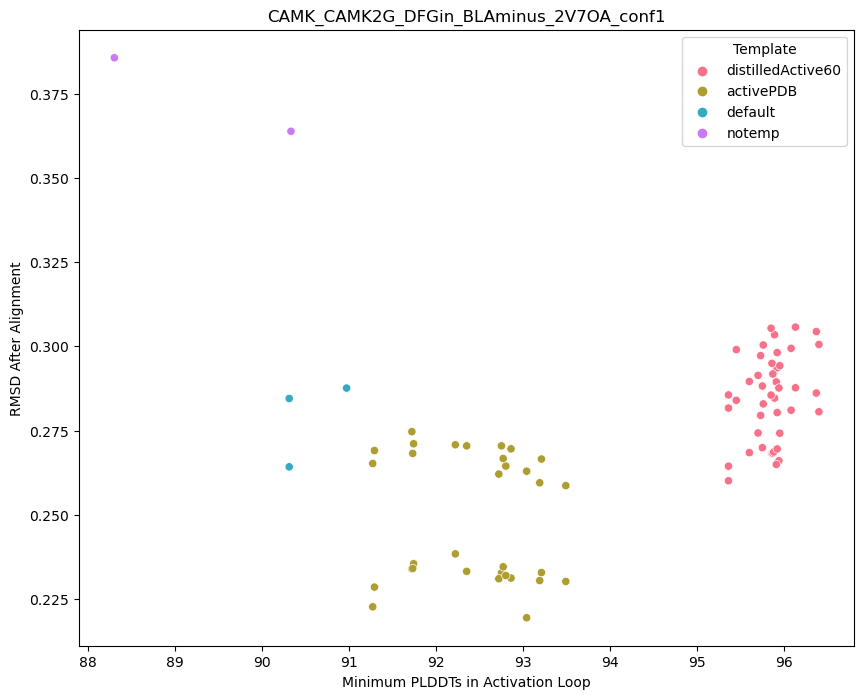

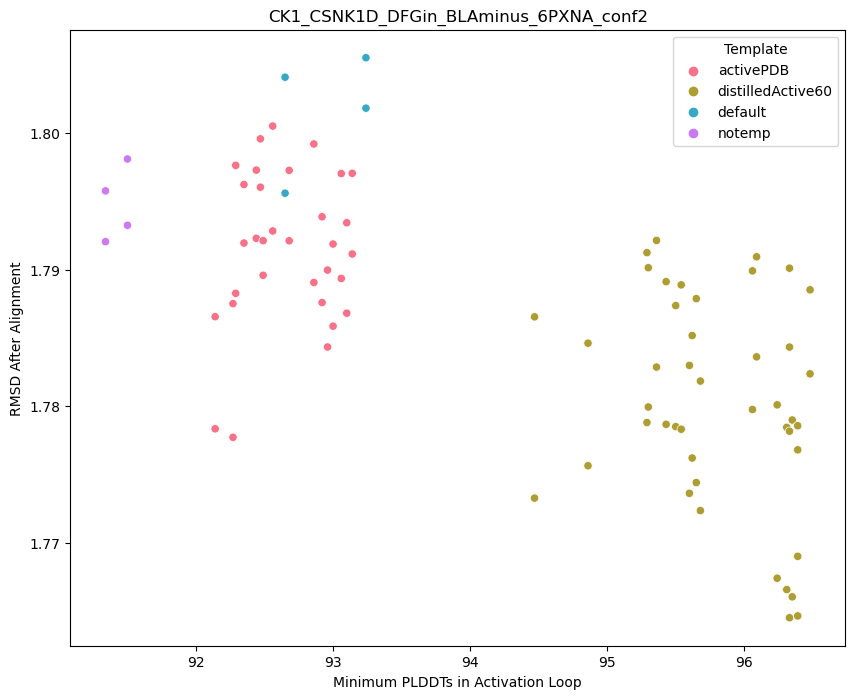

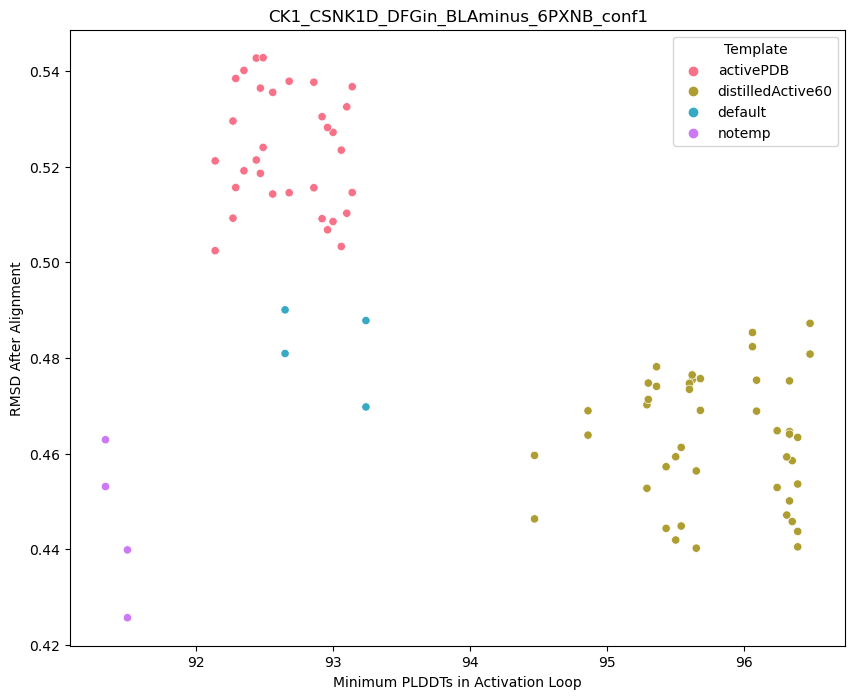

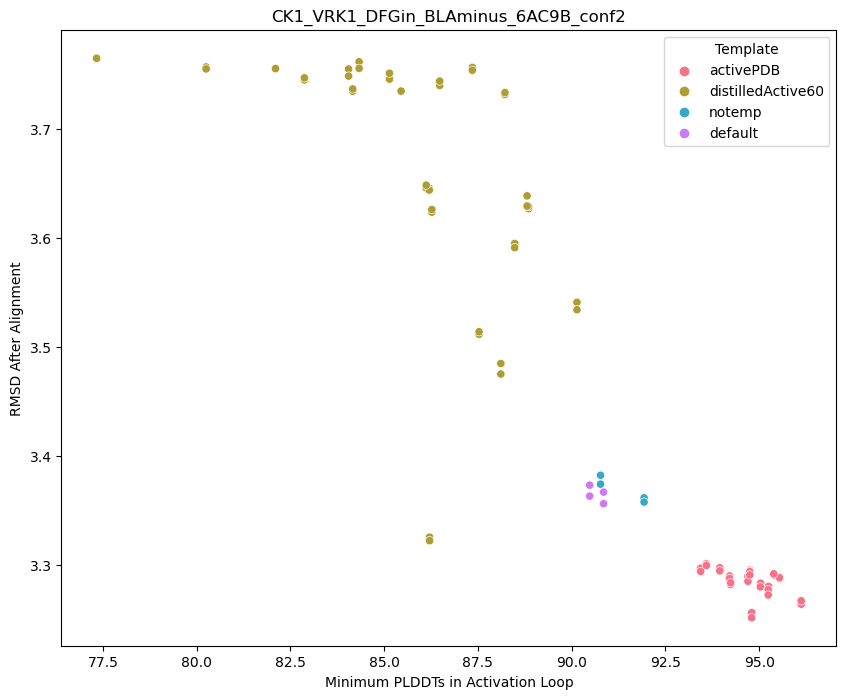

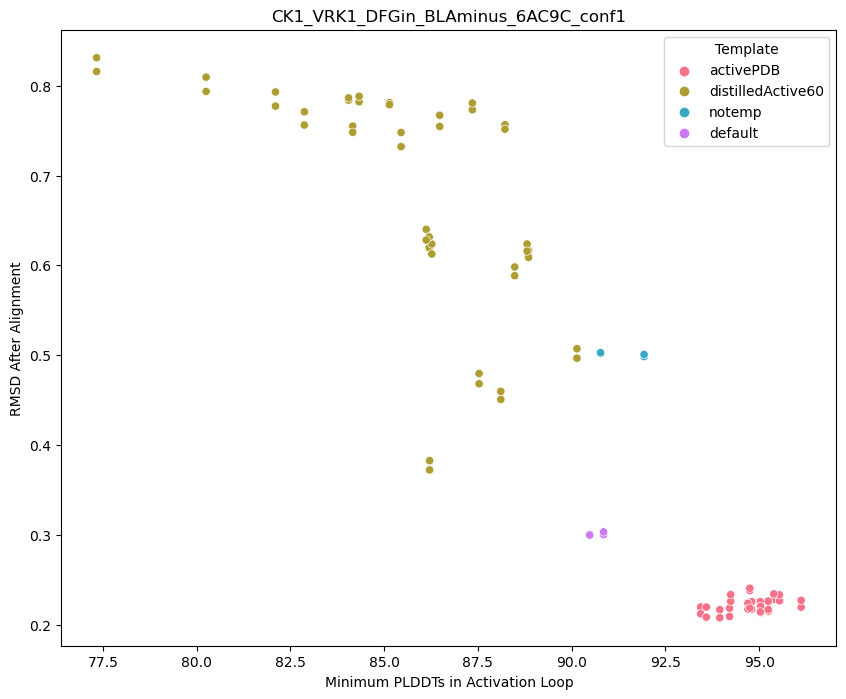

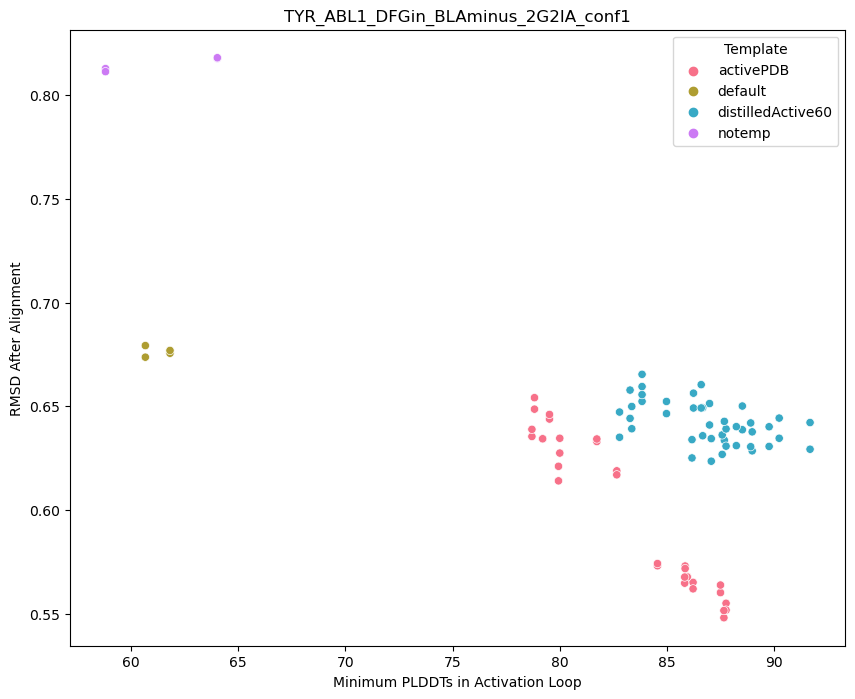

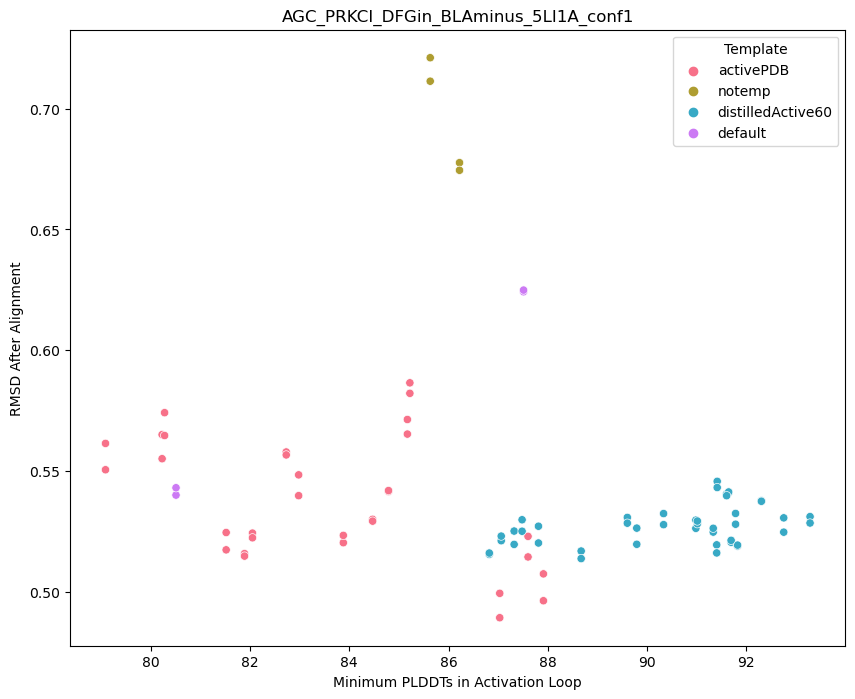

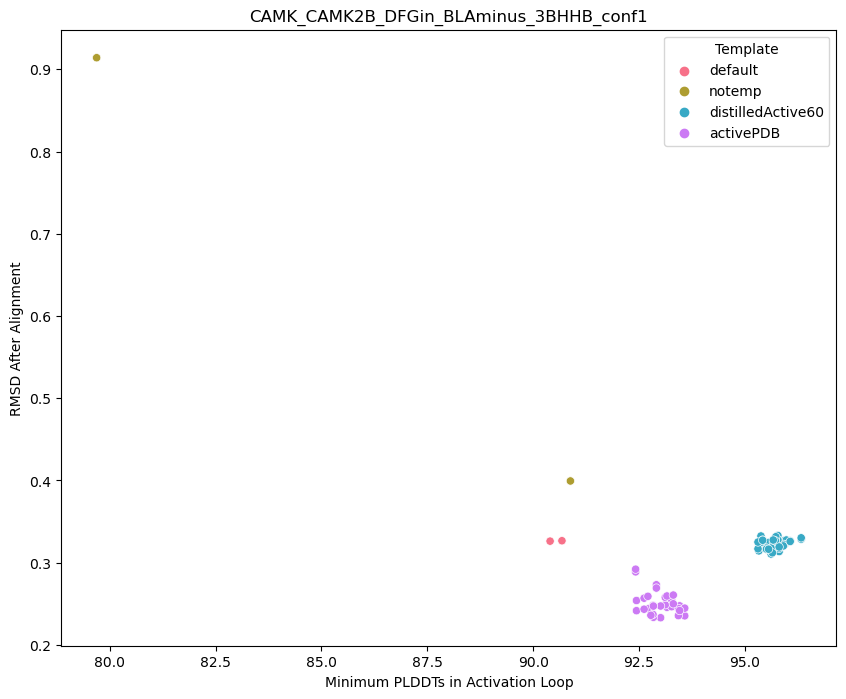

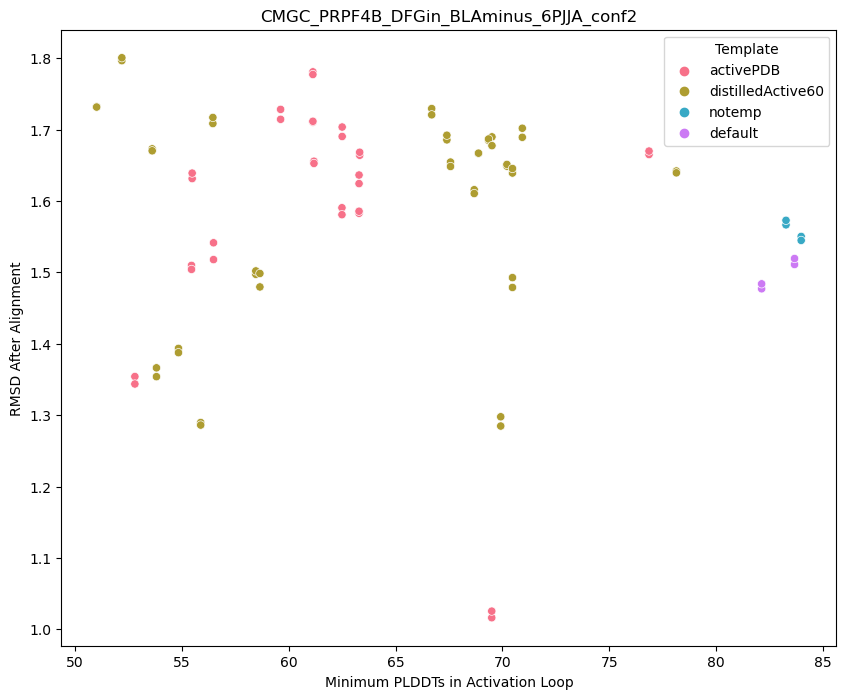

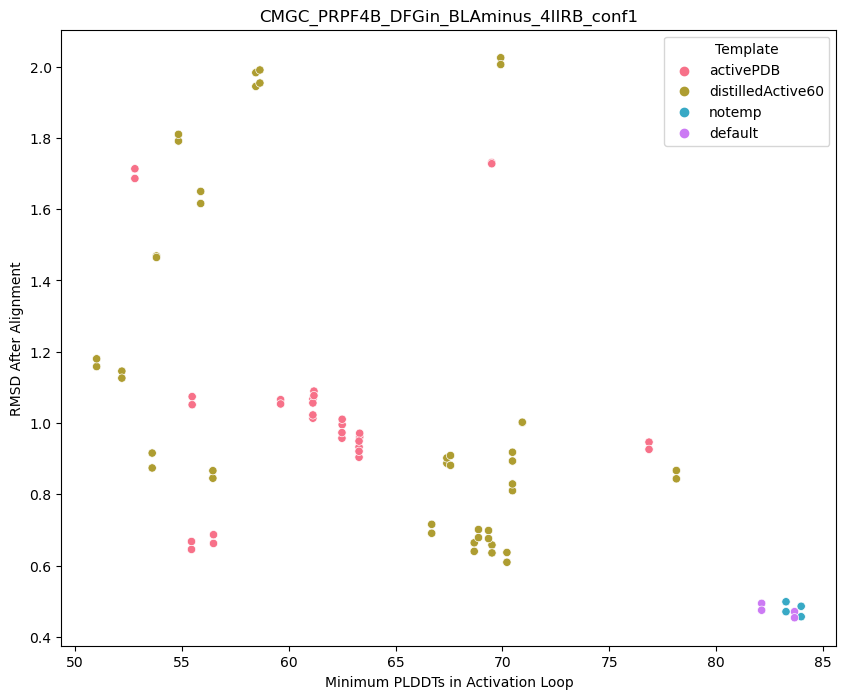

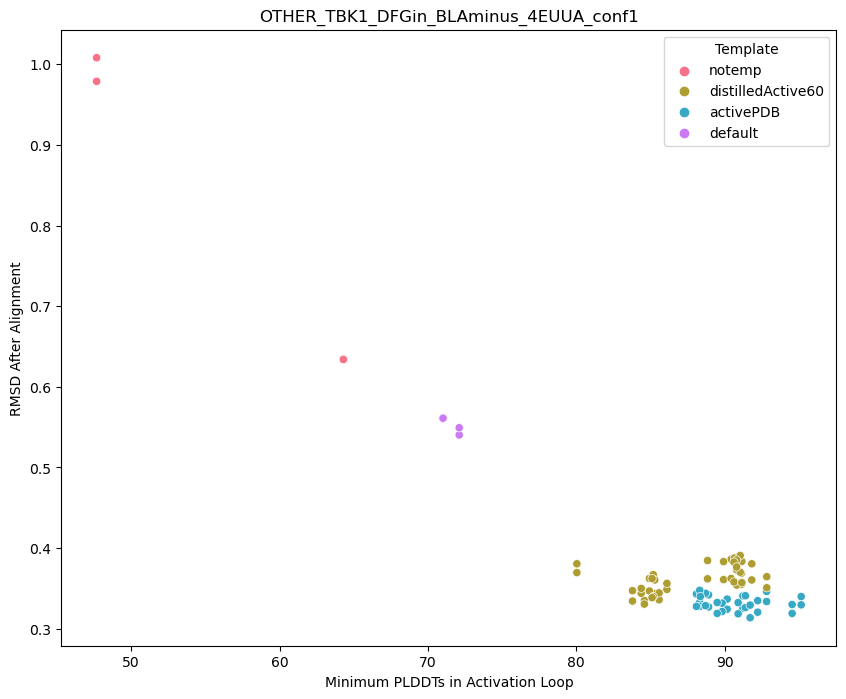

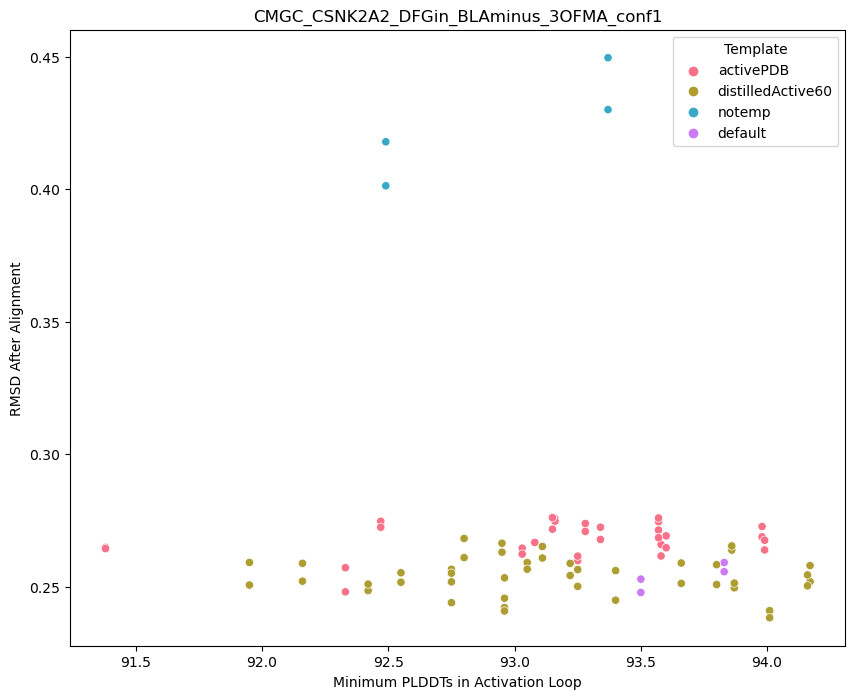

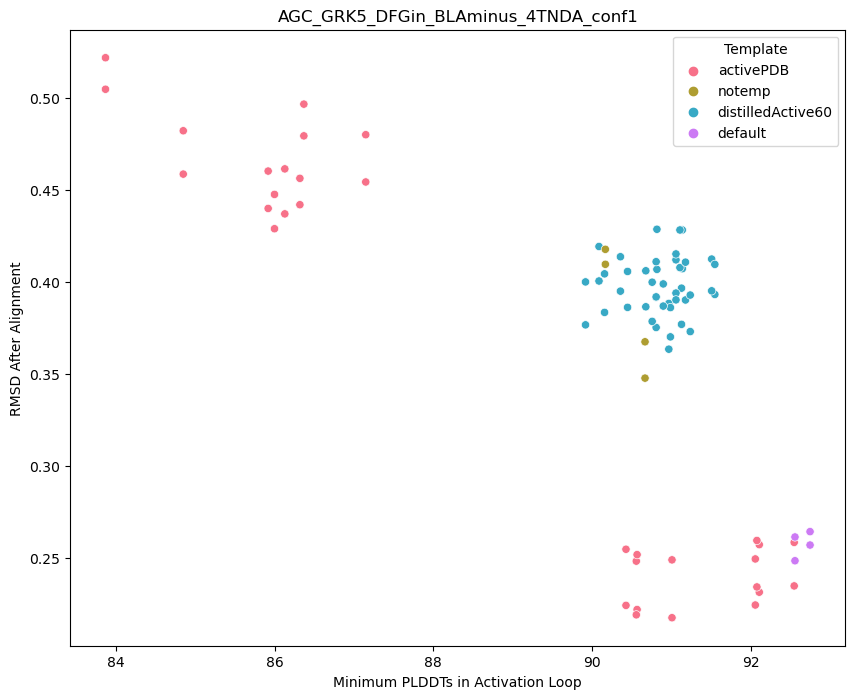

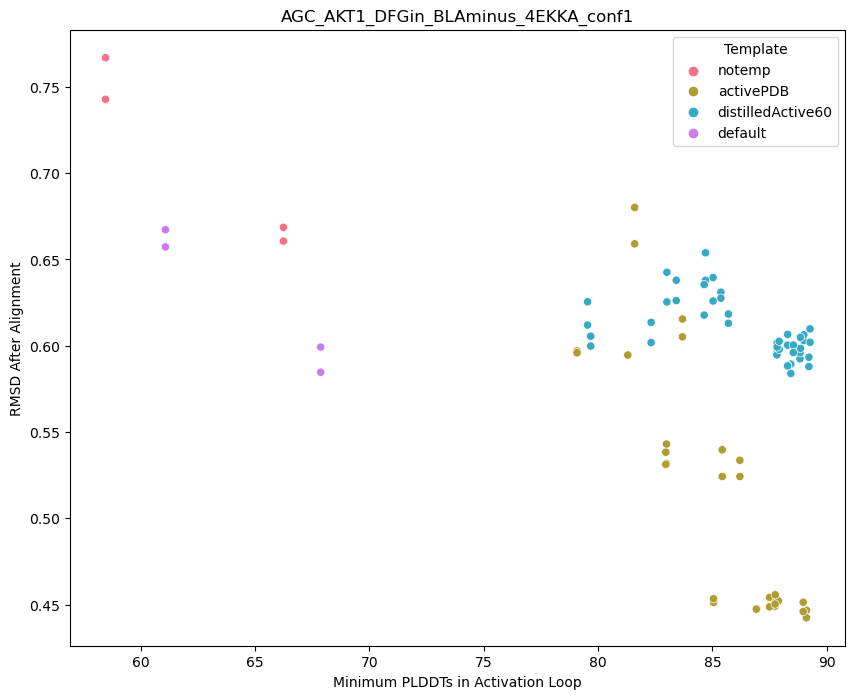

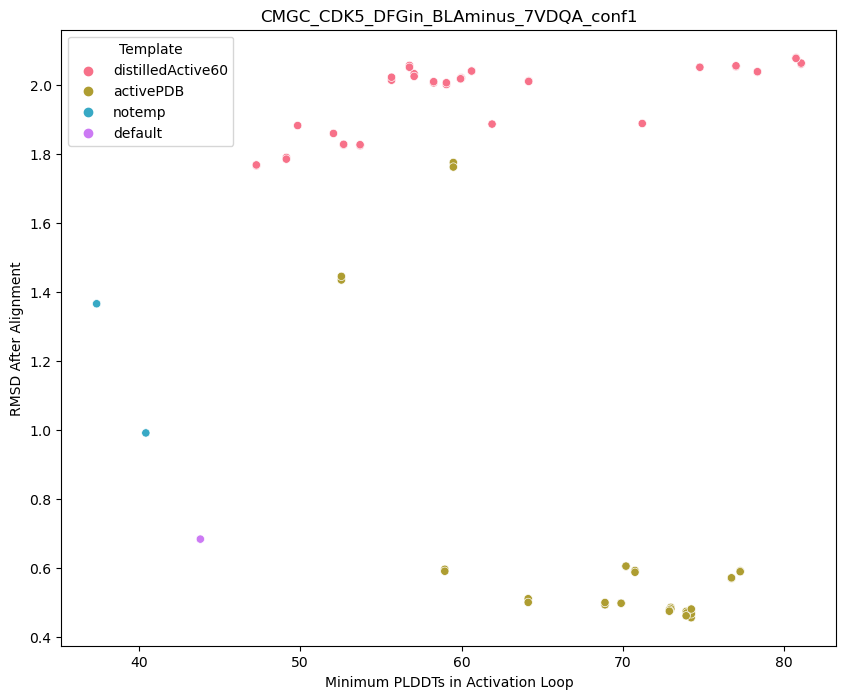

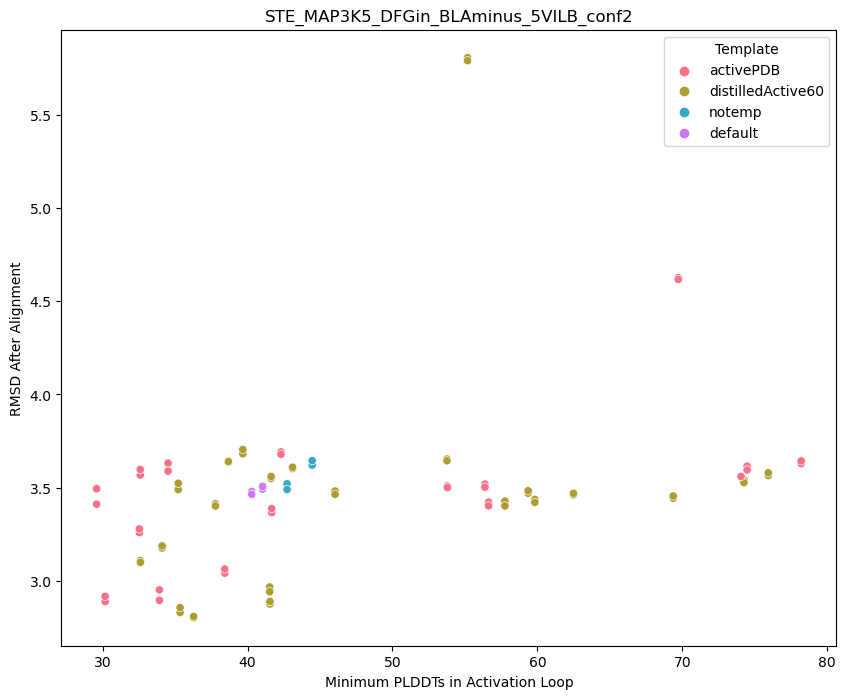

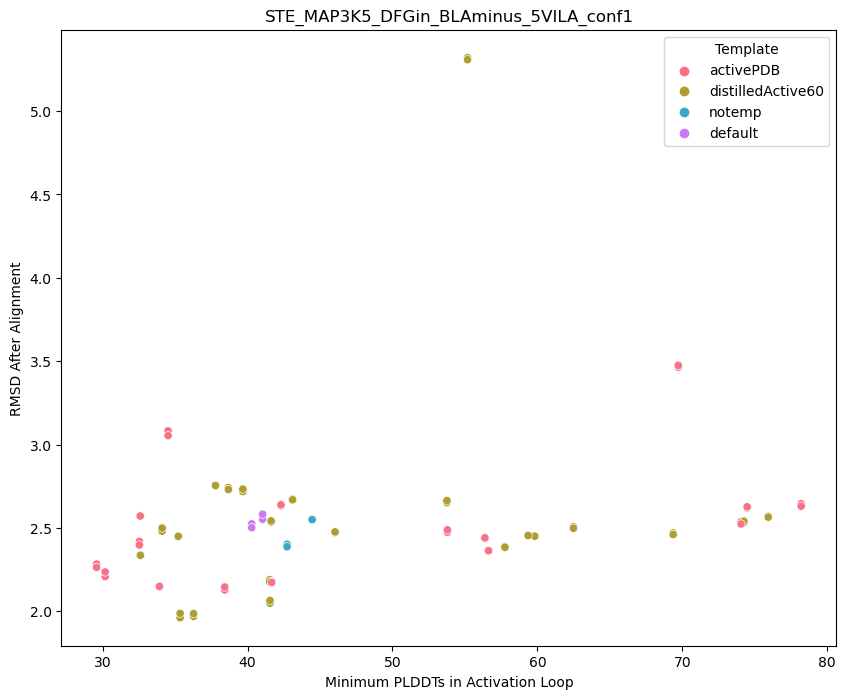

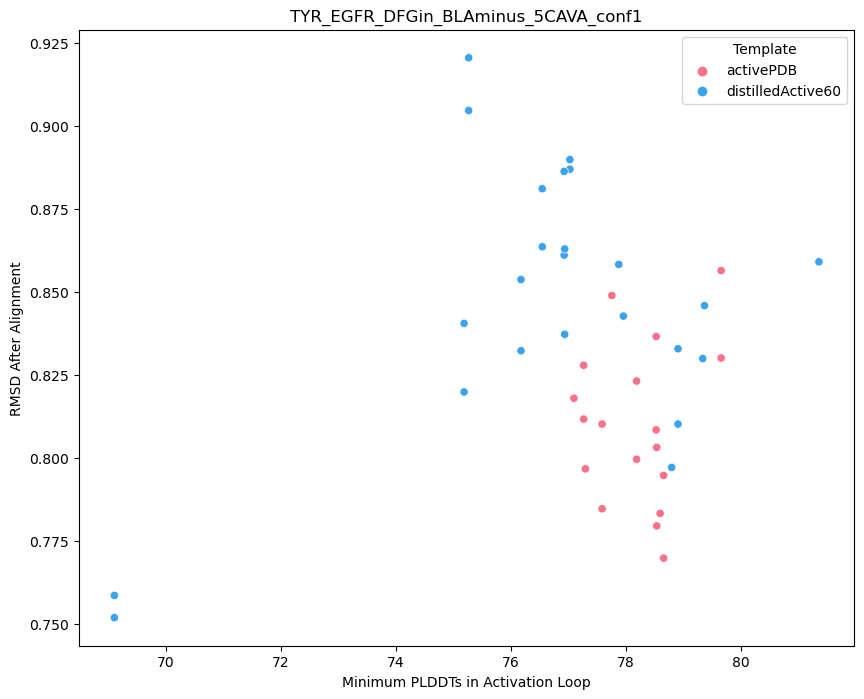

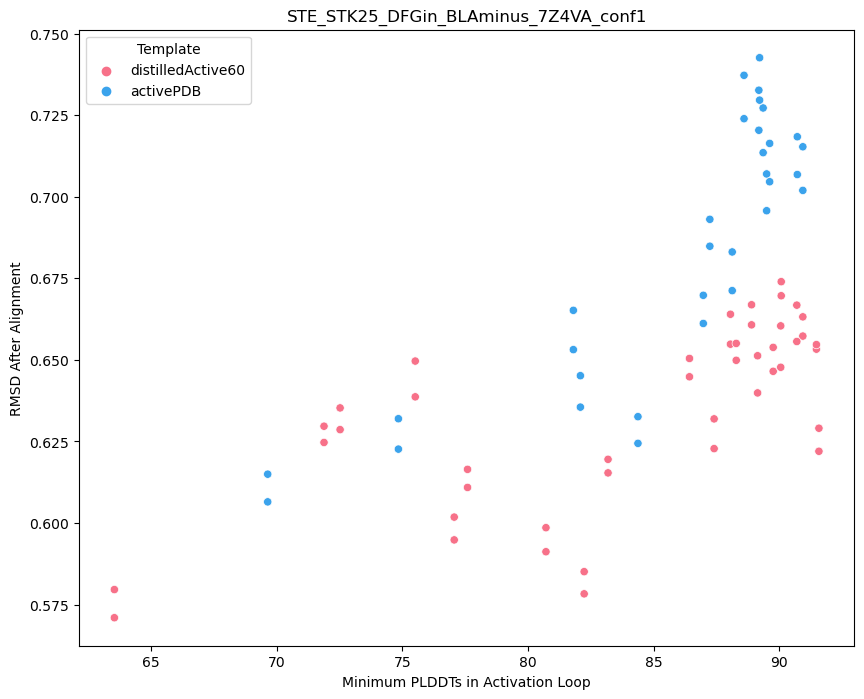

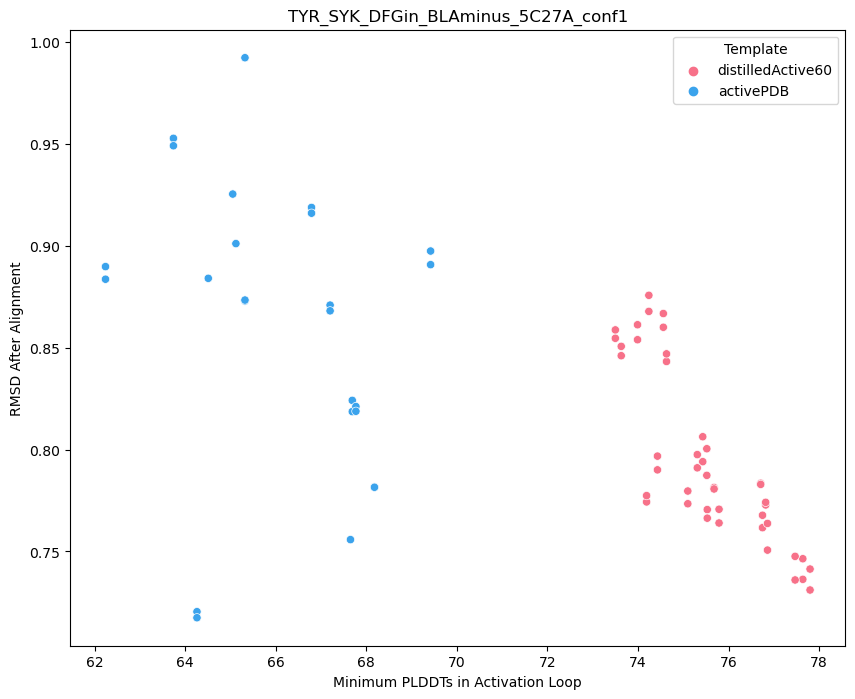

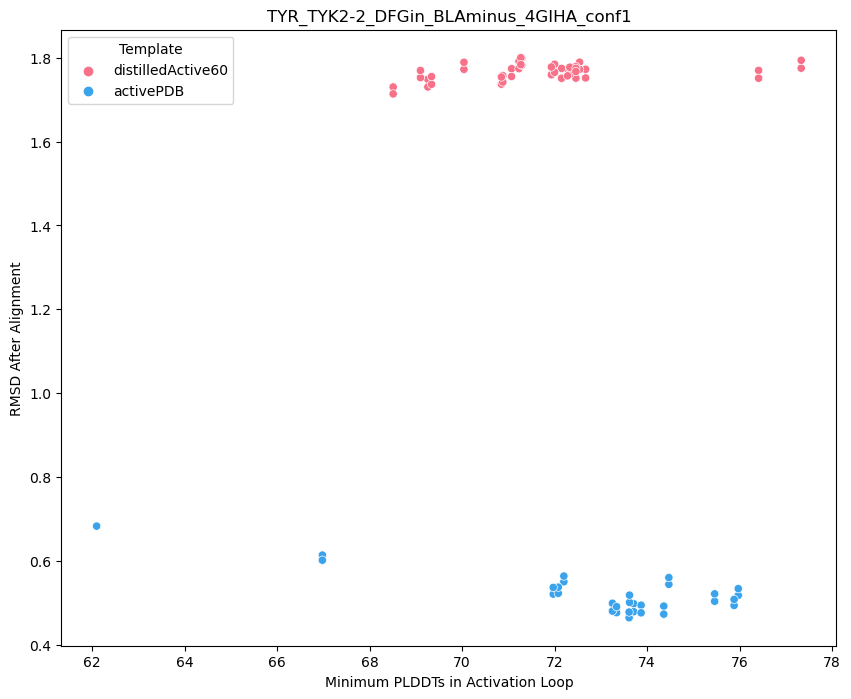

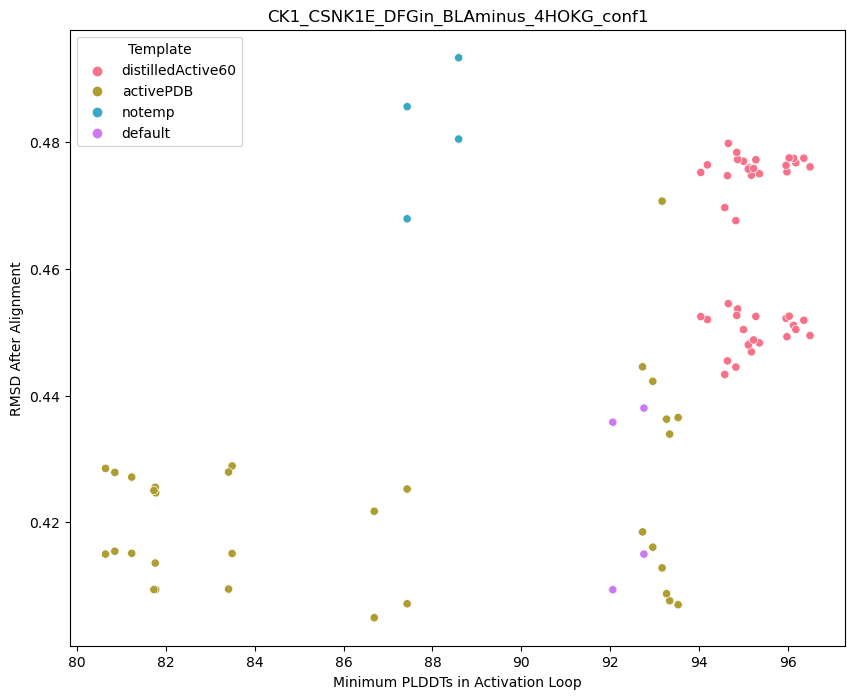

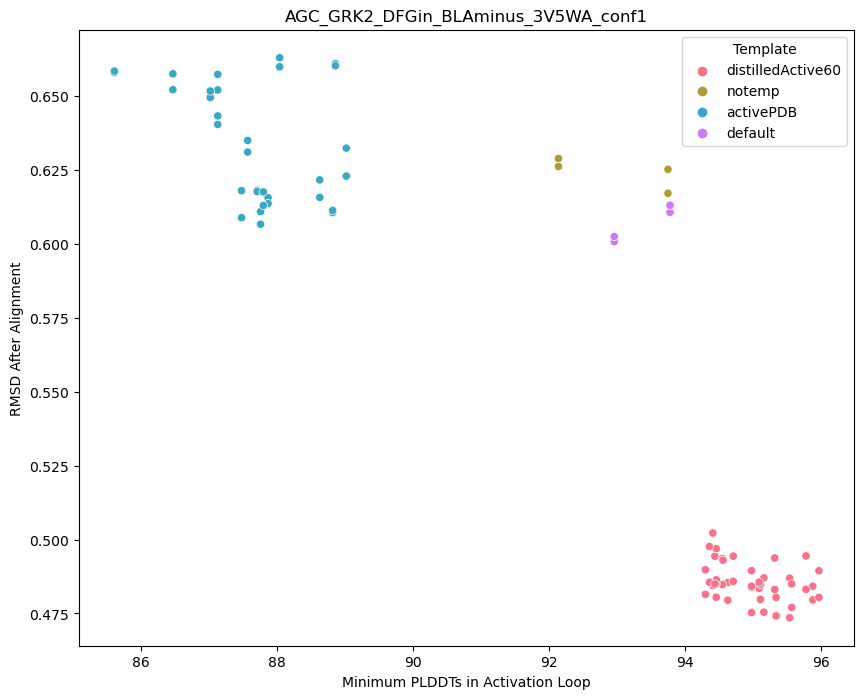

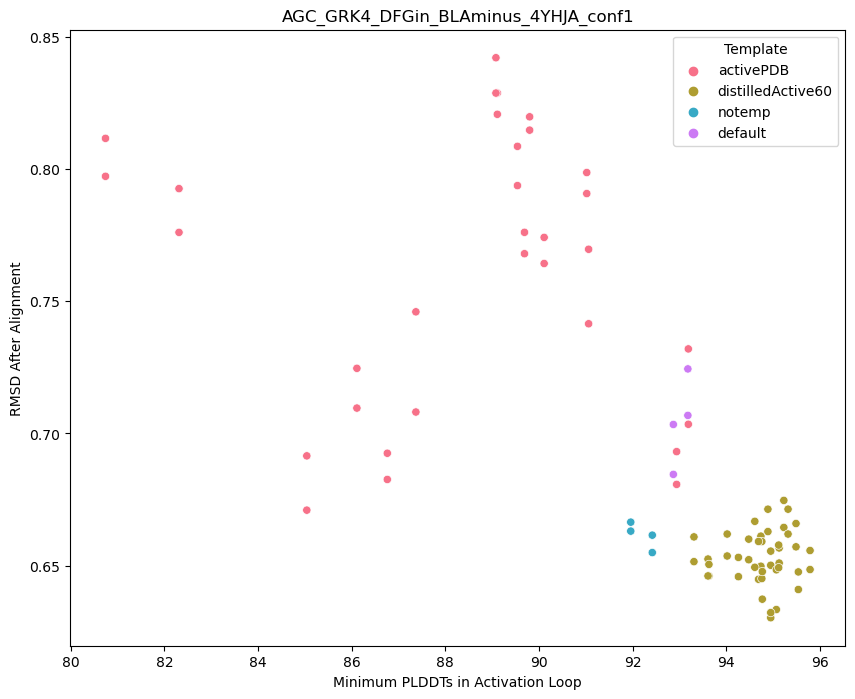

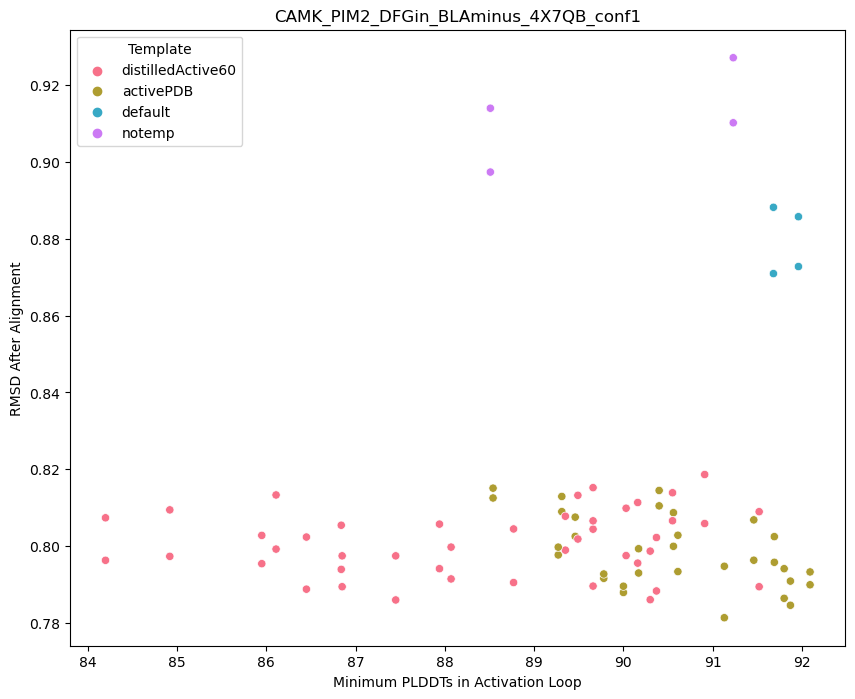

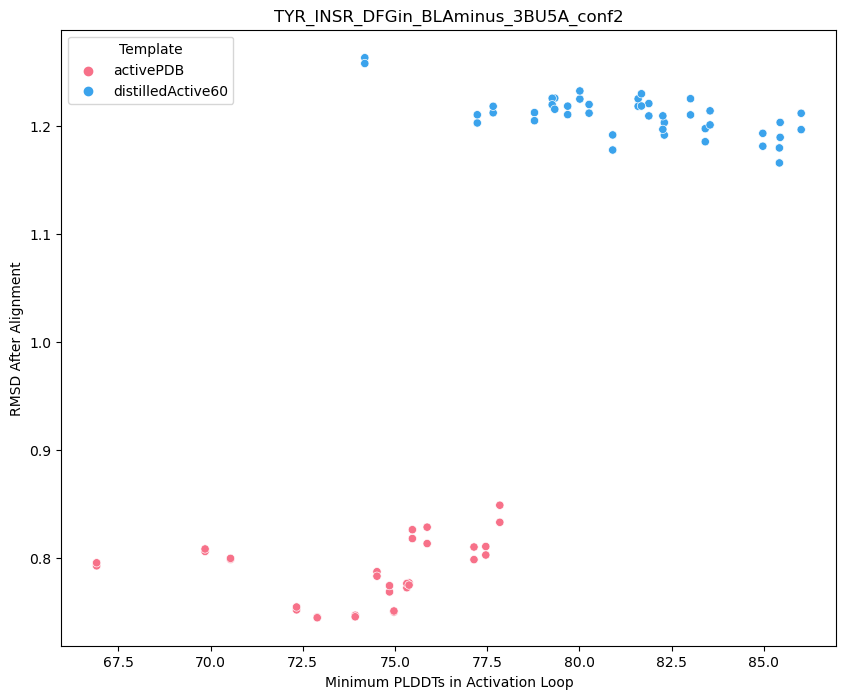

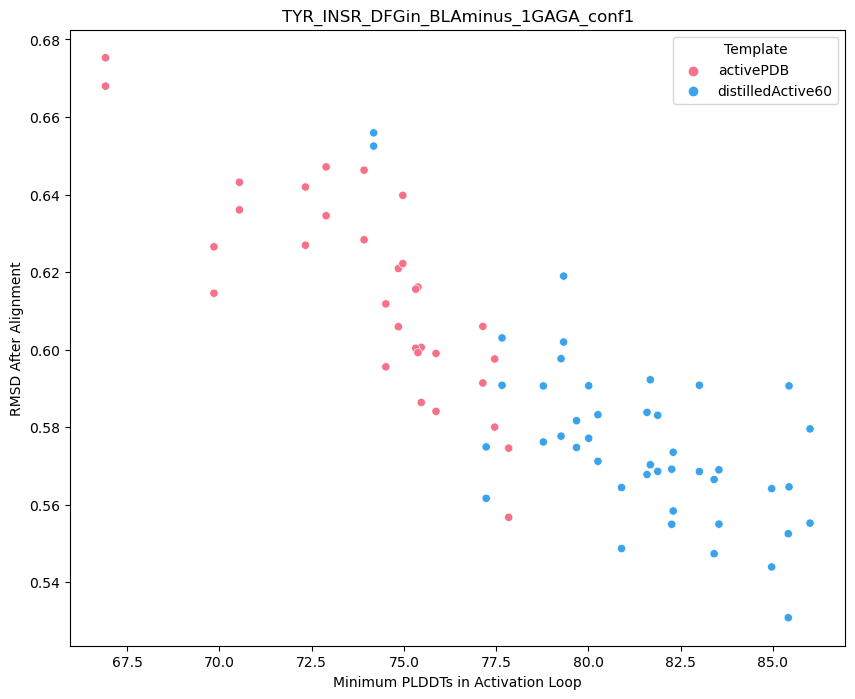

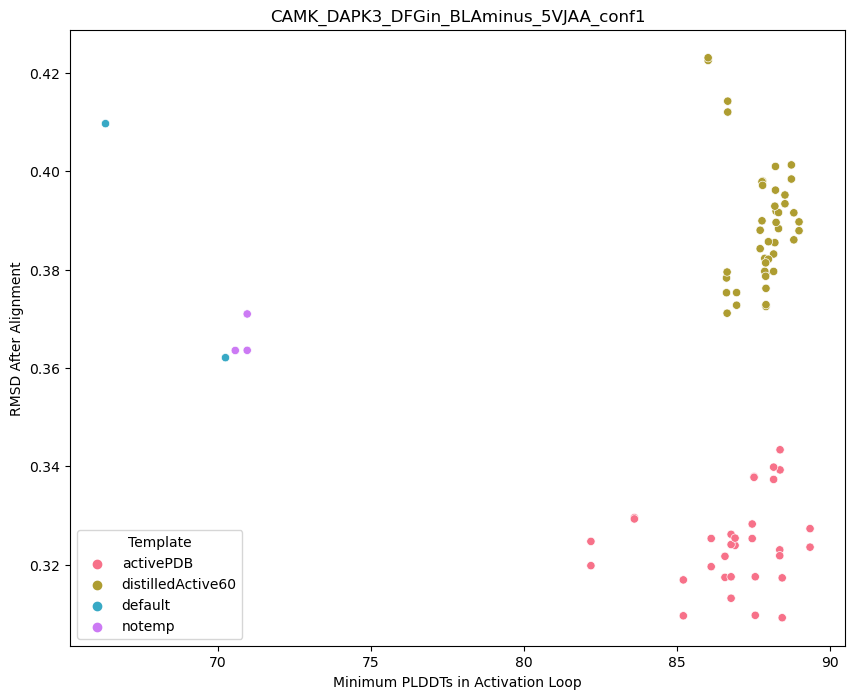

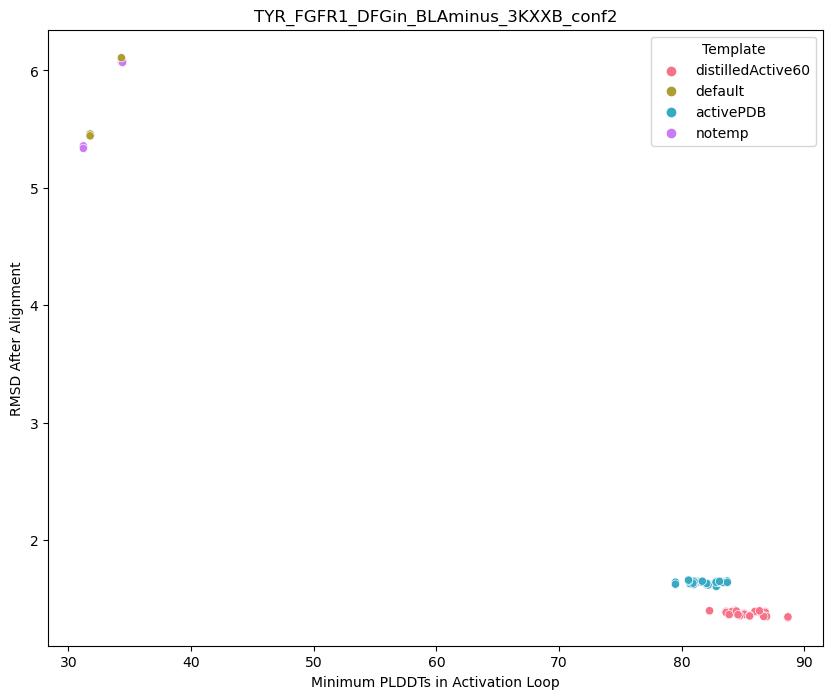

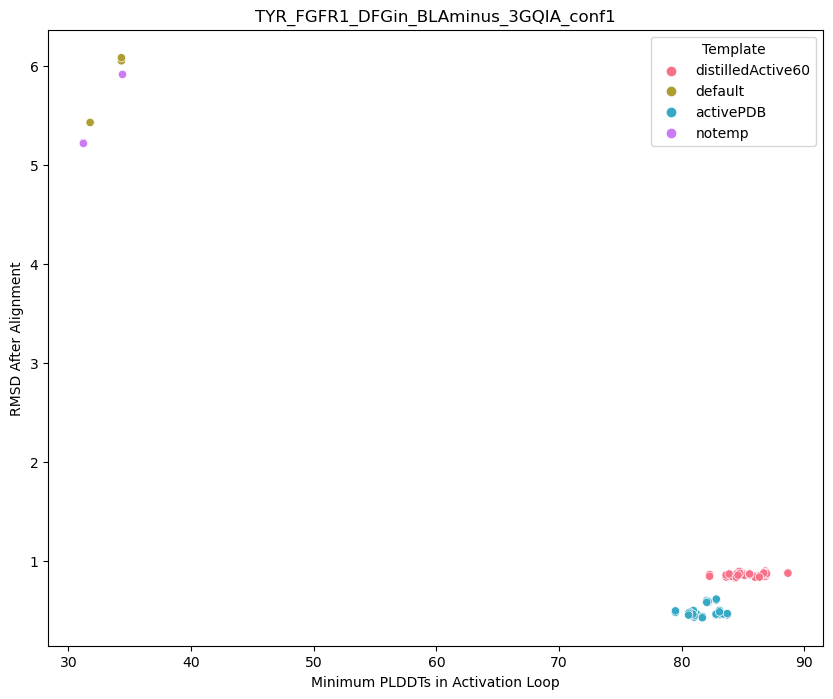

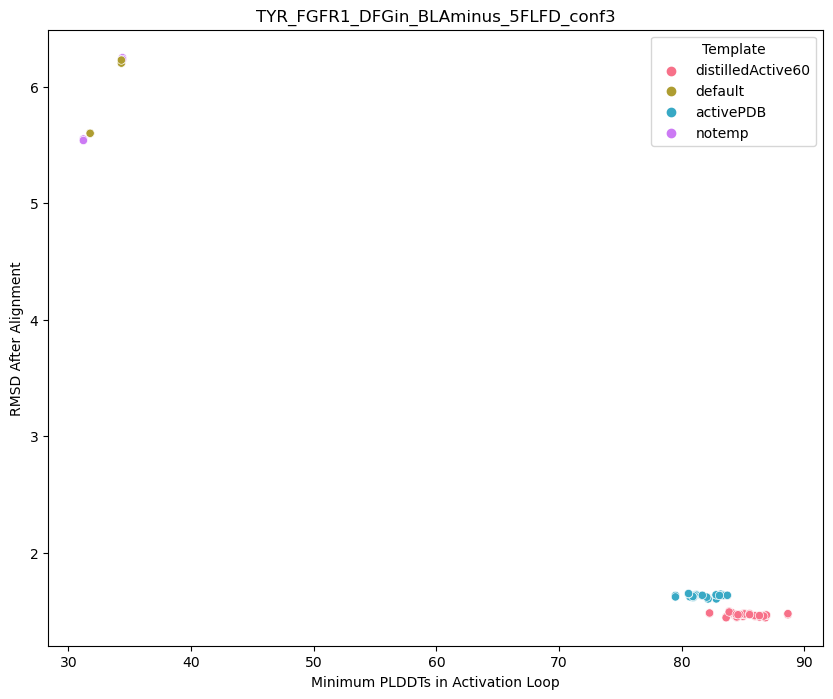

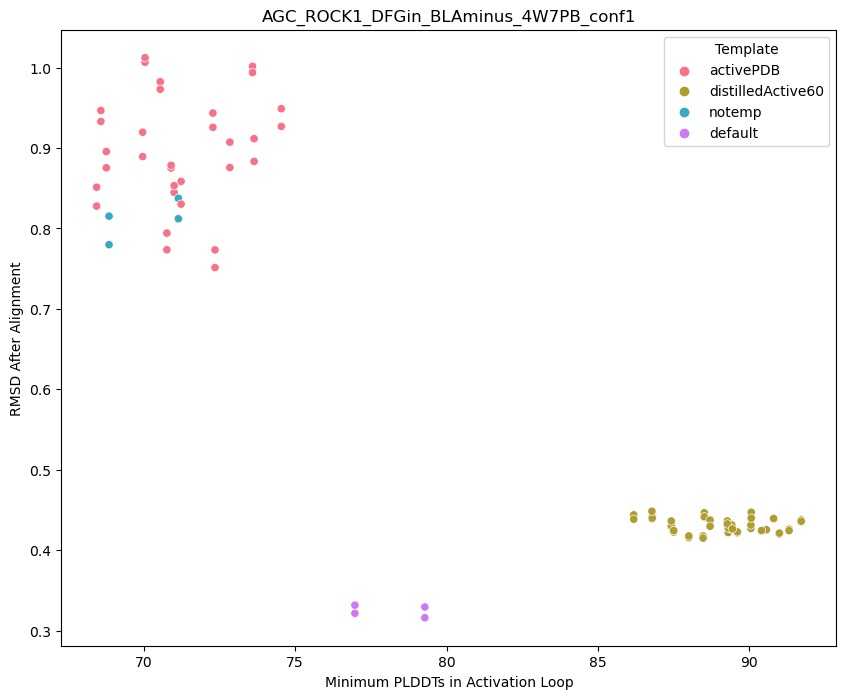

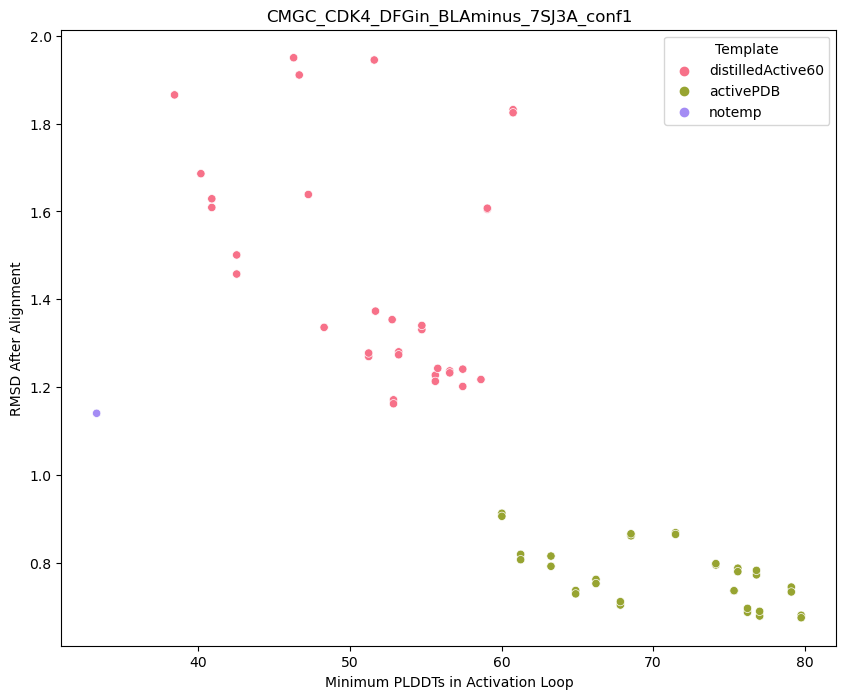

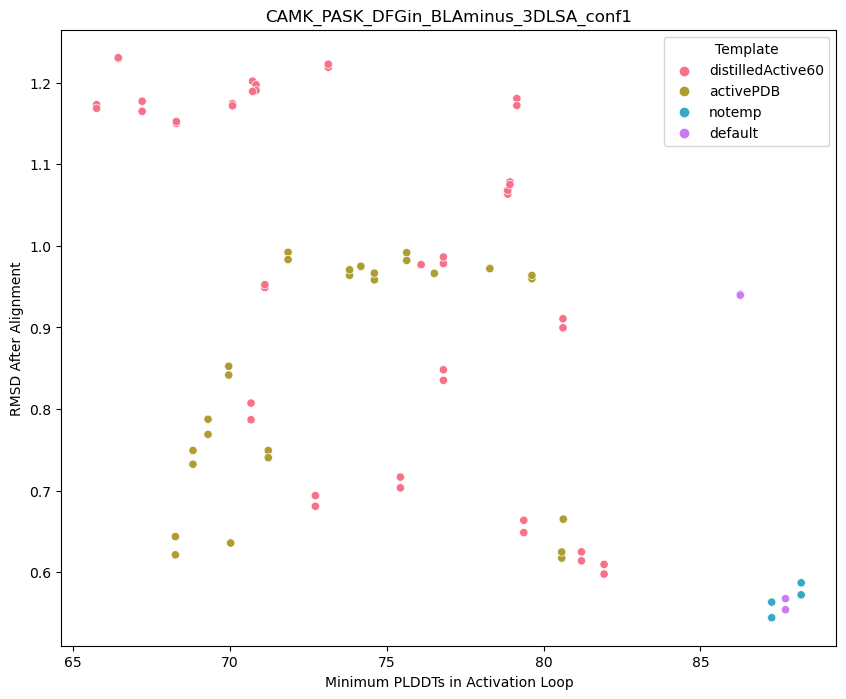

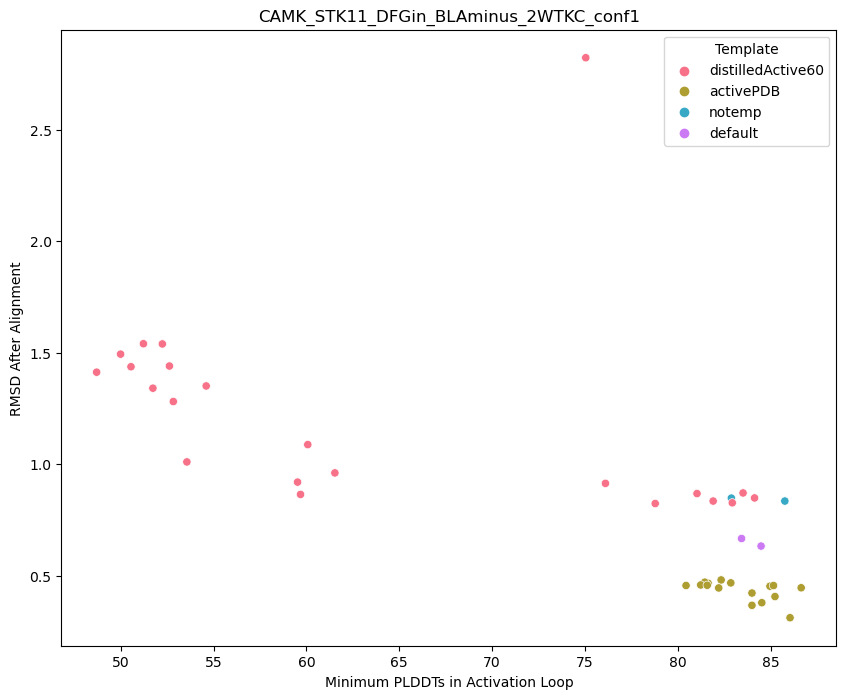

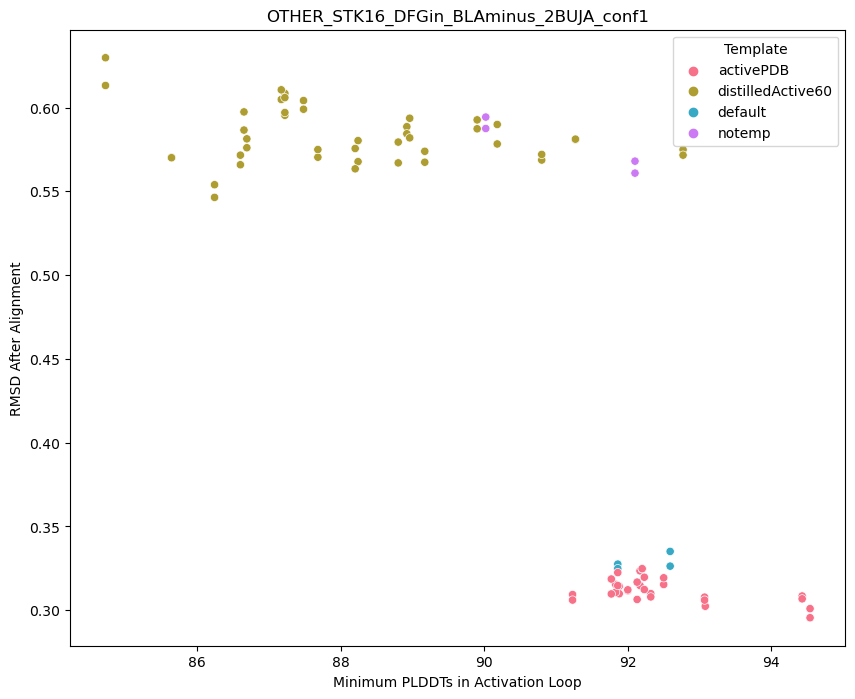

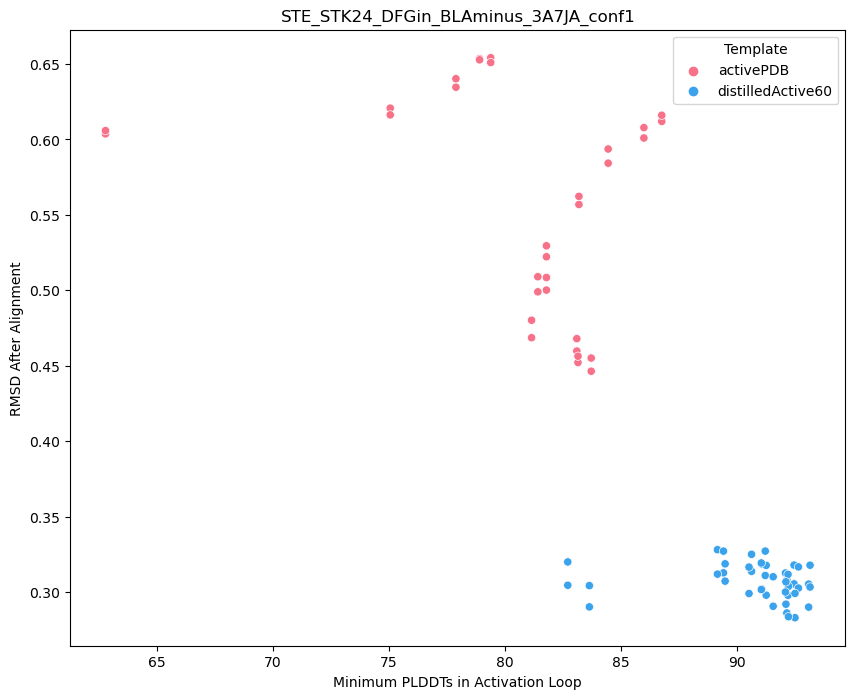

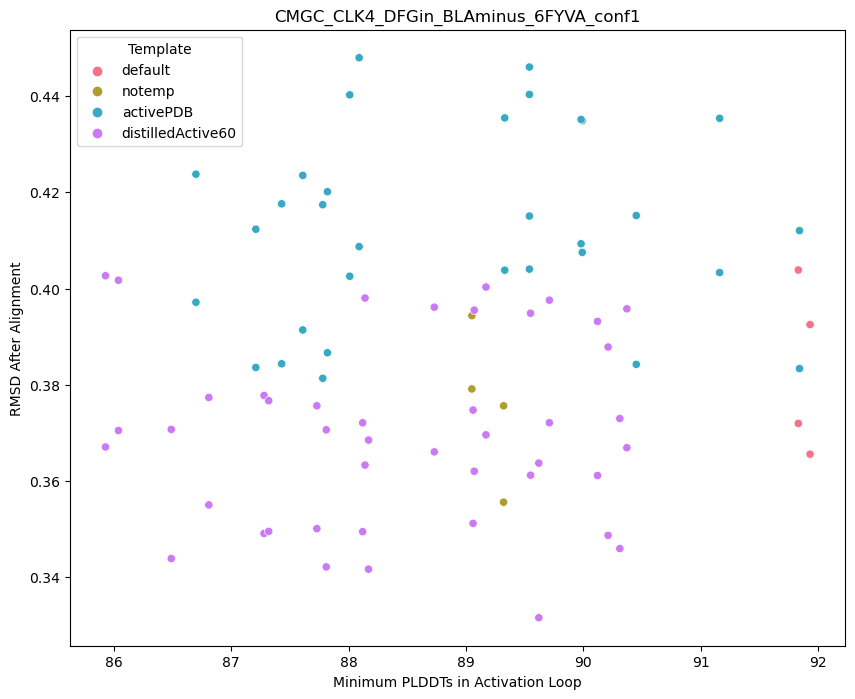

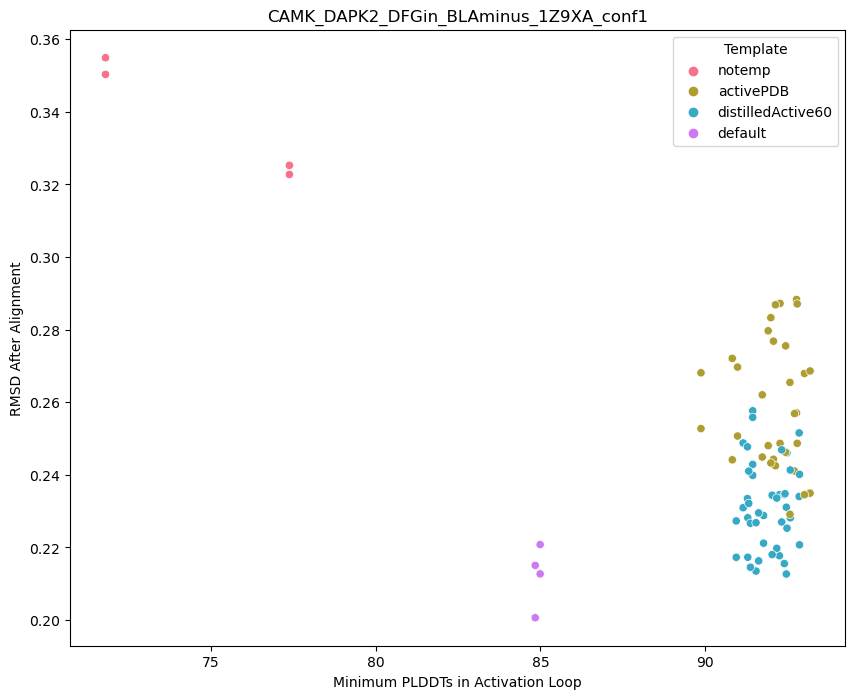

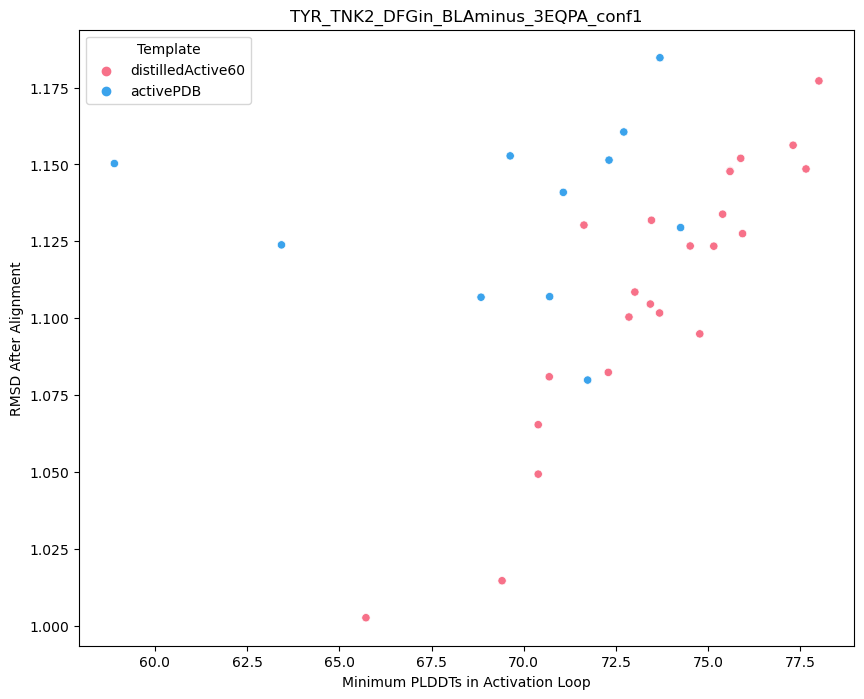

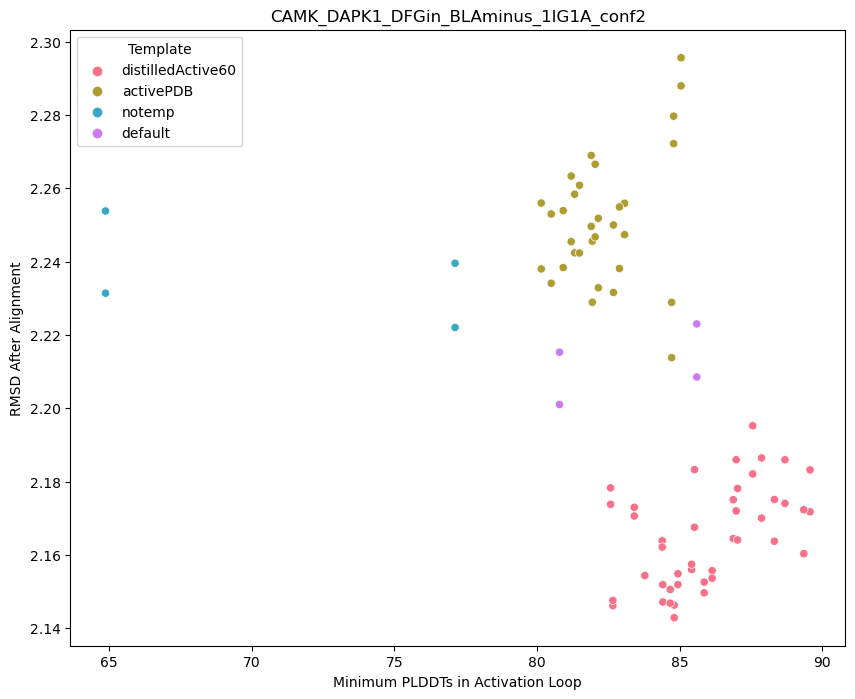

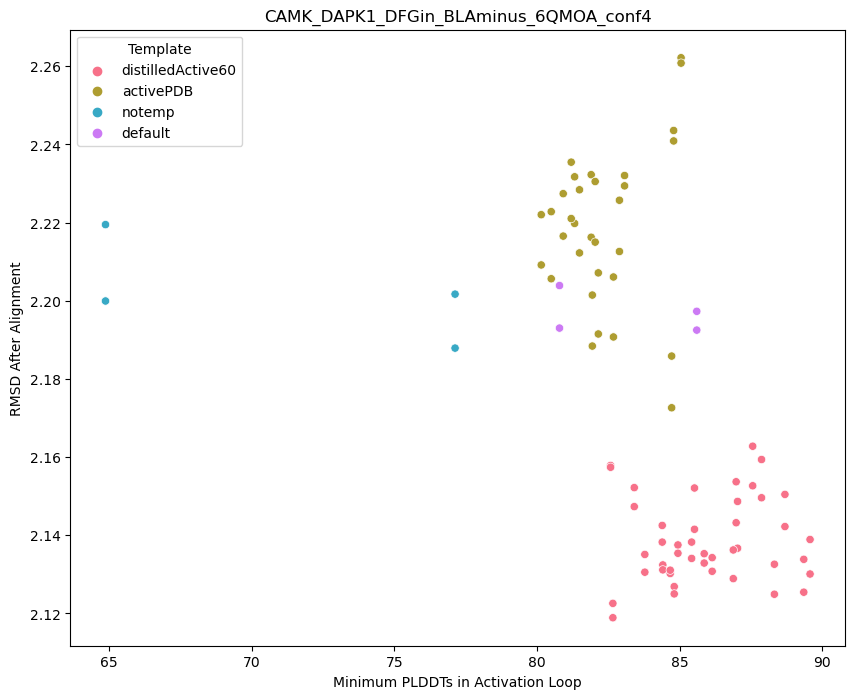

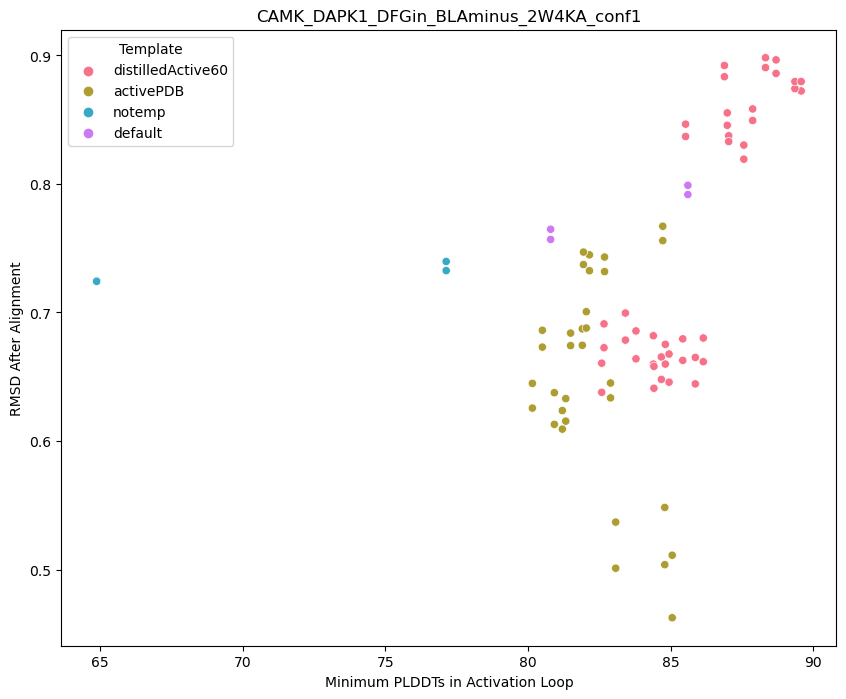

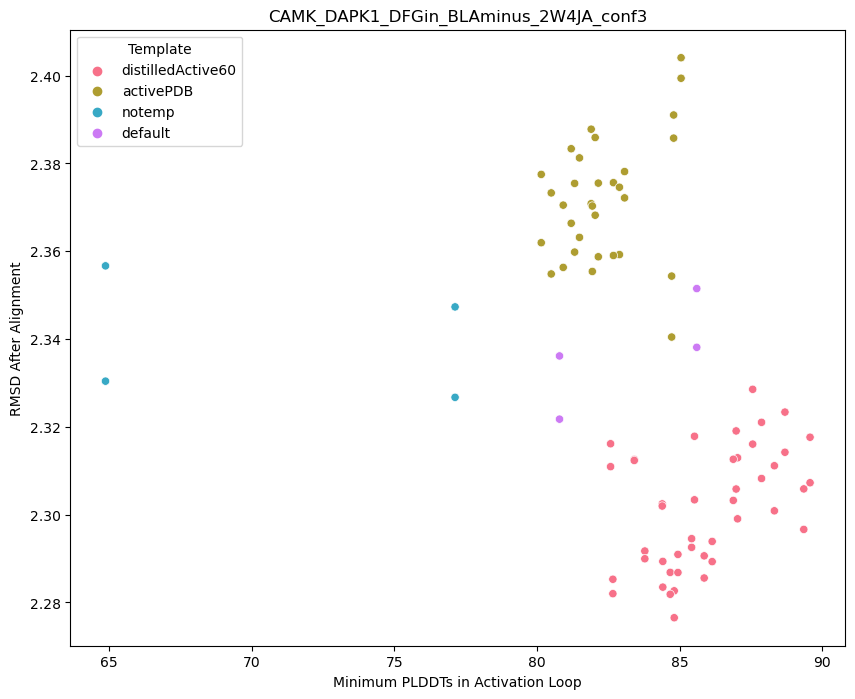

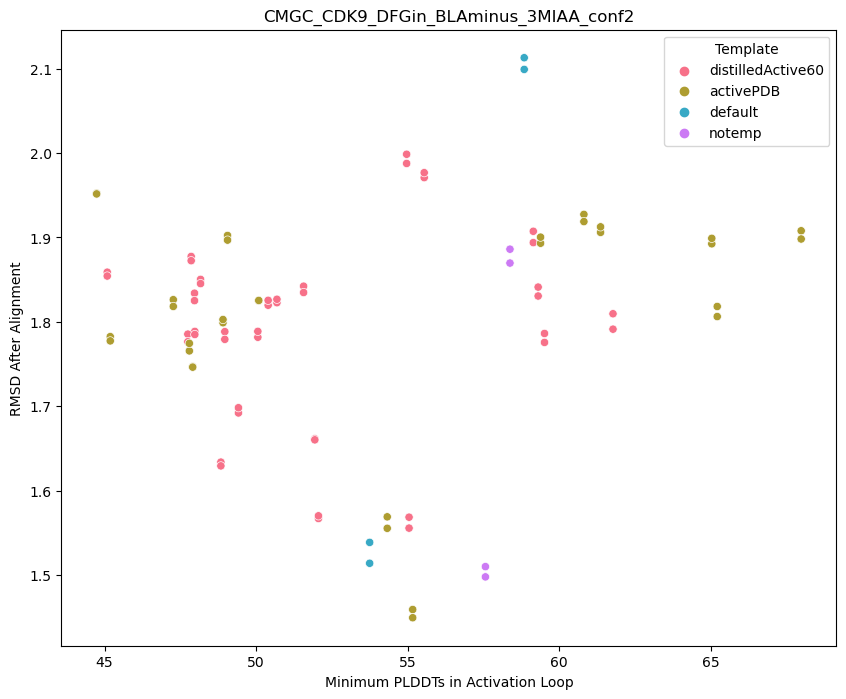

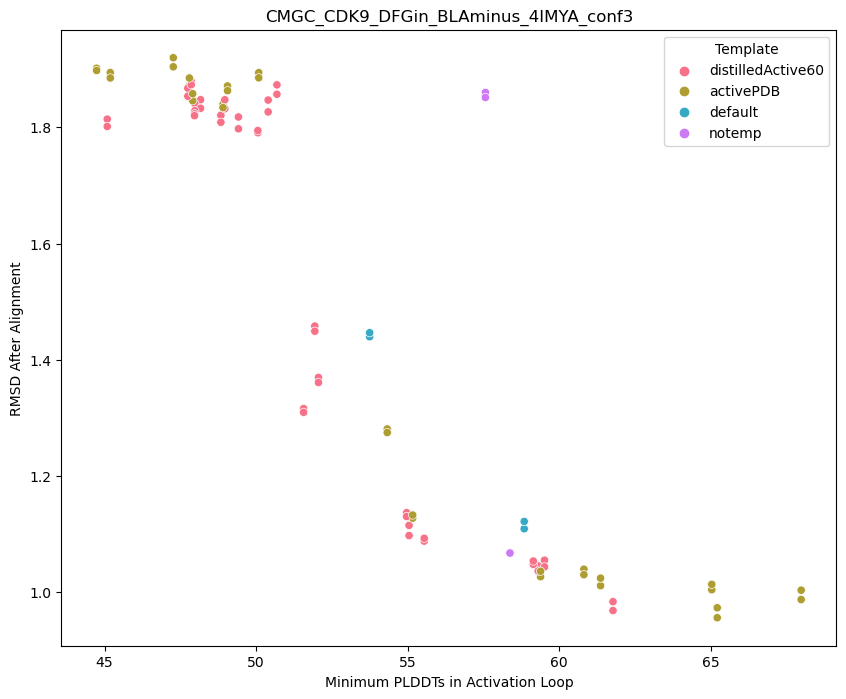

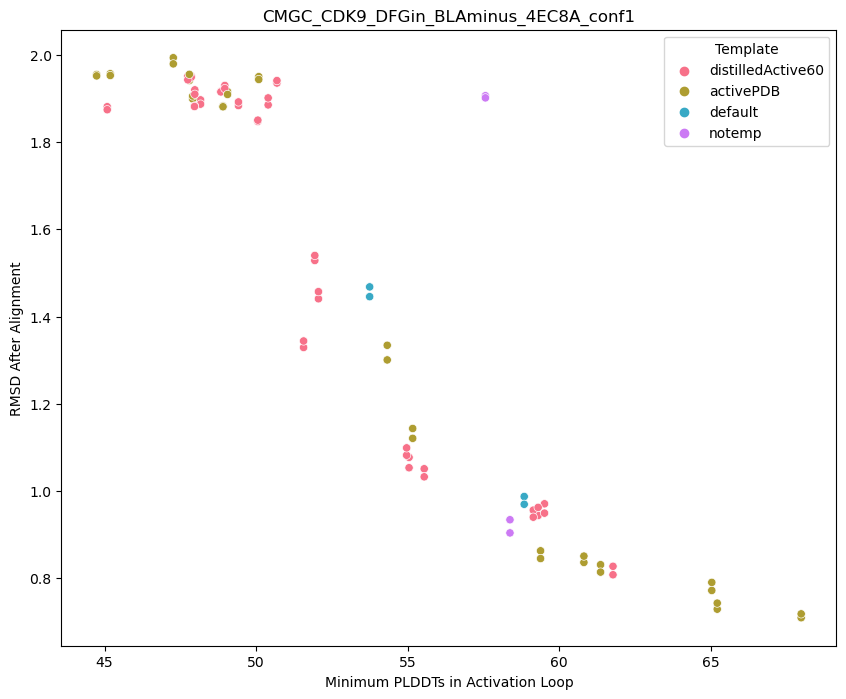

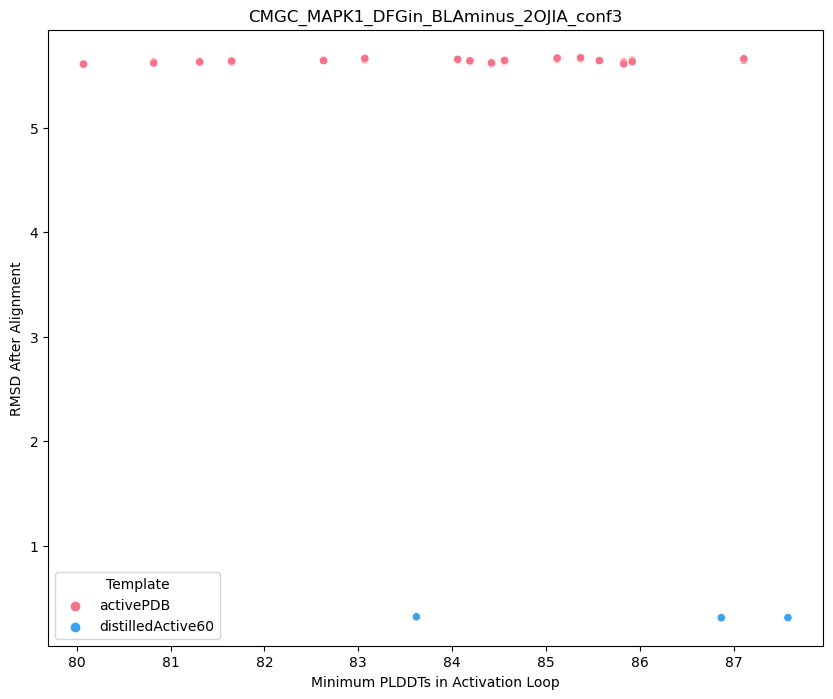

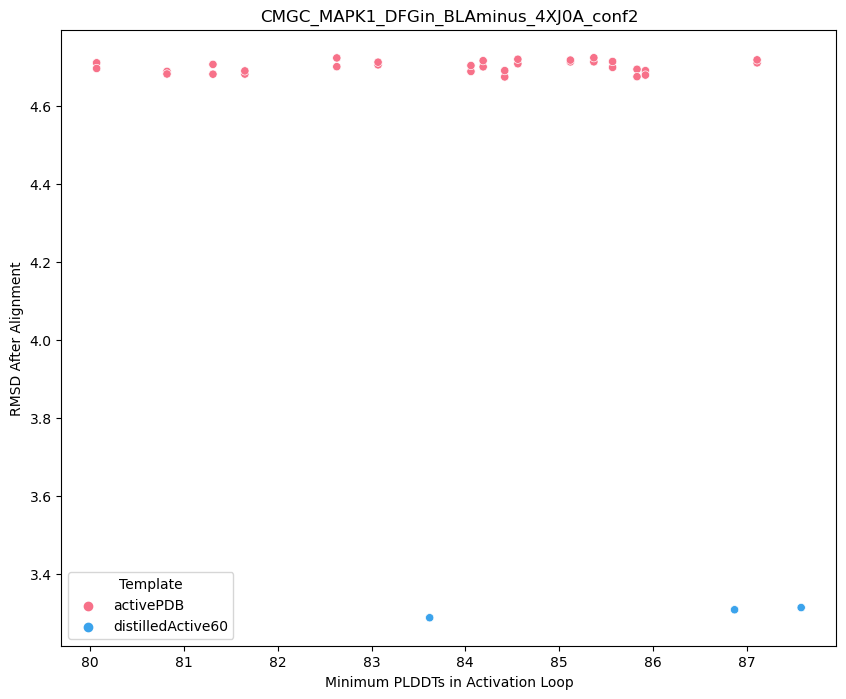

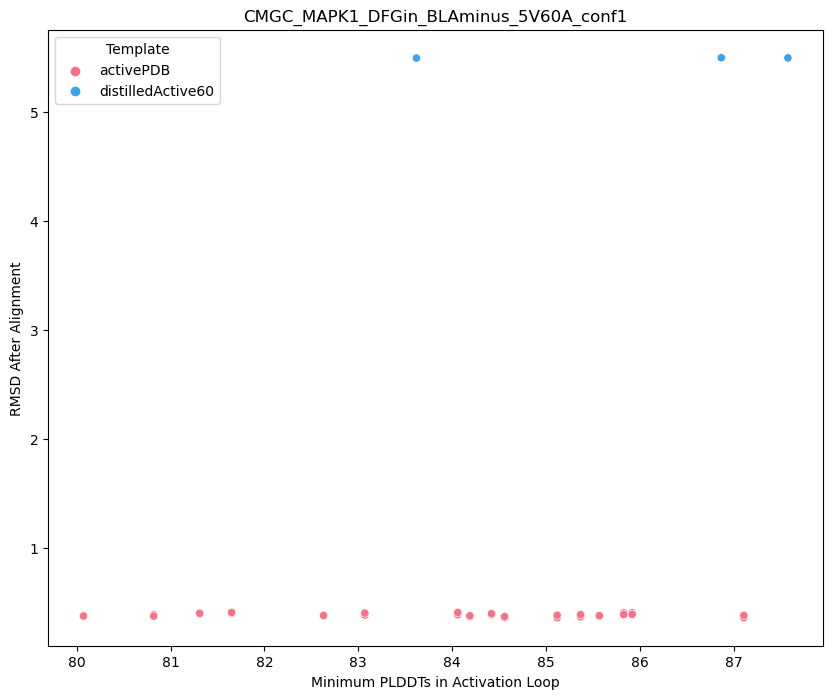

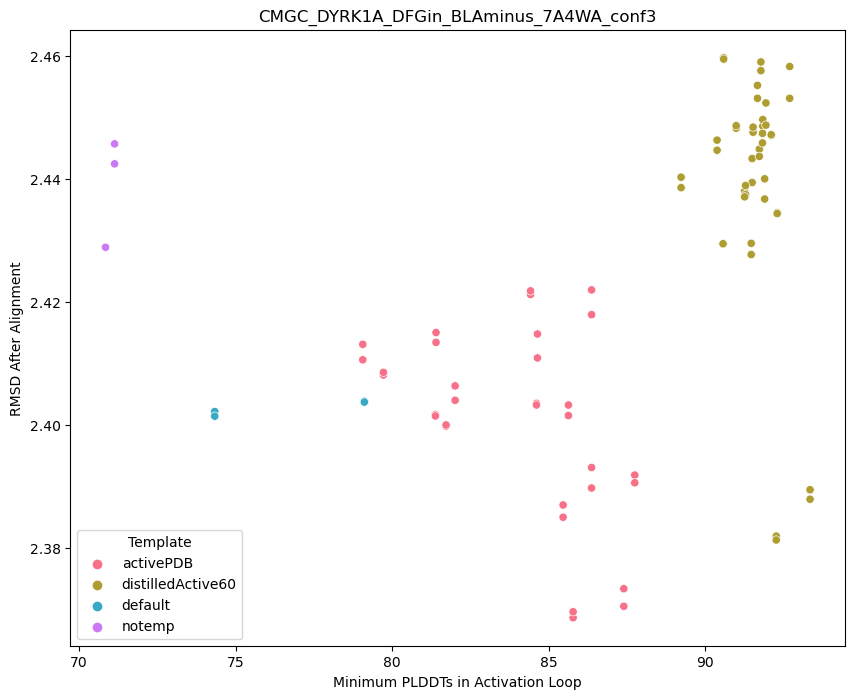

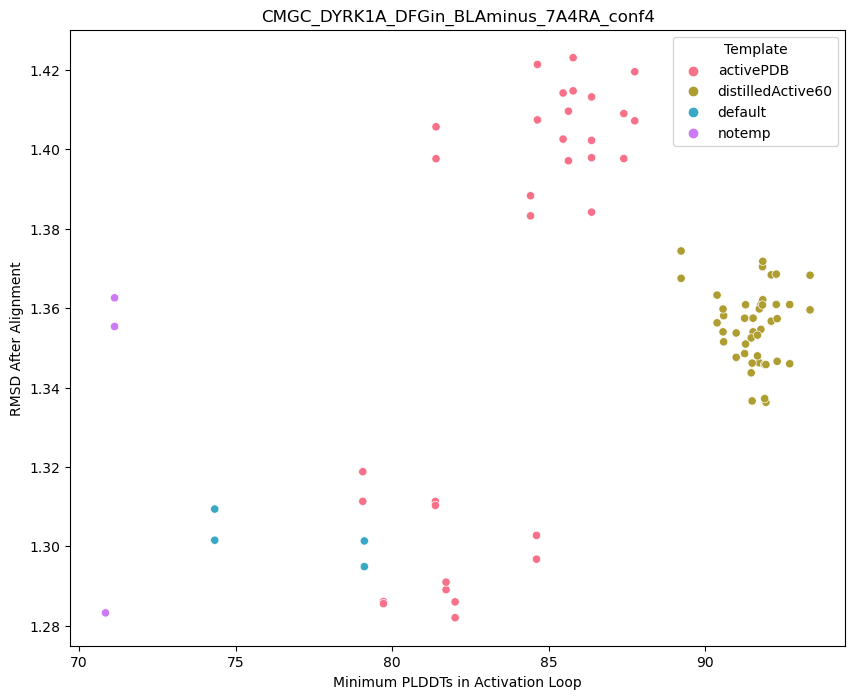

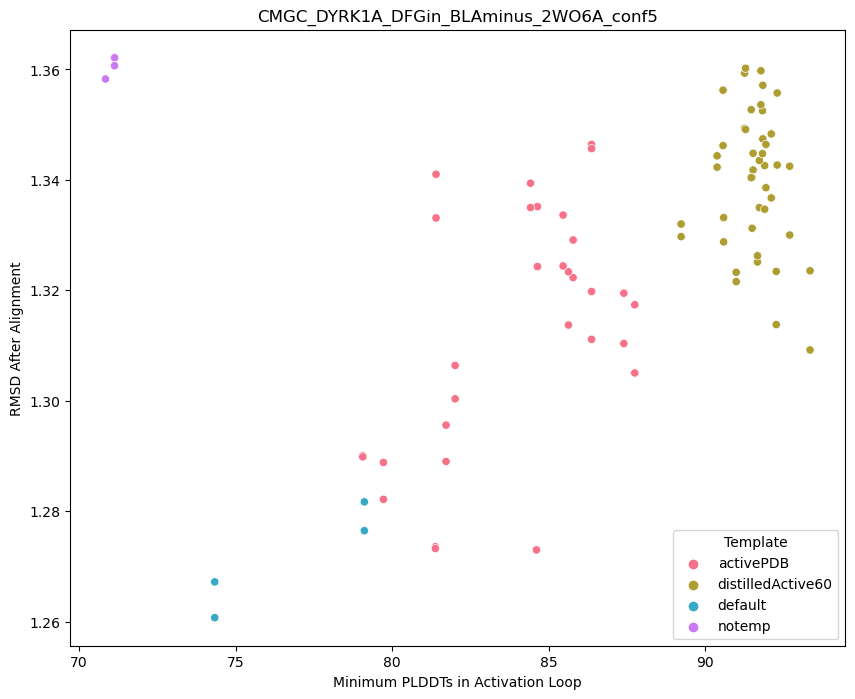

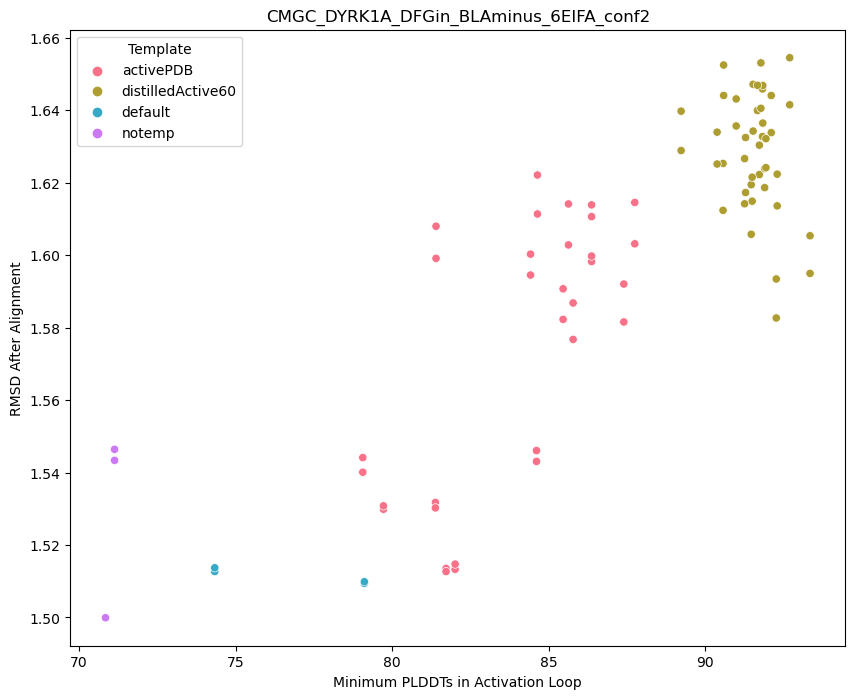

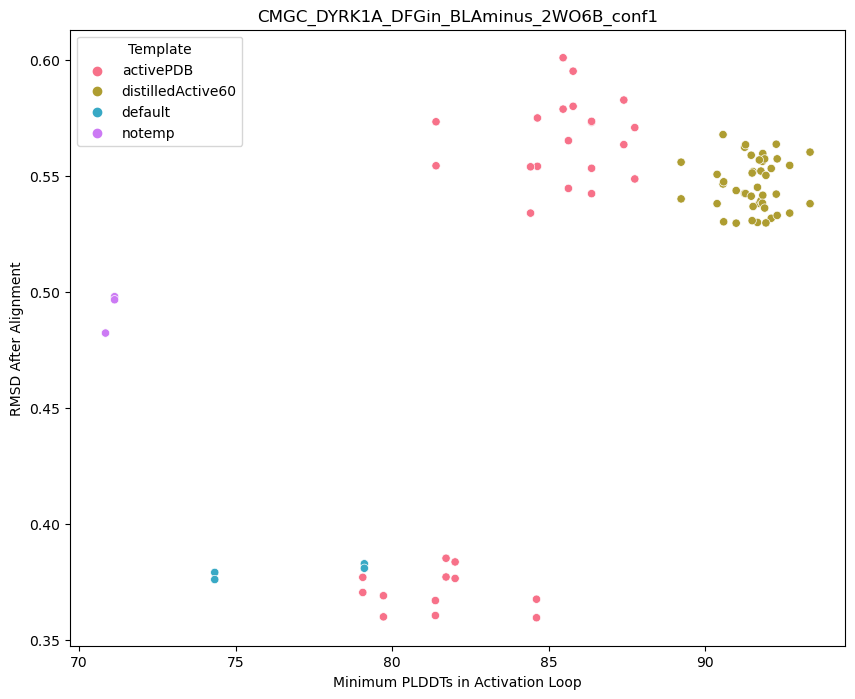

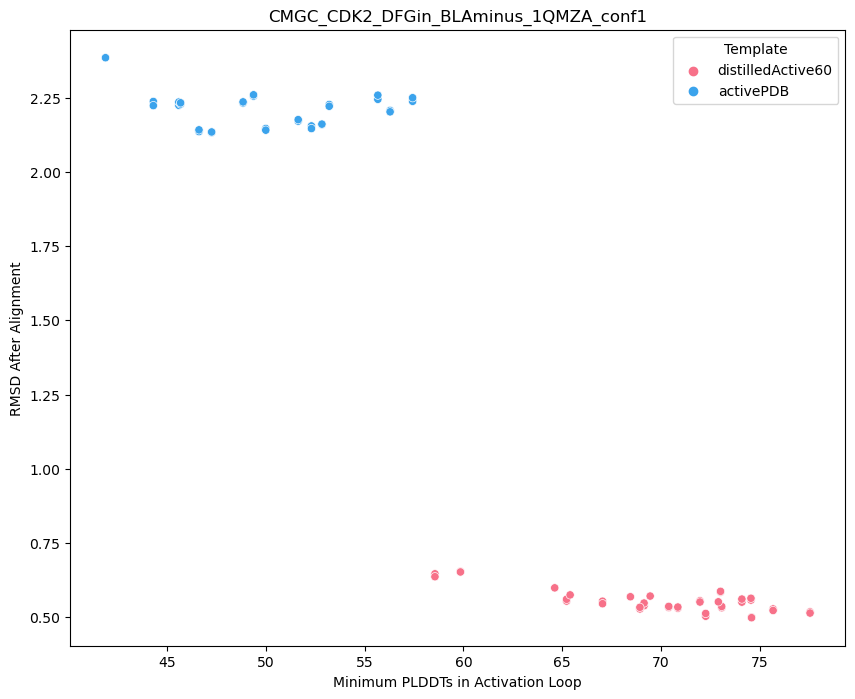

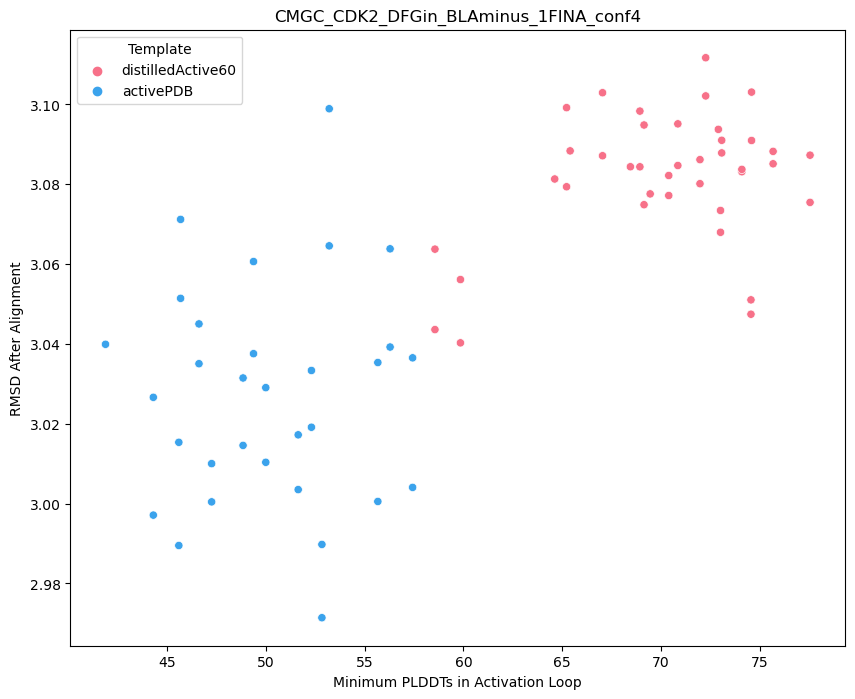

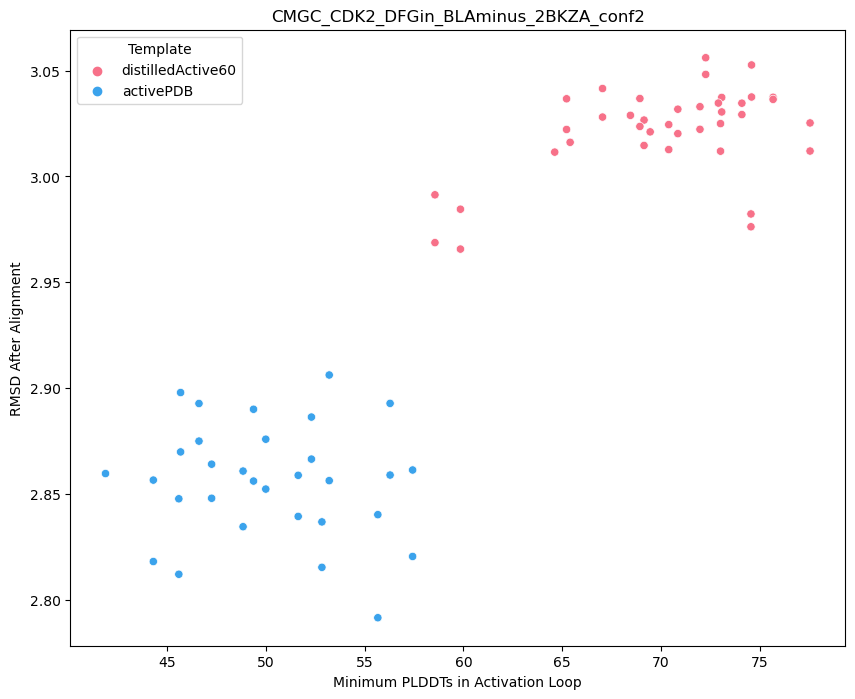

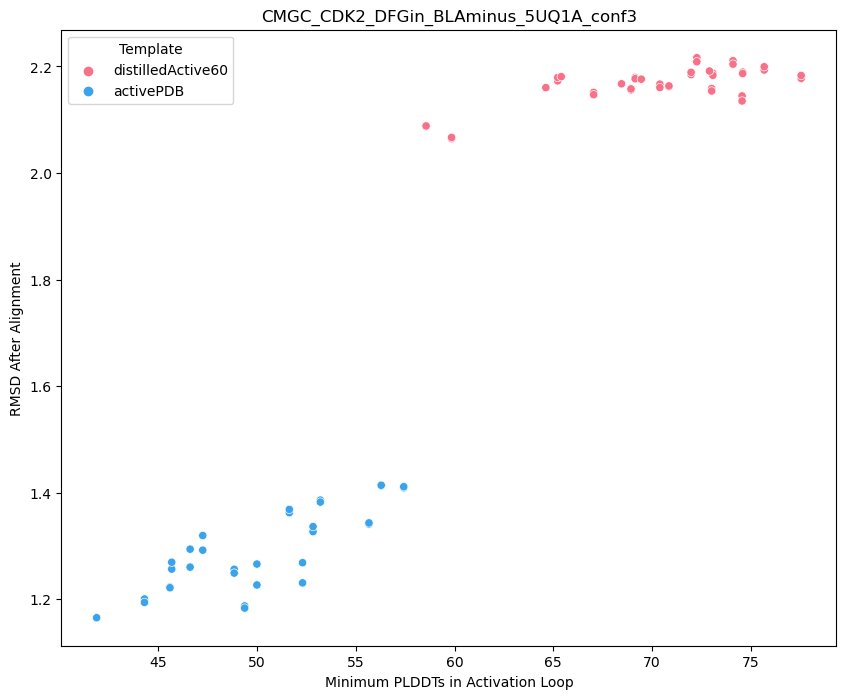

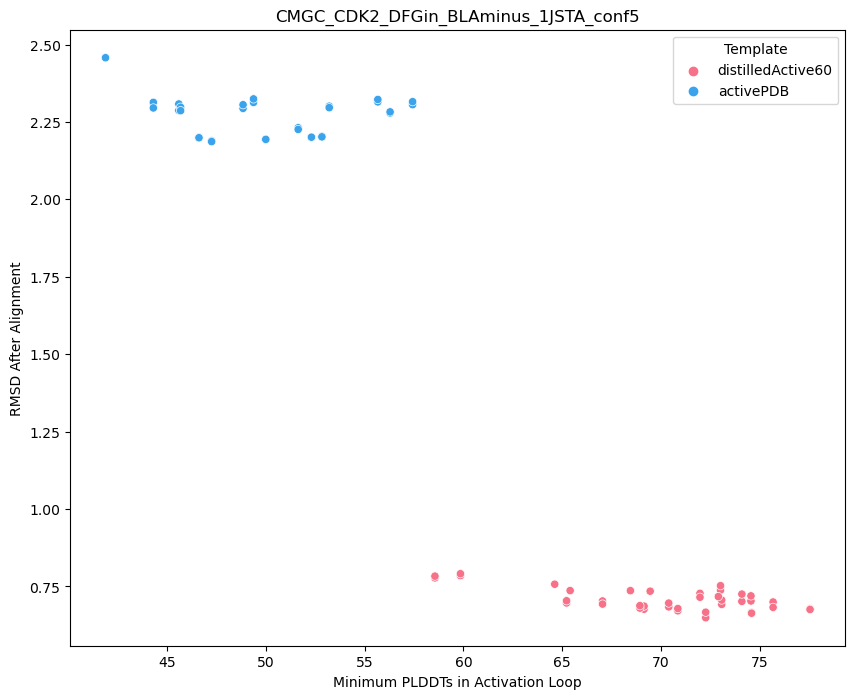

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime

now = datetime.datetime.now()
date_stamp = now.strftime("%y%m%d")

# Create the "./plots" folder with date stamp if it doesn't exist
plots_folder = f"./plots_{date_stamp}"
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

unique_pdb_file2_values = results_df['PDB_File2'].unique()

for pdb_file2 in unique_pdb_file2_values:
    filtered_df = results_df[(results_df['PDB_File2'] == pdb_file2) & (results_df['Status'] == 'Active') & (results_df['MSAlimNum'] > 5)]

    # Get the group_gene from the pdb_file2
    group_gene = get_gene_group(pdb_file2)
    file_name = os.path.basename(pdb_file2).strip(".pdb")
    
    # Define a custom color style
    n_colors = len(filtered_df["Template"].unique())+1  # Change this to the number of unique conformations you need
    palette = sns.color_palette("husl", n_colors)
    
    # Define a custom palette style without green
    green_index = None
    for idx, color in enumerate(palette):
        if 0.2 < color[1] < 0.8 and color[0] < 0.4:  # Adjust this condition to identify the green color in the palette
            green_index = idx
            break

    if green_index is not None:
        del palette[green_index]

    # Define a custom marker style
    marker_styles = {}  # Initialize an empty dictionary
    unique_markers = filtered_df["Template"].unique()
    for data in unique_markers:
        marker_styles[data] = "o"  # Assign a dot marker to each conformatio
        
    # Create a scatter plot with Min_B_Factor_Act_Loop on the x-axis and RMSD_After_Alignment on the y-axis, colored by Status
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=filtered_df, x="Min_PLDDT_Act_Loop", y="RMSD_After_Alignment_actloop40N", 
                    hue="Template", style="Template", markers=marker_styles, palette=palette)

    # Set plot labels
    plt.xlabel("Minimum PLDDTs in Activation Loop")
    plt.ylabel("RMSD After Alignment")
    plt.title(f"{file_name}")

    # Save the plot to the "./plots" folder with date stamp
    plot_filename = f"{os.path.basename(file_name)}_scatter_plot.png"
    plt.savefig(os.path.join(plots_folder, plot_filename), dpi=300)

    # Show the plot
    plt.show()